In [635]:
#!pip download lifelines
#%pip install input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
#%pip install input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
#%pip install input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

In [636]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import rankdata 
import numpy as np
from tqdm import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor

from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb

from metric import score
import optuna
from typing import Dict, Tuple, Optional, List
import json

from itertools import combinations_with_replacement

In [637]:
# set analysis output directory
def create_output_directory(output_path):
    """Create the output directory if it doesn't exist and set plotting style."""
    os.makedirs(output_path, exist_ok=True)
    return output_path

output_path = 'working/analysis'
create_output_directory(output_path)

'working/analysis'

In [638]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("input/data/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("input/data/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No           NaN       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No           NaN       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No           NaN       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0               NaN             NaN              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_issue pulm_severe  \
0            6.0       Bone marrow        No          No          No   
1            6.0  Peripheral blood        No          No          No   
2            6.0       Bone marrow        No          No          No   
3            6.0       Bone marrow        No          No          No   
4            6.0  Peripheral blood        No          No          No   

  prim_disease_hct  hla_high_res_6 cmv_status  hla_high_res_10  \
0              IEA             6.0        +/+              NaN   
1              AML             6.0        +/+             10.0   
2              HIS             6.0        +/+             10.0   
3              ALL             6.0        +/+             10.0   
4              MPN             6.0        +/+             10.0   

   hla_match_dqb1_high tce_imm_match  hla_nmdp_6  hla_match_c_low rituximab  \
0                  2.0           NaN         6.0              2.0        No   
1                  2.0           P/P         6.0              2.0        No   
2                  2.0           P/P         6.0              2.0        No   
3                  2.0           P/P         6.0              2.0        No   
4                  2.0           NaN         5.0              2.0        No   

   hla_match_drb1_low  hla_match_dqb1_low prod_type cyto_score_detail  \
0                 2.0                 2.0        BM               NaN   
1                 2.0                 2.0        PB      Intermediate   
2                 2.0                 2.0        BM               NaN   
3                 2.0                 2.0        BM      Intermediate   
4                 2.0                 2.0        PB               NaN   

  conditioning_intensity               ethnicity  year_hct obesity   mrd_hct  \
0                    NaN  Not Hispanic or Latino      2016      No       NaN   
1                    MAC  Not Hispanic or Latino      2008      No  Positive   
2                    NaN  Not Hispanic or Latino      2019      No       NaN   
3                    MAC  Not Hispanic or Latino      2009      No  Positive   
4                    MAC      Hispanic or Latino      2018      No       NaN   

  in_vivo_tcd   tce_match  hla_match_a_high hepatic_severe  donor_age  \
0         Yes         NaN               2.0             No        NaN   
1          No  Permissive               2.0             No      72.29   
2         Yes         NaN               2.0             No        NaN   
3          No  Permissive               2.0             No      29.23   
4         Yes         NaN               2.0             No      56.81   

  prior_tumor  hla_match_b_low peptic_ulcer  age_at_hct  hla_match_a_low  \
0          No              2.0           No       9.942              2.0   
1          No              2.0           No      43.705              2.0   
2          No              2.0           No      33.997              2.0   
3          No              2.0           No      43.245              2.0   
4          No              2.0           No      29.740              

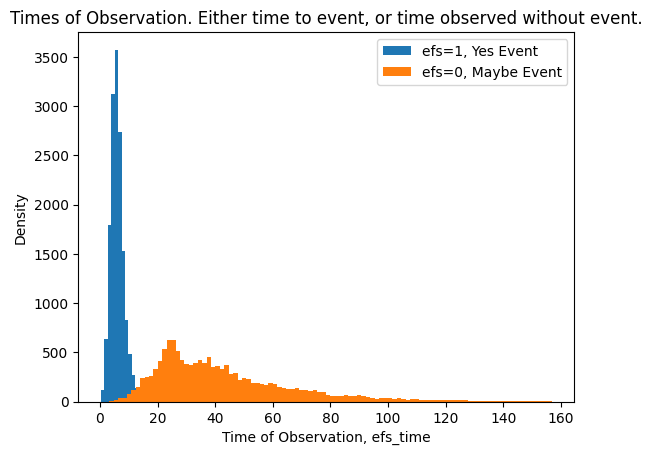

In [639]:
# Train targets
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.savefig(f'{output_path}/times_of_observation.png')
plt.show()

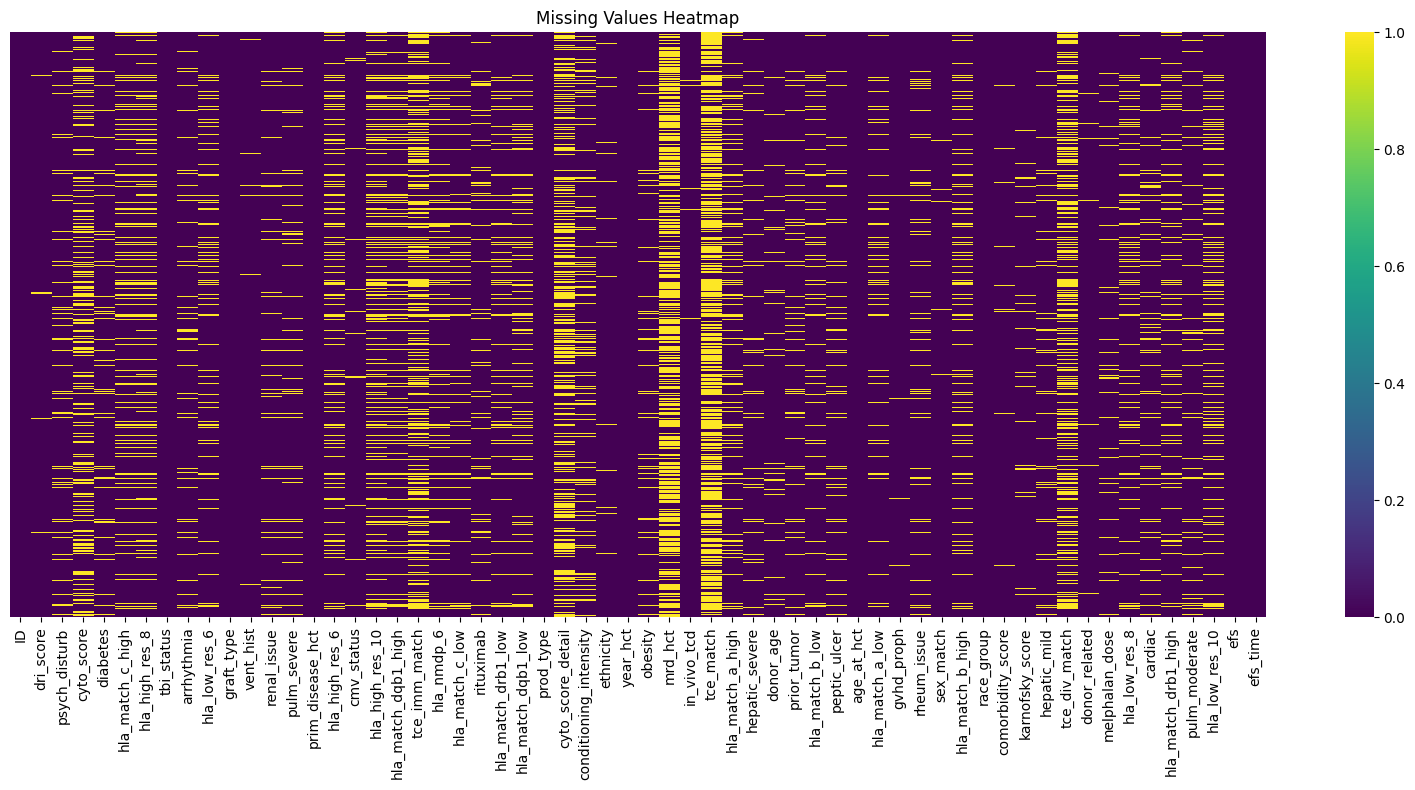

In [640]:
# missing values heatmap
def plot_missing_values_heatmap(df, output_path):
    plt.figure(figsize=(16, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_heatmap.png')
    plt.show()
    plt.close()

plot_missing_values_heatmap(train, output_path)

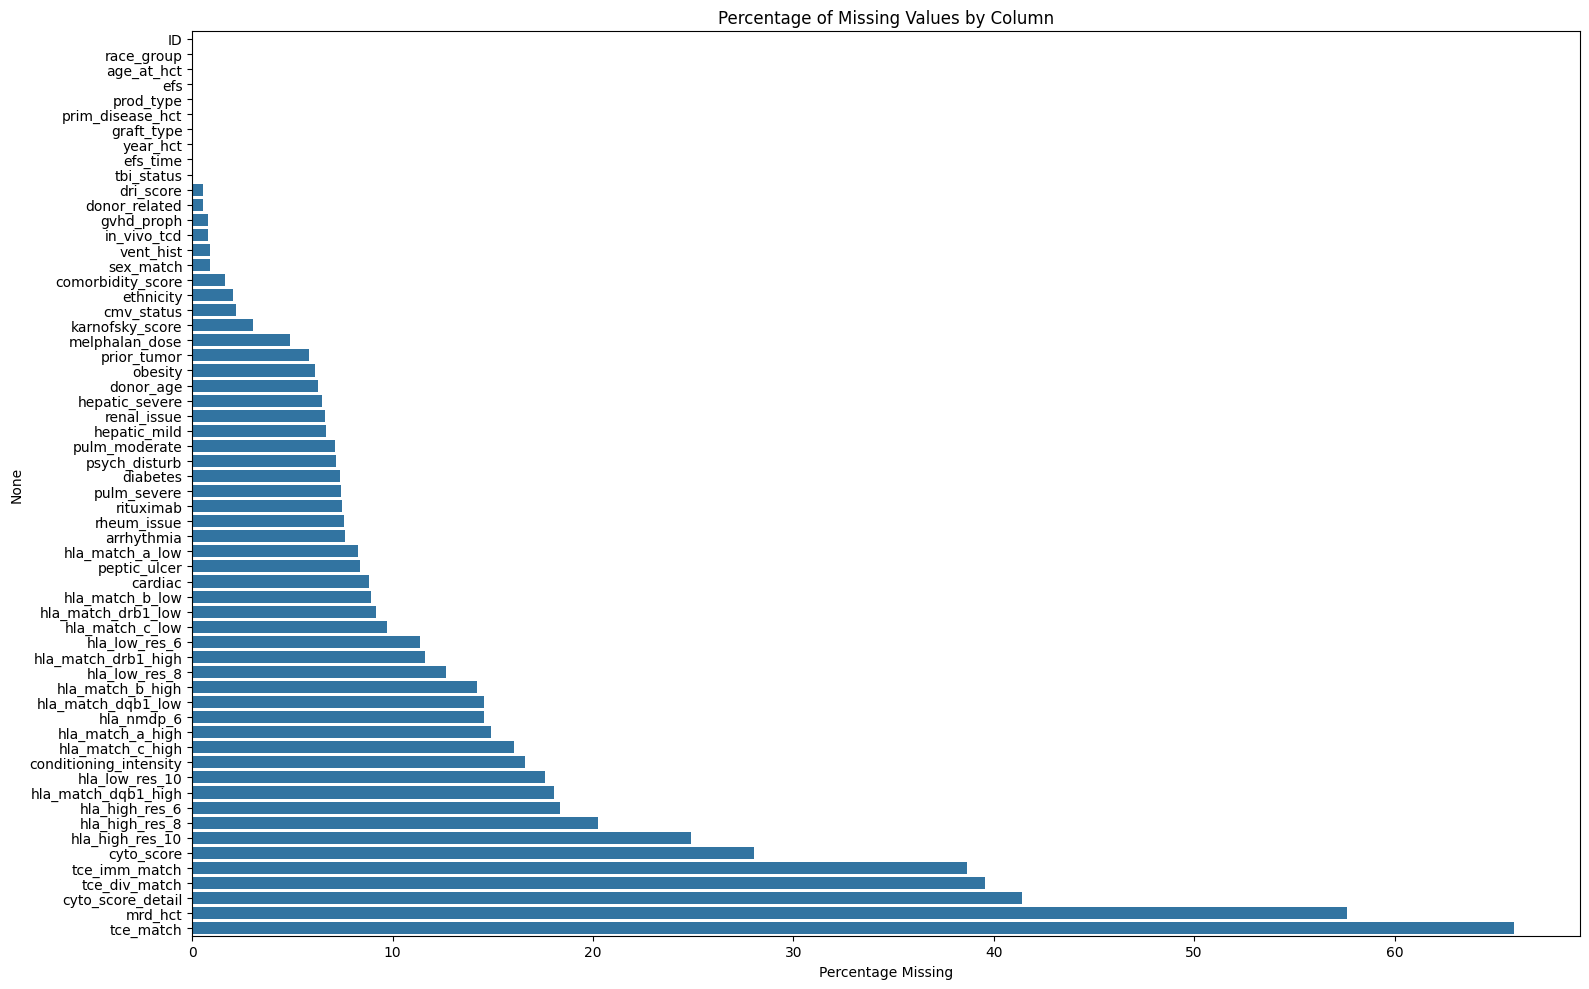

In [641]:
# missing value percentages
def plot_missing_values_bars(df, output_path):
    plt.figure(figsize=(16, 10))
    missing_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
    sns.barplot(x=missing_percentages.values, y=missing_percentages.index)
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Percentage Missing')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_percentage.png')
    plt.show()
    plt.close()

plot_missing_values_bars(train, output_path)

In [642]:
# numerical distributions
def plot_numerical_distributions(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    # Create progress bar for numerical distributions
    for col in tqdm(numerical_cols, desc="Creating distribution plots"):
        plt.figure(figsize=(10, 6))
        
        # Create subplot with histogram and kde
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        # Add statistical annotations
        stats_text = f'Mean: {df[col].mean():.2f}\n'
        stats_text += f'Median: {df[col].median():.2f}\n'
        stats_text += f'Std: {df[col].std():.2f}'
        plt.text(0.95, 0.95, stats_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'{output_path}/distribution_{col}.png')
        plt.close()

plot_numerical_distributions(train, output_path)

Creating distribution plots: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


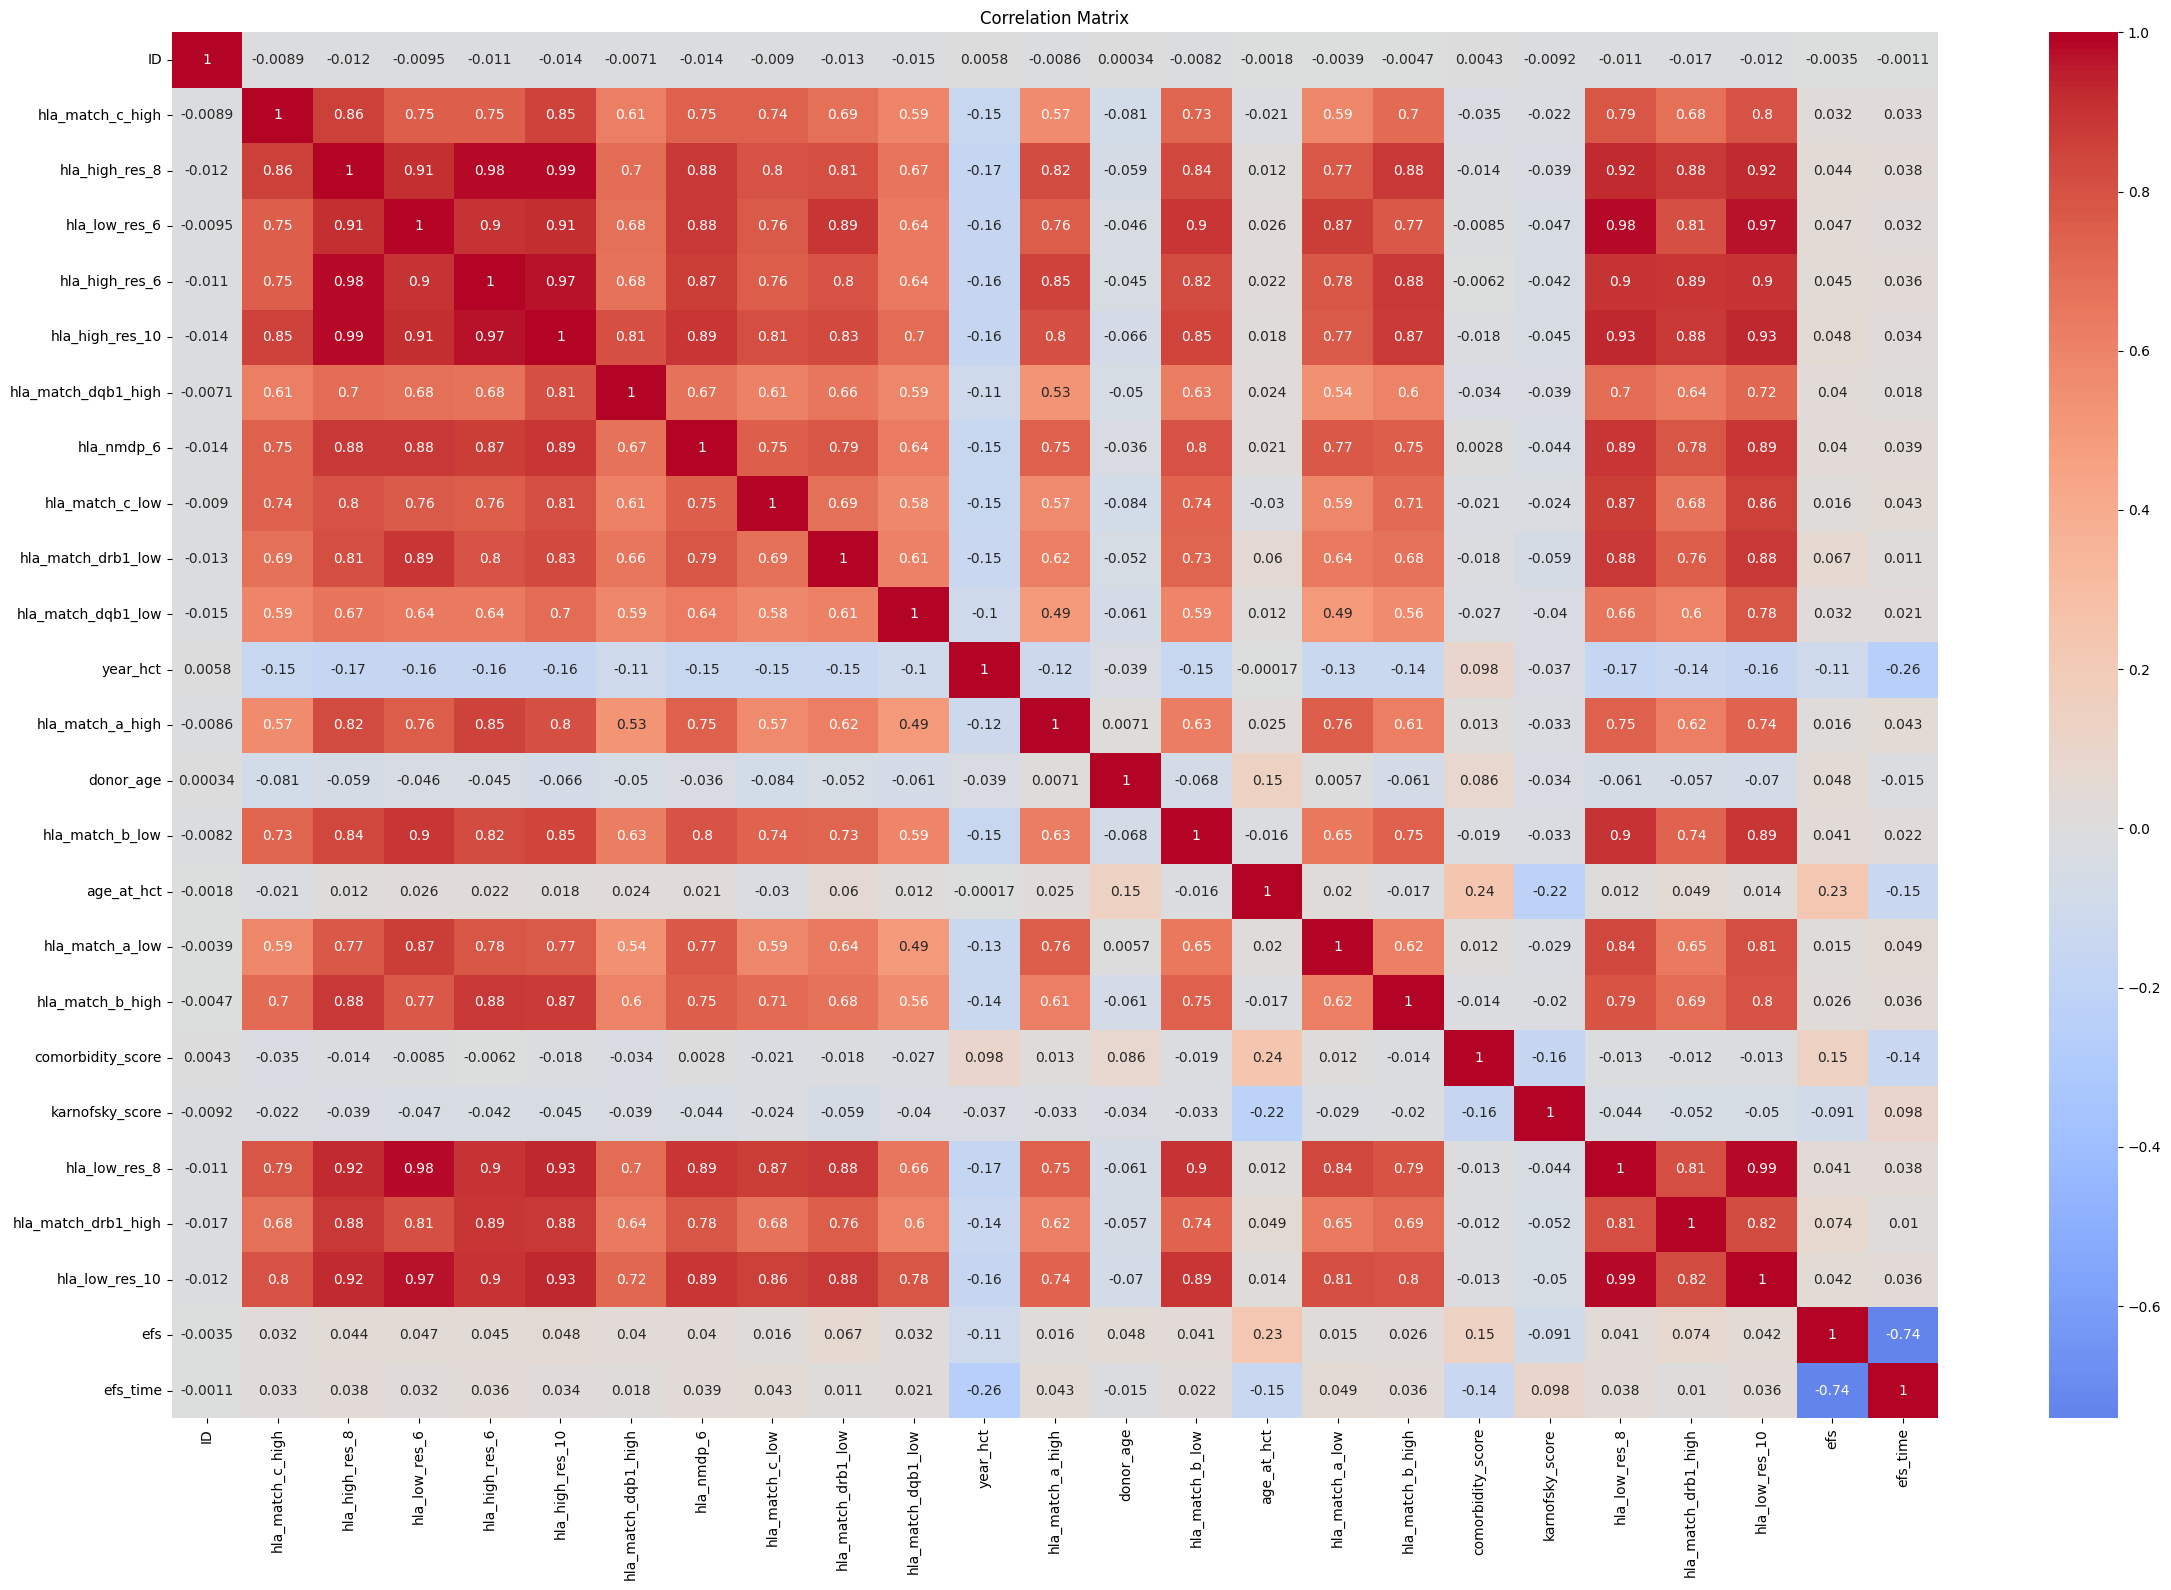

In [643]:
# correlation matrix
def plot_correlation_matrix(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    if len(numerical_cols) > 1:
        plt.figure(figsize=(24, 16))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.savefig(f'{output_path}/correlation_matrix.png')
        plt.show()
        plt.close()

plot_correlation_matrix(train, output_path)

In [644]:
# categorical distributions
def plot_categorical_distributions(df, output_path):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in tqdm(categorical_cols, desc="Creating categorical plots"):
        if df[col].nunique() < 30:
            plt.figure(figsize=(12, 6))
            value_counts = df[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f'{output_path}/categorical_{col}.png')
            plt.close()

plot_categorical_distributions(train, output_path)

Creating categorical plots: 100%|██████████| 35/35 [00:02<00:00, 12.56it/s]


In [645]:
FEATURES = train.columns
print(f"Number of Features: {len(FEATURES)} FEATURES: {FEATURES}")

Number of Features: 60 FEATURES: Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_

In [646]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("Missing")
        test[c] = test[c].fillna("Missing")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [647]:
#imputer = KNNImputer(n_neighbors=101)
#numeric_cols = train[FEATURES].select_dtypes(include=['int32', 'float32', 'float64', 'int64']).columns
#imputed_data = imputer.fit_transform(train[numeric_cols])
#train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
#for col in train.columns:
#    if col not in numeric_cols:
#        train_imputed[col] = train[col]
        
#train = train_imputed

In [648]:
# Feature Engineering
def feature_engineering(df):   
    df = df.copy()
    # replace NaN with median values for numerical columns
    median_comorbidity = df['comorbidity_score'].median()
    df['comorbidity_score'] = df['comorbidity_score'].replace([np.inf, -np.inf, '', None], np.nan).fillna(median_comorbidity)
    df['karnofsky_score'] = df['karnofsky_score'].replace([np.inf, -np.inf, '', None], np.nan).fillna(0)
    median_donor_age = df['donor_age'].median()
    df['donor_age'] = df['donor_age'].replace([np.inf, -np.inf, '', None], np.nan).fillna(median_donor_age)
    median_age = df['age_at_hct'].median()
    df['age_at_hct'] = df['age_at_hct'].replace([np.inf, -np.inf, '', None], np.nan).fillna(median_age)
    
    # Create age bins in 5-year intervals
    df['age_bin'] = pd.cut(df['age_at_hct'], 
                          bins=range(0, 95, 5),  # From 0 to 75 in steps of 5
                          labels=[f'{i}-{i+4}' for i in range(0, 90, 5)],
                          include_lowest=True)
    
    # commorbity by age at hct
    df['comorbidity_age'] = df['comorbidity_score'] / (df['age_at_hct'])
    
    df['age_bin_race'] = (df['age_bin'].astype(str) + '_' + 
                      df['race_group'].astype(str)).astype('category')

    # age x cyto
    df['cyto_age'] = (df['cyto_score_detail'].astype(str) + '_' + df['age_bin'].astype(str)).astype('category')

    # Concatenate graft_type and prod_type
    df['graft_prod'] = (df['graft_type'].astype(str) + '_' + 
                    df['prod_type'].astype(str)).astype('category')

    # Concatenate graft_type and prim_disease_hct
    df['graft_prim_disease'] = (df['graft_type'].astype(str) + '_' + 
                    df['prim_disease_hct'].astype(str)).astype('category')

    df['graft_cmv_status'] = (df['graft_type'].astype(str) + '_' + 
                    df['cmv_status'].astype(str)).astype('category')
    
    # Concatenate age bin and pulm severe
    df['age_bin_pulm_severe'] = (df['age_bin'].astype(str) + '_' + 
                    df['pulm_severe'].astype(str)).astype('category')
    
    # Concatenate age bin, race_group, and dri score
    df['age_bin_dri'] = (df['age_bin'].astype(str) + '_' + 
                    df['dri_score'].astype(str)).astype('category')

    # hla high mean
    df['hla_high_res_mean'] = df[['hla_high_res_8', 'hla_high_res_10', 'hla_high_res_6']].mean(axis=1)

    # hla low mean
    df['hla_low_res_mean'] = df[['hla_low_res_8', 'hla_low_res_10', 'hla_low_res_6']].mean(axis=1)

    # ration of hla high and hla low
    df['hla_ratio_res_highlow'] = (df['hla_high_res_mean'])/(df['hla_low_res_mean']+1)

    # ration of hla low and hla high
    df['hla_ratio_res_lowhigh'] = (df['hla_low_res_mean'])/(df['hla_high_res_mean']+1)

    # age functions
    df['donor_by_age_at_hct'] = (df['donor_age']/df['age_at_hct'])
    df['comorbidity_score_by_age_at_hct'] = (df['comorbidity_score']/df['age_at_hct'])
    
    # match drb
    df['hla_match_drb1_mean'] = df[['hla_match_drb1_high', 'hla_match_drb1_low']].mean(axis=1)

    # match dqb
    df['hla_match_dqb1_mean'] = df[['hla_match_dqb1_high', 'hla_match_dqb1_low']].mean(axis=1)

    # additional ratios
    df['hla_high_low_ratio'] = (df['hla_high_res_mean']) / (df['hla_low_res_mean'] + 1)
    df['drb1_dqb1_ratio'] = (df['hla_match_drb1_mean']) / (df['hla_match_dqb1_mean'] + 1)

    # difference in features
    df['high_low_diff'] = df['hla_high_res_mean'] - df['hla_low_res_mean']
    df['drb1_dqb1_diff'] = df['hla_match_drb1_mean'] - df['hla_match_dqb1_mean']

    # statistical aggregations
    df['hla_mean'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].mean(axis=1)
    df['hla_std'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].std(axis=1)
    df['hla_max'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].max(axis=1)
    df['hla_min'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].min(axis=1)

    # interaction terms
    df['drb1_high_interaction'] = df['hla_match_drb1_mean'] * df['hla_high_res_mean']
    df['dqb1_low_interaction'] = df['hla_match_dqb1_mean'] * df['hla_low_res_mean']

    # with or without TBI
    df['with_tbi'] = np.where((df['tbi_status']).astype(str) == 'No TBI', 'no', 'yes')

    # Create donor sex feature
    df['sex_donor'] = (df['sex_match']).astype(str).str[0]

    # Create recipient sex feature
    df['sex_recipient'] = (df['sex_match']).astype(str).str[2]

    # Main drug presence
    df['has_FK'] = (df['gvhd_proph']).astype(str).str.contains('FK', na=False).astype(int)
    df['has_MMF'] = (df['gvhd_proph']).astype(str).str.contains('MMF', na=False).astype(int)
    df['has_MTX'] = (df['gvhd_proph']).astype(str).str.contains('MTX', na=False).astype(int)
    df['has_CSA'] = (df['gvhd_proph']).astype(str).str.contains('CSA', na=False).astype(int)
    df['has_cyclophosphamide'] = (df['gvhd_proph']).astype(str).str.contains('Cyclophosphamide', na=False).astype(int)

    # Check for combination therapy
    df['has_combination'] = (df['gvhd_proph']).astype(str).str.contains('\+', na=False).astype(int)

    # Count number of agents (approximate by counting '+' signs)
    df['n_agents'] = (df['gvhd_proph']).astype(str).str.count('\+').add(1)

    # Complex vs Simple regimen
    df['is_complex'] = (df['gvhd_proph']).astype(str).str.contains('others', na=False).astype(int)

    # Depletion-based therapy
    df['is_depletion_based'] = (df['gvhd_proph']).astype(str).str.contains('TDEPLETION|CDselect', na=False).astype(int)

    # Monotherapy flag
    df['is_monotherapy'] = (df['gvhd_proph']).astype(str).str.contains('alone', na=False).astype(int)

    # No prophylaxis flag
    df['no_prophylaxis'] = ((df['gvhd_proph']).astype(str) == 'No GvHD Prophylaxis').astype(int)

    def get_primary_agent(x):
        if pd.isna(x):
            return 'Unknown'
        elif 'FK' in x:
            return 'FK-based'
        elif 'CSA' in x:
            return 'CSA-based'
        elif 'Cyclophosphamide' in x:
            return 'Cyclophosphamide-based'
        elif 'TDEPLETION' in x or 'CDselect' in x:
            return 'Depletion-based'
        else:
            return 'Other'

    df['primary_agent'] = (df['gvhd_proph']).astype(str).apply(get_primary_agent)

    # Standard vs Alternative approach
    df['is_standard_approach'] = (df['gvhd_proph']).astype(str).str.contains('FK\+ MMF|FK\+ MTX|CSA \+ MTX', na=False).astype(int)

    # Experimental/Other
    df['is_experimental'] = ((df['gvhd_proph']).astype(str) == 'Other GVHD Prophylaxis').astype(int)

    # Combine with other relevant features
    df['FK_MMF_interaction'] = df['has_FK'] * df['has_MMF']
    #df['CSA_MTX_interaction'] = df['has_CSA'] * df['has_MTX']

    # karnofsky score
    df['karnofsky_age_at_hct'] = df['karnofsky_score'] * df['age_at_hct']
    df['karnofsky_standardized'] = (df['karnofsky_score'] - df['karnofsky_score'].mean()) / df['karnofsky_score'].std()
    df['graft_prod'] = df['graft_prod'].astype('category')

    # Create performance categories
    df['karnofsky_category'] = pd.cut(
        df['karnofsky_score'],
        bins=[0, 60, 80, 90, 100],
        labels=['poor', 'moderate', 'good', 'excellent']
    )

    # Clinical thresholds
    df['karnofsky_below_70'] = (df['karnofsky_score'] < 70).astype(int)
    df['karnofsky_above_80'] = (df['karnofsky_score'] > 80).astype(int)

    # Deviation from median
    median_karnofsky = df['karnofsky_score'].median()
    df['karnofsky_deviation'] = df['karnofsky_score'] - median_karnofsky

    # vivo
    df['in_vivo_tcd'].fillna("Missing")
    df['prim_disease_hct'].fillna("Missing")
    df['vivo_age_bin'] = (df['age_bin'].astype(str) + '_' + 
                    df['in_vivo_tcd'].astype(str)).astype('category')
    df['vivo_comorbidity'] = (df['comorbidity_score'].astype(str) + '_' + 
                    df['in_vivo_tcd'].astype(str)).astype('category')
    df['vivo_prim_disease'] = (df['prim_disease_hct'].astype(str) + '_' + 
                    df['in_vivo_tcd'].astype(str)).astype('category') 
    
    # dri
    # Map risk levels to numeric scores
    risk_map = {
        'Low': 1,
        'Intermediate': 2,
        'High': 3,
        'Very high': 4,
        'N/A - non-malignant indication': -1,
        'N/A - pediatric': -2,
        'N/A - disease not classifiable': -3,
        'TBD cytogenetics': -4,
        'Missing disease status': 0
    }
    
    # Create numeric DRI score
    df['dri_numeric'] = df['dri_score'].map(risk_map)

    # Fill missing values with median
    median_dri = df['dri_numeric'].median()
    df['dri_numeric'] = df['dri_numeric'].fillna(median_dri)

    # Create binary features for risk levels
    df['is_high_risk'] = df['dri_score'].isin(['High', 'Very high']).astype(int)
    df['is_standard_risk'] = df['dri_score'].isin(['Low', 'Intermediate']).astype(int)
    # df['is_special_case'] = df['dri_score'].str.contains('N/A|TBD|Missing', na=False).astype(int)

    # Combine with other relevant features
    df['dri_age'] = df['dri_numeric'] * df['age_at_hct']
    df['dri_comorbidity'] = df['dri_numeric'] * df['comorbidity_score']
    df['dri_karnofsky'] = df['dri_numeric'] / (df['karnofsky_score'] + 1)

    # Risk-weighted karnofsky performance
    df['karnofsky_weighted_performance'] = (
        df['karnofsky_score'] * 
        (1 - df['dri_age'].clip(0, 1))  # Clip DRI age to [0,1] range
    )

    # Create risk-adjusted Karnofsky
    df['karnofsky_risk_adjusted'] = df['karnofsky_score'] * (1 + df['dri_age'])
    
    # Create categorical combinations
    df['dri_disease_status'] = (df['dri_score'].astype(str) + '_' + 
                               df['tbi_status'].astype(str)).astype('category')
    
    # Ethnicity
    df['ethnicity'].fillna("Missing")
    df['age_bin_ethnicity'] = (df['age_bin'].astype(str) + '_' + 
                    df['ethnicity'].astype(str)).astype('category')
    df['dri_ethnicity'] = (df['dri_score'].astype(str) + '_' + 
                    df['ethnicity'].astype(str)).astype('category')
    df['ethnicity_vivo'] = (df['ethnicity'].astype(str) + '_' + 
                    df['in_vivo_tcd'].astype(str)).astype('category')

    # Calculate HLA mismatch score
    hla_match_cols = [col for col in df.columns if 'hla_match' in col and ('high' in col or 'low' in col)]
    df['hla_mismatch_score'] = len(hla_match_cols) - df[hla_match_cols].sum(axis=1)
    
    # HLA Match Score Aggregations
    hla_cols = [col for col in df.columns if 'hla_match' in col]
    df['hla_match_total'] = df[hla_cols].sum(axis=1)
    
    # Calculate weighted HLA match score with available columns
    major_matches = df[['hla_match_drb1_high']].fillna(0) * 2  # Major histocompatibility
    minor_matches = df[['hla_match_dqb1_high']].fillna(0)      # Minor histocompatibility
    df['hla_match_weighted'] = major_matches.sum(axis=1) + minor_matches.sum(axis=1)

    # Time-based Features
    df['transplant_era'] = pd.cut(df['year_hct'], 
                                 bins=[2007, 2010, 2013, 2016, 2020],
                                 labels=['2008-2010', '2011-2013', '2014-2016', '2017-2019'])

    # Calculate relative time features
    df['years_since_2008'] = df['year_hct'] - 2008
    df['pre_post_2015'] = (df['year_hct'] > 2015).astype(int)  # Major increase in cases after 2015

    # Complex Disease Indicators - handling binary values correctly
    df['multiple_conditions'] = ((df['cardiac'] == 'Yes').astype(int) + 
                               (df['pulm_moderate'] == 'Yes').astype(int) + 
                               (df['hepatic_mild'] == 'Yes').astype(int) + 
                               (df['renal_issue'] == 'Yes').astype(int))
    
    # Create severity score based on condition combinations
    df['condition_severity'] = df.apply(lambda x: 
        3 if x['multiple_conditions'] >= 3
        else 2 if x['multiple_conditions'] == 2 
        else 1 if x['multiple_conditions'] == 1
        else 0, axis=1)

     # Interaction Features
    df['age_comorbidity_interaction'] = df['age_at_hct'] * df['comorbidity_score']
    df['karnofsky_hla_interaction'] = df['karnofsky_score'] * df['hla_match_total']

    # Risk Stratification
    df['high_risk_combination'] = ((df['is_high_risk'] == 1) & 
                                 (df['comorbidity_score'] > df['comorbidity_score'].median()) & 
                                 (df['age_at_hct'] > df['age_at_hct'].median())).astype(int)
    
    # Treatment Intensity Score
    df['treatment_intensity'] = (df['conditioning_intensity'].map({'MAC': 2, 'RIC': 1, 'NMA': 0}) + 
                               df['has_combination'] * 0.5 + 
                               df['is_complex'] * 0.5).fillna(0)
    
    # Donor-Recipient Compatibility Score
    df['compatibility_score'] = (df['hla_match_total'] * 0.4 + 
                               (df['sex_match'] == 'M-M').astype(int) * 0.3 +
                               (df['donor_age'] < 30).astype(int) * 0.3).fillna(0)
    
    # Clinical Status Composite
    df['clinical_status_score'] = ((1 - df['karnofsky_score'] / 100) * 0.4 +
                             (df['comorbidity_score'] / df['comorbidity_score'].max()) * 0.3 +
                             df['is_high_risk'] * 0.3)
    
    # Disease Control Features
    df['disease_control_factor'] = df.apply(lambda x: 
        1 if x['dri_score'] in ['Low', 'Intermediate'] and x['cmv_status'] == 'negative' 
        else 0.5 if x['dri_score'] == 'High' 
        else 0, axis=1)
    
    # Immunological Burden Score
    df['immune_burden'] = (df['hla_mismatch_score'] * 0.4 +
                          df['has_combination'] * 0.3 +
                          (df['cmv_status'] == 'positive').astype(int) * 0.3)

    # Create polynomial features for key numeric variables
    numeric_cols = ['age_at_hct', 
                    'comorbidity_score', 
                    'karnofsky_score', 
                    'donor_age', 
                    'dri_numeric',
                    'compatibility_score',
                    'treatment_intensity',
                    'dri_age',
                    'dri_comorbidity'
                   ]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df[numeric_cols])
    
    # Create meaningful feature names
    feature_names = []
    
    # First add original features
    feature_names.extend(numeric_cols)
    
    # Add squared terms and interactions
    for combo in combinations_with_replacement(numeric_cols, 2):
        if combo[0] == combo[1]:
            feature_names.append(f'{combo[0]}_squared')
        else:
            feature_names.append(f'{combo[0]}_x_{combo[1]}')
    
    # Create DataFrame with meaningful names
    poly_df = pd.DataFrame(poly_features, columns=feature_names, index=df.index)
    
    # Remove original columns since they already exist in df
    poly_df = poly_df.drop(columns=numeric_cols)
    
    # Concatenate with original dataframe
    df = pd.concat([df, poly_df], axis=1)

    df['age_bin_high_risk'] = (df['age_bin'].astype(str) + '_' + 
                            df['is_high_risk'].astype(str)).astype('category')
    
    df['age_bin_race_high_risk'] = (df['age_bin_race'].astype(str) + '_' + 
                            df['is_high_risk'].astype(str)).astype('category')

    # Bin donor age in 5-year intervals
    df['donor_age_bin'] = pd.cut(df['donor_age'], 
                          bins=range(0, 95, 5),  # From 0 to 75 in steps of 5
                          labels=[f'{i}-{i+4}' for i in range(0, 90, 5)],
                          include_lowest=True)

    df['donor_age_bin_related'] = (df['donor_age_bin'].astype(str) + '_' + 
                            df['donor_related'].astype(str)).astype('category')

    df['age_bin_to_donor_age_bin'] = (df['age_bin'].astype(str) + '_' + 
                            df['donor_age_bin'].astype(str)).astype('category')

    # depletion based features
    # Age interactions since age is a key factor
    df['depletion_age_interaction'] = df['is_depletion_based'] * df['age_at_hct']

    # Risk-related interactions
    df['depletion_risk_interaction'] = df['is_depletion_based'] * df['dri_numeric']

    # Comorbidity interaction
    df['depletion_comorbidity_interaction'] = df['is_depletion_based'] * df['comorbidity_score']

    # Combine multiple risk factors
    df['combined_risk_score'] = (
        df['dri_numeric'] + 
        df['comorbidity_score'] + 
        (df['age_at_hct']/100)  # Scaled to be on similar range
    )
    
    # Risk category with depletion consideration
    df['risk_depletion_category'] = np.where(
        df['is_depletion_based'] == 1,
        df['combined_risk_score'] * 0.8,  # Adjust risk score based on depletion status
        df['combined_risk_score']
    )

    # Age groups with depletion consideration
    df['age_risk_group'] = pd.qcut(df['age_at_hct'], q=5, labels=['VL', 'L', 'M', 'H', 'VH'])
    
    # Age-depletion risk matrix
    df['age_depletion_risk'] = df.apply(
        lambda x: f"age_{x['age_risk_group']}_depl_{x['is_depletion_based']}", 
        axis=1
    )

    # weighted risk score
    weights = {
            'dri_numeric': 0.4,
            'comorbidity_score': 0.3,
            'age_at_hct': 0.3
        }
    
    df['weighted_risk_score'] = (
        weights['dri_numeric'] * df['dri_numeric'] +
        weights['comorbidity_score'] * df['comorbidity_score'] +
        weights['age_at_hct'] * (df['age_at_hct'] / 100)  # Scale age to be comparable
    )

    # Create quantile ranks for each component
    df['dri_quantile'] = pd.qcut(df['dri_numeric'], q=5, labels=False, duplicates='drop') / 4
    df['comorbidity_quantile'] = pd.qcut(df['comorbidity_score'], q=5, labels=False, duplicates='drop') / 4
    df['age_quantile'] = pd.qcut(df['age_at_hct'], q=5, labels=False, duplicates='drop') / 4
    
    # Combine using different weighting schemes
    df['risk_score_equal'] = (
        df['dri_quantile'] +
        df['comorbidity_quantile'] +
        df['age_quantile']
    ) / 3
    
    df['risk_score_dri_weighted'] = (
        0.5 * df['dri_quantile'] +
        0.25 * df['comorbidity_quantile'] +
        0.25 * df['age_quantile']
    )

    # additional graft features
    df['graft_prod'] = (df['graft_type'].astype(str) + '_' + 
                    df['age_bin'].astype(str)).astype('category')

    df['graft_dri'] = (df['graft_type'].astype(str) + '_' + 
                    df['dri_score'].astype(str)).astype('category')
    
    return df

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [649]:
train['dri_disease_status']

0                    N/A - non-malignant indication_No TBI
1                          Intermediate_TBI +- Other, >cGy
2                    N/A - non-malignant indication_No TBI
3                                              High_No TBI
4                                              High_No TBI
                               ...                        
28795    Intermediate - TED AML case <missing cytogenet...
28796                                          High_No TBI
28797                              TBD cytogenetics_No TBI
28798                N/A - non-malignant indication_No TBI
28799                               N/A - pediatric_No TBI
Name: dri_disease_status, Length: 28800, dtype: category
Categories (83, object): ['High - TED AML case <missing cytogenetics_No ..., 'High - TED AML case <missing cytogenetics_TBI..., 'High - TED AML case <missing cytogenetics_TBI..., 'High - TED AML case <missing cytogenetics_TBI..., ..., 'Very high_TBI +- Other, -cGy, single', 'Very high_TBI +- O

In [650]:
train['vivo_prim_disease']

0        IEA_Yes
1         AML_No
2        HIS_Yes
3         ALL_No
4        MPN_Yes
          ...   
28795    ALL_Yes
28796     AML_No
28797     IPA_No
28798    IPA_Yes
28799    SAA_Yes
Name: vivo_prim_disease, Length: 28800, dtype: category
Categories (51, object): ['AI_Missing', 'AI_No', 'AI_Yes', 'ALL_Missing', ..., 'SAA_No', 'SAA_Yes', 'Solid tumor_No', 'Solid tumor_Yes']

In [651]:
# Feature Engineering
def advanced_fe(df):   
    # polynomial functions
    # dri
    df['dri_comorbidity_fn'] = df['dri_comorbidity_squared'] + df['dri_numeric_x_dri_comorbidity']
    df['dri_num_comorbidity_fn'] = df['dri_numeric_squared'] + df['dri_numeric_x_dri_comorbidity']
    df['dri_num_compatibility_fn'] = df['dri_numeric_squared'] + df['dri_numeric_x_compatibility_score']

    # compatibility
    df['compatibility_dri_age_fn'] = df['compatibility_score_squared'] + df['compatibility_score_x_dri_age']
    df['compatibility_dri_comorbidity_fn'] = df['compatibility_score_squared'] + df['compatibility_score_x_dri_comorbidity']
    df['compatibility_treatment_intensity_fn'] = df['compatibility_score_squared'] + df['compatibility_score_x_treatment_intensity']

    # comorbidity
    df['comorbidity_compatibility_fn'] = df['comorbidity_score_squared'] + df['comorbidity_score_x_compatibility_score']
    df['comorbidity_dri_age_fn'] = df['comorbidity_score_squared'] + df['comorbidity_score_x_dri_age']
    df['comorbidity_dri_comorbidity_fn'] = df['comorbidity_score_squared'] + df['comorbidity_score_x_dri_comorbidity']
    df['comorbidity_dri_numeric_fn'] = df['comorbidity_score_squared'] + df['comorbidity_score_x_dri_numeric']
    df['comorbidity_karnofsky_fn'] = df['comorbidity_score_squared'] + df['comorbidity_score_x_karnofsky_score']
    df['comorbidity_treatment_intensity_fn'] = df['comorbidity_score_x_treatment_intensity'] - df['comorbidity_score_squared']
    
    # age
    df['age_comorbidity_fn'] = df['age_at_hct_squared'] + df['age_at_hct_x_comorbidity_score']
    df['age_compatibility_fn'] = df['age_at_hct_squared'] + df['age_at_hct_x_compatibility_score']
    df['age_dri_age_fn'] = df['age_at_hct_squared'] + df['age_at_hct_x_dri_age']
    df['age_dri_fn'] = df['age_at_hct_squared'] + df['age_at_hct_x_dri_numeric']
    df['age_karnofsky_fn'] = df['age_at_hct_squared'] + df['age_at_hct_x_karnofsky_score']
    df['age_treatment_intensity_fn'] = df['age_at_hct_squared'] + df['age_at_hct_x_treatment_intensity']

    # karnofsky
    df['karnofsky_compatibility_fn'] = df['karnofsky_score_squared'] + df['karnofsky_score_x_compatibility_score']
    df['karnofsky_dri_age_fn'] = df['karnofsky_score_squared'] + df['karnofsky_score_x_dri_age']
    df['karnofsky_dri_comorbidity_fn'] = df['karnofsky_score_squared'] + df['karnofsky_score_x_dri_comorbidity']
    df['karnofsky_dri_fn'] = df['karnofsky_score_squared'] + df['karnofsky_score_x_dri_numeric']
    df['karnofsky_treatment_intensity_fn'] = df['karnofsky_score_squared'] + df['karnofsky_score_x_treatment_intensity']

    # treatment intensity
    df['treatment_intensity_dri_age_fn'] = df['treatment_intensity_x_dri_age'] + df['treatment_intensity_squared']
    df['treatment_intensity_dri_comorbidity_fn'] = df['treatment_intensity_x_dri_comorbidity'] + df['treatment_intensity_squared']
    
    return df

train = advanced_fe(train)
train = train.dropna(thresh=10, axis=0)
test = advanced_fe(test)

In [652]:
train['dri_comorbidity_fn']

0          0.0
1         48.0
2          0.0
3          0.0
4         18.0
         ...  
28795      0.0
28796    108.0
28797    480.0
28798      2.0
28799     24.0
Name: dri_comorbidity_fn, Length: 28800, dtype: float64

In [653]:
FEATURES = train.columns

In [654]:
# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [655]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, age_bin, age_bin_race, cyto_age, graft_prod, graft_prim_disease, graft_cmv_status, age_bin_pulm_severe, age_bin_dri, with_tbi, sex_donor, sex_recipient, primary_agent, karnofsky_category, vivo_age_bin, vivo_comorbidity, vivo_prim_disease, dri_disease_status, age_bin_ethnicity, dri_ethnicity, ethnicity_vivo, transplant_era, age_bin_high_risk, age_bin_race_high_risk, donor_age_bin, donor_age_bin_related, age_bin_to_donor_age_bin, age_risk_group, age_depletion_risk, graft_dri, 

In [656]:
for col in CATS:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

for col in CATS:
    # Ensure categories are coded as integers starting from 0
    train[col] = train[col].cat.codes
    test[col] = test[col].cat.codes
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    
    # Verify the encoding
    #print(f"\nAfter fixing {col}:")
    #print(train[col].value_counts())

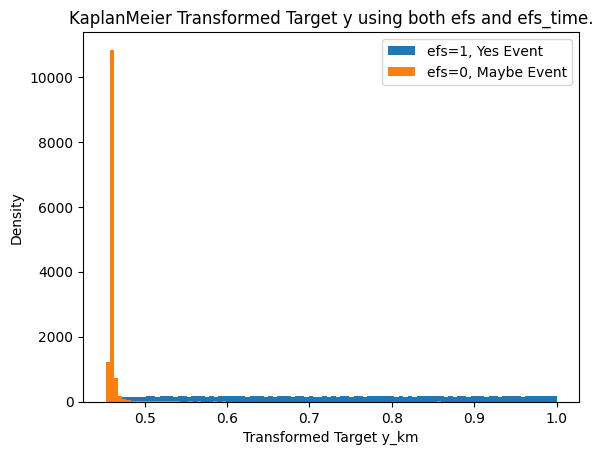

In [657]:
# Transform Two Targets into One Target with KaplanMeier
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y_km"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y_km"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_km"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_km")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}/kaplanmeier_transformed_target_y.png')
plt.show()

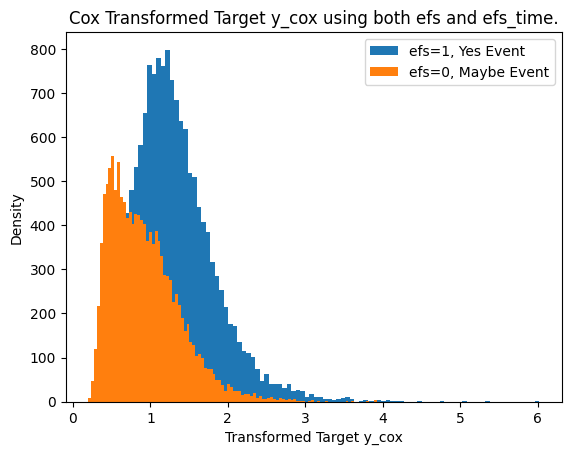

In [658]:
# Cox fitter
def transform_survival_probability(df):
    df = df.copy()
    df['efs_time'] = pd.to_numeric(df['efs_time'], errors='coerce')
    df['efs'] = pd.to_numeric(df['efs'], errors='coerce')
    required_cols = ['efs_time', 'efs'] + CATS
    df = df.dropna(subset=['efs_time', 'efs'])
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(df[required_cols], duration_col='efs_time', event_col='efs')
    y = cph.predict_partial_hazard(df)
    return y
train["y_cox"] = transform_survival_probability(train)

plt.hist(train.loc[train.efs==1,"y_cox"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_cox"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_cox")
plt.ylabel("Density")
plt.title("Cox Transformed Target y_cox using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}/cox_transformed_target_y.png')
plt.show()

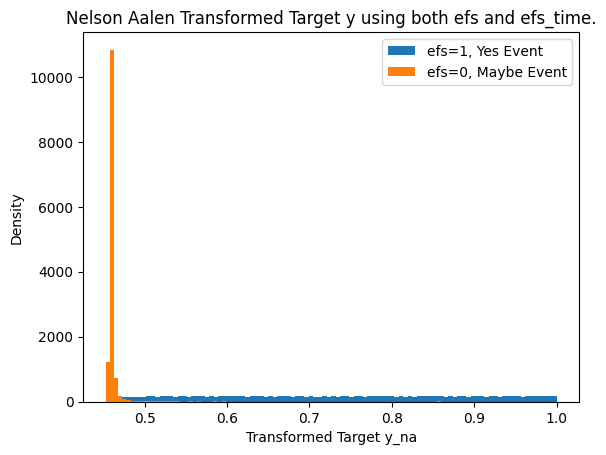

In [659]:
# NelsonAalenFitter
def transform_survival_probability(df):
    naf = NelsonAalenFitter()
    naf.fit(durations=df['efs_time'], event_observed=df['efs'])
    y = naf.cumulative_hazard_at_times(df['efs_time']).values
    y = y * -1
    return y
train["y_na"] = transform_survival_probability(train)

plt.hist(train.loc[train.efs==1,"y_km"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_km"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_na")
plt.ylabel("Density")
plt.title("Nelson Aalen Transformed Target y using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}/nelsonaalen_transformed_target_y.png')
plt.show()

In [660]:
def recode_dri_score(df):
    # Create a copy to avoid modifying original
    df = df.copy()
    
    # Create binary feature for strong predictor
    df['dri_score_is_2'] = (df['dri_score'] == 2).astype(int)
    
    # Group rare categories
    conditions = [
        (df['dri_score'].isin([11, 8, 10])),  # Rare categories
        (df['dri_score'].isin([5, 6, 0])),    # Strong negative correlation group
        (df['dri_score'] == 2),               # Strong positive correlation
        (df['dri_score'] == 1)                # Large group with moderate correlation
    ]
    choices = ['rare', 'high_risk', 'optimal', 'baseline']
    
    df['dri_score_grouped'] = np.select(conditions, choices, default='other')
    df['dri_score_grouped'] = (df['dri_score_grouped']).astype('category')

    # graft and dri_score 2 interaction using the highly correlated value of '1'
    df['graft_dri_score_is_2'] = (df['graft_type'] == 1).astype(int) + df['dri_score_is_2']

    # graft interaction with dri weighted risk score
    df['graft_risk_interaction'] = (df['graft_type'] == 1).astype(int) * df['risk_score_dri_weighted']
    
    return df

train = recode_dri_score(train)
test = recode_dri_score(test)

In [661]:
train['graft_risk_interaction']

0        0.0000
1        0.3750
2        0.0000
3        0.0000
4        0.3125
          ...  
28795    0.3125
28796    0.4375
28797    0.3750
28798    0.1250
28799    0.0000
Name: graft_risk_interaction, Length: 28800, dtype: float64

In [662]:
train['dri_score_grouped']

0        high_risk
1         baseline
2        high_risk
3          optimal
4          optimal
           ...    
28795        other
28796      optimal
28797    high_risk
28798    high_risk
28799    high_risk
Name: dri_score_grouped, Length: 28800, dtype: category
Categories (5, object): ['baseline', 'high_risk', 'optimal', 'other', 'rare']

In [663]:
def recode_conditioning_intensity(df):
    df = df.copy()
    
    # Create main groups based on correlation patterns
    conditions = [
        (df['conditioning_intensity'] == 0),  # Strong negative
        (df['conditioning_intensity'] == 2),  # Strong positive
        (df['conditioning_intensity'].isin([3, 4])),  # Moderate positive
        (df['conditioning_intensity'].isin([5, 6])),  # Weak effects
        (df['conditioning_intensity'] == 1)   # Mixed effects
    ]
    
    choices = [
        'low_intensity',
        'optimal_intensity',
        'moderate_intensity',
        'high_intensity',
        'other'
    ]
    
    df['conditioning_group'] = pd.Categorical(np.select(conditions, choices, default='other'),
                            categories=['low_intensity',
                                        'optimal_intensity',
                                        'moderate_intensity',
                                        'high_intensity',
                                        'other'],
                            ordered=True
    )
    
    # Create binary flag for optimal intensity
    df['optimal_conditioning'] = (df['conditioning_intensity'] == 2).astype(int)
    
    return df

train = recode_conditioning_intensity(train)
test = recode_conditioning_intensity(test)

In [664]:
train['dri_disease_status']

0         0
1         1
2         0
3         2
4         2
         ..
28795    13
28796     2
28797    12
28798     0
28799     9
Name: dri_disease_status, Length: 28800, dtype: category
Categories (83, int8): [0, 1, 2, 3, ..., 79, 80, 81, 82]

In [665]:
def recode_dri_disease_status(df):
    df = df.copy()
    
    # Define our groups explicitly
    optimal_status = [2]  # Strong positive correlations
    favorable_status = [17, 3]  # Moderate positive correlations
    high_risk_status = [9, 12, 0]  # Strong negative correlations
    common_status = [6]  # Most frequent category
    rare_status = list(range(70, 83))  # High numbered rare categories
    
    # Create groups based on correlation patterns and frequency
    conditions = [
        (df['dri_disease_status'].isin(optimal_status)),
        (df['dri_disease_status'].isin(favorable_status)),
        (df['dri_disease_status'].isin(high_risk_status)),
        (df['dri_disease_status'].isin(common_status)),
        (df['dri_disease_status'].isin(rare_status))
    ]
    
    choices = [
        'optimal_status',
        'favorable_status',
        'high_risk_status',
        'common_status',
        'rare_status'
    ]
    
    # Create grouped variable
    df['disease_status_group'] = pd.Categorical(np.select(conditions, choices, default='other'),
                            categories=['optimal_status',
                                        'favorable_status',
                                        'high_risk_status',
                                        'common_status',
                                        'rare_status', 
                                        'other'],
                            ordered=True
    )
    
    
    # Create binary flag for optimal status
    df['optimal_disease_status'] = df['dri_disease_status'].isin(optimal_status).astype(int)
    
    # Create risk score based on correlations
    risk_weights = {
        2: 1.0,    # Strong positive
        17: 0.5,   # Moderate positive
        3: 0.5,    # Moderate positive
        9: -0.7,   # Strong negative
        12: -0.5,  # Moderate negative
        0: -0.5    # Moderate negative
    }
    
    df['disease_status_risk_score'] = df['dri_disease_status'].map(risk_weights).fillna(0)
    
    return df

train = recode_dri_disease_status(train)
test = recode_dri_disease_status(test)

In [666]:
train['disease_status_group']

0        high_risk_status
1                   other
2        high_risk_status
3          optimal_status
4          optimal_status
               ...       
28795               other
28796      optimal_status
28797    high_risk_status
28798    high_risk_status
28799    high_risk_status
Name: disease_status_group, Length: 28800, dtype: category
Categories (6, object): ['optimal_status' < 'favorable_status' < 'high_risk_status' < 'common_status' < 'rare_status' < 'other']

In [667]:
train['age_bin_high_risk']

0         0
1         1
2         2
3         3
4         4
         ..
28795    16
28796    25
28797    16
28798    14
28799    14
Name: age_bin_high_risk, Length: 28800, dtype: category
Categories (30, int8): [0, 1, 2, 3, ..., 26, 27, 28, 29]

In [668]:
def recode_age_bin_high_risk(df):
    df = df.copy()
    
    # Define groups based on correlation patterns
    strong_negative = [14]  # Very strong negative (-0.355)
    strong_positive = [23, 20, 19]  # Strong positive (>0.15)
    moderate_positive = [17, 11, 12, 13]  # Moderate positive (0.09-0.15)
    moderate_negative = [0, 18, 6]  # Moderate negative (-0.11 to -0.17)
    weak_effect = [1, 7, 22, 28]  # Very weak correlations (<|0.02|)
    
    # Create groups
    conditions = [
        (df['age_bin_high_risk'].isin(strong_negative)),
        (df['age_bin_high_risk'].isin(strong_positive)),
        (df['age_bin_high_risk'].isin(moderate_positive)),
        (df['age_bin_high_risk'].isin(moderate_negative)),
        (df['age_bin_high_risk'].isin(weak_effect))
    ]
    
    choices = [
        'high_risk',
        'favorable',
        'moderate_favorable',
        'moderate_risk',
        'neutral'
    ]
    
    # Create grouped variable
    df['age_risk_group'] = pd.Categorical(
                            np.select(conditions, choices, default='other'),
                            categories=['high_risk', 
                                        'favorable', 
                                        'moderate_favorable', 
                                        'moderate_risk', 
                                        'neutral', 
                                        'other'],
                            ordered=True
    )
    
    # Create risk score based on correlation strengths
    risk_weights = {
        14: -0.355,  # Strong negative
        23: 0.189,   # Strong positive
        20: 0.186,   # Strong positive
        19: 0.154,   # Strong positive
        17: 0.134,   # Moderate positive
        11: 0.133,   # Moderate positive
        0: -0.165,   # Moderate negative
        18: -0.140,  # Moderate negative
        6: -0.115    # Moderate negative
    }
    
    # Create risk score
    df['age_bin_risk_score'] = df['age_bin_high_risk'].map(risk_weights).fillna(0)
    
    # Create binary flags for strongest predictors
    df['age_bin_high_risk_flag'] = df['age_bin_high_risk'].isin(strong_negative).astype(int)
    df['age_bin_favorable_flag'] = df['age_bin_high_risk'].isin(strong_positive).astype(int)
    
    return df

train = recode_age_bin_high_risk(train)
test = recode_age_bin_high_risk(test)

In [669]:
train['age_bin_high_risk_flag']

0        0
1        0
2        0
3        0
4        0
        ..
28795    0
28796    0
28797    0
28798    1
28799    1
Name: age_bin_high_risk_flag, Length: 28800, dtype: int32

In [670]:
train['age_bin_favorable_flag']

0        0
1        0
2        0
3        0
4        0
        ..
28795    0
28796    0
28797    0
28798    0
28799    0
Name: age_bin_favorable_flag, Length: 28800, dtype: int32

In [671]:
# advanced imputation of columns with significant missing values
def advanced_imputation(train_df, test_df):
    # Features to impute using KNN (continuous variables with correlations)
    knn_features = ['tce_match', 'tce_imm_match', 'tce_div_match', 
                    'cyto_score', 'cyto_score_detail', 'mrd_hct', 'hla_match_c_high']
    
    # Features to impute using mode (categorical variables)
    mode_features = ['hla_match_drb1_high', 'hla_match_drb1_low',
                    'hla_match_dqb1_high', 'hla_match_dqb1_low',
                    'hla_high_res_6', 'hla_high_res_8', 'hla_high_res_10',
                    'hla_low_res_6', 'hla_low_res_8', 'hla_low_res_10']
    
    # Create copies to avoid modifying original
    train = train_df.copy()
    test = test_df.copy()
    
    # KNN Imputation for continuous variables
    scaler = StandardScaler()
    knn_imp = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    
    # Scale features for KNN imputation
    train_scaled = scaler.fit_transform(train[knn_features])
    test_scaled = scaler.transform(test[knn_features])
    
    # Perform KNN imputation
    train_imp = knn_imp.fit_transform(train_scaled)
    test_imp = knn_imp.transform(test_scaled)
    
    # Inverse transform to original scale
    train[knn_features] = scaler.inverse_transform(train_imp)
    test[knn_features] = scaler.inverse_transform(test_imp)
    
    # Mode imputation for categorical variables
    mode_imp = SimpleImputer(strategy='most_frequent')
    
    train[mode_features] = mode_imp.fit_transform(train[mode_features])
    test[mode_features] = mode_imp.transform(test[mode_features])
    
    return train, test

# Usage
train_imputed, test_imputed = advanced_imputation(train, test)

In [672]:
train = train_imputed
test = test_imputed

In [673]:
# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [674]:
# correlation matrix after feature engineering
#def plot_correlation_matrix(df, output_path):
#    df_copy = df.copy()   
#
#    numerical_cols = df_copy.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
#    
#    if len(numerical_cols) > 1:
#        plt.figure(figsize=(90, 90))
#        correlation_matrix = df_copy[numerical_cols].corr()
#        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
#        plt.title('Correlation Matrix After Feature Engineering')
#        plt.tight_layout()
#        plt.savefig(f'{output_path}/correlation_matrix_feature_engineering.png')
#        plt.show()
#        plt.close()

#plot_correlation_matrix(train, output_path)

In [675]:
def check_variances(df, percentile_threshold=20, relative_threshold=0.0001):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    # Calculate variances
    raw_variances = df[numerical_cols].var()
    
    print("\n1. Percentile-based check ({}th percentile):".format(percentile_threshold))
    percentile_value = np.percentile(raw_variances, percentile_threshold)
    percentile_low_var = raw_variances[raw_variances < percentile_value]
    print(percentile_low_var.sort_values())
    
    print("\n2. Relative variance check (threshold={}*max):".format(relative_threshold))
    relative_value = raw_variances.max() * relative_threshold
    relative_low_var = raw_variances[raw_variances < relative_value]
    print(relative_low_var.sort_values())
    
    # Print all variances sorted
    print("\nAll features sorted by variance (lowest to highest):")
    print(raw_variances.sort_values())

check_variances(train)


1. Percentile-based check (20th percentile):
hla_high_low_ratio         0.008130
hla_ratio_res_highlow      0.008130
no_prophylaxis             0.009015
hla_ratio_res_lowhigh      0.009497
drb1_dqb1_ratio            0.015378
age_bin_risk_score         0.017339
is_experimental            0.018733
clinical_status_score      0.023544
dri_quantile               0.025591
risk_score_dri_weighted    0.026363
y_km                       0.031228
risk_score_equal           0.034106
disease_control_factor     0.034148
graft_risk_interaction     0.038231
is_depletion_based         0.045936
high_risk_combination      0.055086
age_bin_favorable_flag     0.063936
karnofsky_below_70         0.072375
y_na                       0.074009
comorbidity_quantile       0.076399
has_CSA                    0.086062
age_bin_high_risk_flag     0.086512
drb1_dqb1_diff             0.095644
optimal_disease_status     0.096737
age_quantile               0.125007
has_MTX                    0.132079
dri_score_is_2    

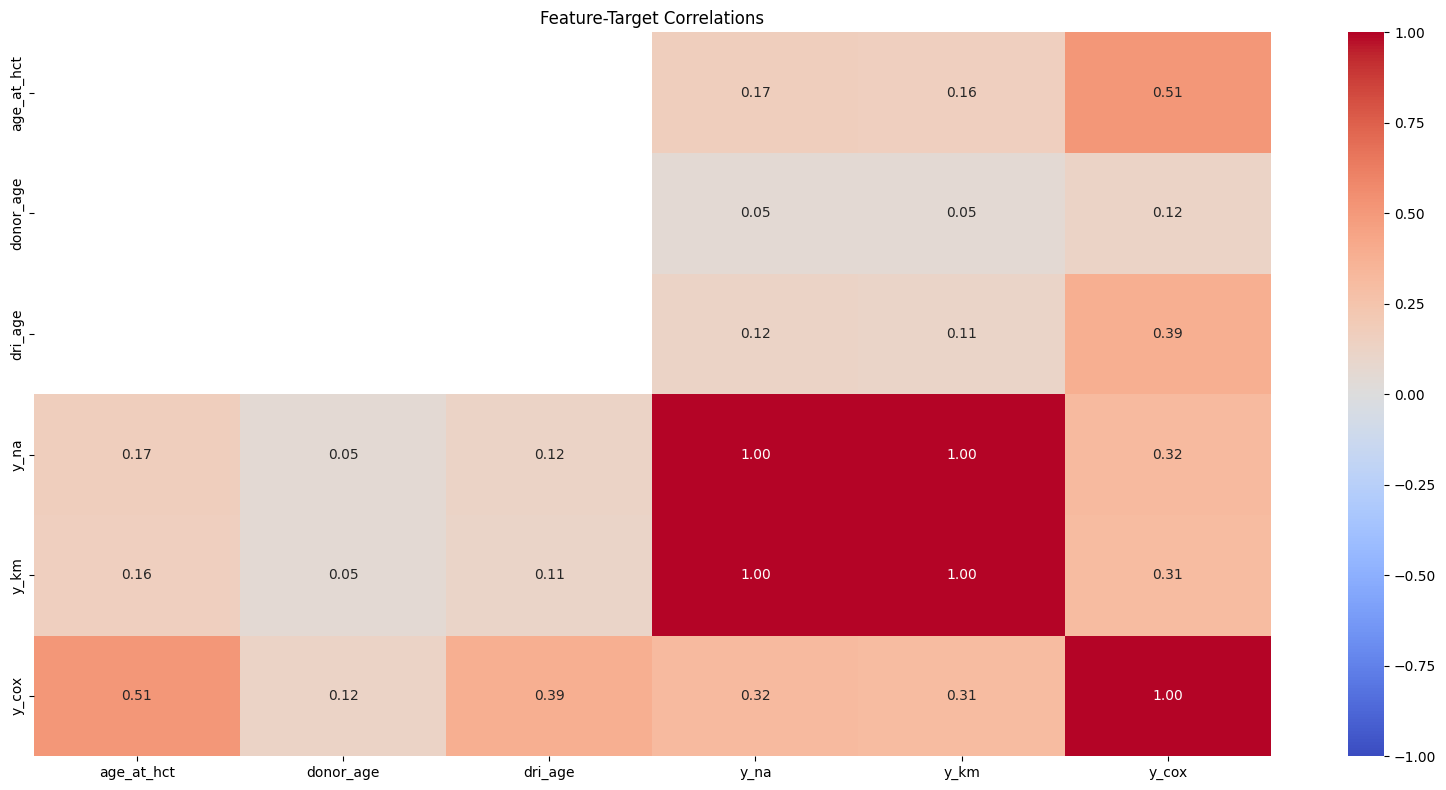


Correlations with targets (sorted):

y_na correlations:
y_km          0.995883
y_cox         0.318853
age_at_hct    0.170857
dri_age       0.121123
donor_age     0.049060
Name: y_na, dtype: float64

y_km correlations:
y_na          0.995883
y_cox         0.309839
age_at_hct    0.158315
dri_age       0.111879
donor_age     0.050840
Name: y_km, dtype: float64

y_cox correlations:
age_at_hct    0.510542
dri_age       0.388190
y_na          0.318853
y_km          0.309839
donor_age     0.122561
Name: y_cox, dtype: float64


In [676]:
def plot_correlation_matrix(df, output_path):
    df_copy = df.copy()   
    
    # Features to potentially remove - add features to test
    low_variance_features = [
                    
                    
                    
                  
                   
                    
                   
                            ]

    # list of features to remove based on this analysis. This isn't used anywhere except to track which
    # features to remove based on variance and correlation
    features_to_remove = [
                        'hepatic_severe', 
                        'peptic_ulcer', 
                        'gvhd_proph',
                        'rheum_issue', 
                        'hla_high_low_ratio', 
                        'hla_ratio_res_highlow',
                        'no_prophylaxis',
                        'hla_ratio_res_lowhigh',
                        'has_MTX',
                        'dri_karnofsky',
                        'karnofsky_score',
                        'has_CSA',
                        'is_depletion_based',
                        'is_experimental',
                        'depletion_risk_interaction',
                        'hla_match_dqb1_mean',                         
                        'hla_match_dqb1_low',                       
                        'hla_match_dqb1_high',                        
                        'hla_match_c_low',                             
                        'hla_match_drb1_low',                          
                        'hla_min',                                      
                        'hla_match_drb1_high',                         
                        'hla_match_b_low',                                                     
                        'hla_match_a_low',                            
                        'hla_match_a_high',                             
                        'hla_match_b_high',
                        'sex_donor', 
                        'sex_recipient', 
                        'primary_agent',
                        'vivo_age_bin',
                        'vivo_prim_disease',
                        'dri_disease_status',
                        'transplant_era',
                        'age_bin_high_risk_flag',
                        'age_bin_to_donor_age_bin',
                        'pre_post_2015',
                        'hla_match_c_high',
                        'depletion_comorbidity_interaction',
                        'high_low_diff',                                
                        'hla_std',
                        'tce_div_match',                 
                        'tce_match',                          
                        'hla_mean',
                        'hla_high_res_6',                         
                        'hla_low_res_6',
                        'hla_nmdp_6',                                   
                        'hla_high_res_8',                             
                        'hla_low_res_8',                               
                        'hla_low_res_mean',                          
                        'hla_high_res_mean',
                        'tce_imm_match',                            
                        'hla_high_res_10',                            
                        'hla_low_res_10',
                        'years_since_2008',                            
                        'year_hct',
                        'comorbidity_score_by_age_at_hct',             
                        'comorbidity_age',                                                        
                        'depletion_age_interaction',
                        'compatibility_score_squared',
                        'donor_by_age_at_hct',
                        'karnofsky_score_x_compatibility_score',
                        'karnofsky_hla_interaction',
                        'karnofsky_score_x_donor_age',
                        'karnofsky_score_squared',
                        'karnofsky_weighted_performance',
                        'karnofsky_standardized',
                        'has_cyclophosphamide',
                        'immune_burden',
                        'vent_hist',
                        'compatibility_score',
                        'hla_mismatch_score',
                        'is_monotherapy',
                        'karnofsky_above_80',
                        'karnofsky_deviation',
                        'sex_match',
                        'donor_related', 
                        'melphalan_dose', 
                        'age_bin_race',
                        'graft_prod',
                        'graft_prim_disease',
                        'age_bin_dri',
                        'renal_issue', 
                        'prim_disease_hct', 
                        'cmv_status',
                        'rituximab',
                        'ethnicity',
                        'compatibility_treatment_intensity_fn',
                        'karnofsky_compatibility_fn',
                        'karnofsky_dri_comorbidity_fn',
                        'karnofsky_dri_fn',
                        'karnofsky_treatment_intensity_fn',
                         ]

    # features tested and slated to keep
    features_to_keep = ['drb1_dqb1_ratio',
                        'disease_control_factor',
                        'is_high_risk',
                        'high_risk_combination',
                        'dri_age_squared',
                        'dri_quantile',
                        'risk_score_dri_weighted',
                        'drb1_dqb1_diff',
                        'age_quantile',
                        'risk_score_dri_weighted',
                        'risk_score_equal',
                        'comorbidity_quantile',
                        'has_combination',
                        'hla_match_drb1_mean', #cox only
                        'drb1_dqb1_diff',
                        'has_MMF', #cox high
                        'is_complex', #cox high
                        'has_FK', #cox high
                        'FK_MMF_interaction', #cox high
                        'is_standard_approach', #cox high
                        'is_standard_risk', #cox only, negative for others
                        'condition_severity',
                        'multiple_conditions',
                        'weighted_risk_score',
                        'mrd_hct', #cox only
                        'n_agents', #cox high
                        'dri_numeric',                              
                        'treatment_intensity',
                        'cyto_score_detail',
                        'cyto_score',
                        'hla_max',                                   
                        'hla_match_weighted',                          
                        'comorbidity_score',                            
                        'risk_depletion_category',                     
                        'combined_risk_score',
                        'dri_numeric_x_treatment_intensity',
                        'dri_numeric_squared',                         
                        'treatment_intensity_squared',                
                        'comorbidity_score_x_treatment_intensity',     
                        'comorbidity_score_x_dri_numeric',             
                        'dri_comorbidity',
                        'dqb1_low_interaction',  # cox only                     
                        'drb1_high_interaction', #cox only
                        'treatment_intensity_x_dri_comorbidity',       
                        'dri_numeric_x_compatibility_score',          
                        'compatibility_score_x_treatment_intensity',   
                        'dri_numeric_x_dri_comorbidity',                
                        'comorbidity_score_squared',
                        'comorbidity_score_x_compatibility_score',
                        'comorbidity_score_x_dri_comorbidity',                 
                        'compatibility_score_x_dri_comorbidity',       
                        'donor_age_x_dri_numeric',                   
                        'donor_age_x_treatment_intensity',             
                        'age_at_hct_x_treatment_intensity',          
                        'age_at_hct_x_dri_numeric',                    
                        'dri_comorbidity_squared',
                        'karnofsky_score_x_dri_numeric',                
                        'comorbidity_score_x_donor_age',             
                        'karnofsky_score_x_treatment_intensity',       
                        'age_comorbidity_interaction',
                        'age_at_hct_x_comorbidity_score',            
                        'treatment_intensity_x_dri_age',              
                        'donor_age_x_compatibility_score',             
                        'comorbidity_score_x_karnofsky_score',        
                        'dri_numeric_x_dri_age',
                        'age_at_hct_x_compatibility_score',           
                        'donor_age_x_dri_comorbidity',               
                        'age_at_hct_x_dri_comorbidity',               
                        'comorbidity_score_x_dri_age',
                        'karnofsky_score_x_dri_comorbidity',           
                        'compatibility_score_x_dri_age',              
                        'dri_age_x_dri_comorbidity',
                        'age_at_hct_x_donor_age',                    
                        'donor_age_squared',
                        'age_at_hct_squared',                         
                        'age_at_hct_x_karnofsky_score',
                        'karnofsky_age_at_hct',                       
                        'donor_age_x_dri_age',                         
                        'age_at_hct_x_dri_age',                        
                        'karnofsky_score_x_dri_age',                                       
                        'dri_age_squared',
                        'clinical_status_score',
                        'karnofsky_age_at_hct',
                        'karnofsky_risk_adjusted',
                        'combined_risk_score',
                        'risk_depletion_category',
                        'risk_score_equal',
                        'risk_score_dri_weighted',
                        'dri_score',
                        'dri_score_is_2',
                        'graft_dri_score_is_2',
                        'graft_risk_interaction',
                        'graft_type',
                        'optimal_conditioning',
                        'conditioning_intensity',
                        'race_group',
                        'age_bin',
                        'graft_cmv_status',
                        'karnofsky_category',
                        'disease_status_risk_score',
                        'age_bin_ethnicity', 
                        'dri_ethnicity',
                        'ethnicity_vivo',
                        'age_bin_favorable_flag',
                        'age_bin_risk_score',
                        'optimal_disease_status',
                        'age_bin_high_risk',
                        'age_risk_group',
                        'age_depletion_risk', 
                        'graft_dri',
                        'dri_score_grouped', 
                        'conditioning_group', 
                        'disease_status_group',
                        'vivo_comorbidity',

                        'age_bin_race_high_risk',
                        'donor_age_bin', 
                        'donor_age_bin_related',
                        'hla_match_total',
                        'karnofsky_below_70',
                        'psych_disturb',
                        'diabetes',
                        'tbi_status',
                        'arrhythmia',
                        'hepatic_mild',
                        'cardiac',
                        'pulm_moderate',
                        'cyto_age',
                        'age_bin_pulm_severe',
                        'with_tbi',
                        'pulm_severe',
                        'prod_type',
                        'obesity',
                        'in_vivo_tcd',
                        'prior_tumor',
                        'dri_comorbidity_fn',
                      	'dri_num_comorbidity_fn',
                        'dri_num_compatibility_fn',
                        'compatibility_dri_age_fn',
                        'compatibility_dri_comorbidity_fn',
                        'comorbidity_compatibility_fn',
                        'comorbidity_dri_age_fn',
                        'comorbidity_dri_comorbidity_fn',
                        'comorbidity_dri_numeric_fn',
                        'comorbidity_karnofsky_fn',
                        'comorbidity_treatment_intensity_fn',
                        'age_comorbidity_fn',
                        'age_compatibility_fn',
                        'age_dri_age_fn',
                        'age_dri_fn',
                        'age_karnofsky_fn',
                        'age_treatment_intensity_fn',
                        'karnofsky_dri_age_fn',
                        'treatment_intensity_dri_age_fn',
                        'treatment_intensity_dri_comorbidity_fn'
                       ]
    
    # Important features to keep
    key_features = [
        'age_at_hct',
        'donor_age',
        'dri_age'
    ]
    
    # Target variables
    target_variables = ['y_na', 'y_km', 'y_cox']
    
    # Combine features and targets
    features_to_analyze = low_variance_features + key_features + target_variables
    
    if len(features_to_analyze) > 1:
        plt.figure(figsize=(16, 8))
        
        # Create correlation matrix
        correlation_matrix = df_copy[features_to_analyze].corr()
        
        # Create mask to highlight target correlations
        mask = np.zeros_like(correlation_matrix)
        mask[:-3, :-3] = True  # Mask everything except target correlations
        
        # Plot heatmap
        sns.heatmap(correlation_matrix, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   fmt='.2f',
                   mask=mask,
                   vmin=-1, 
                   vmax=1)
        
        plt.title('Feature-Target Correlations')
        plt.tight_layout()
        plt.savefig(f'{output_path}/target_correlation_matrix.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        # Print sorted correlations with targets
        print("\nCorrelations with targets (sorted):")
        for target in target_variables:
            print(f"\n{target} correlations:")
            target_corr = correlation_matrix[target].sort_values(ascending=False)
            print(target_corr[target_corr.index != target])  # Exclude self-correlation

    return features_to_keep, features_to_remove, key_features

features_to_keep, features_to_remove, key_features = plot_correlation_matrix(train, output_path)

In [677]:
def find_unchecked_features(df, features_to_keep, features_to_remove):
    # Get all columns from dataframe
    all_columns = set(df.columns)
    
    # Combine your checked features
    checked_features = set(features_to_keep + features_to_remove + key_features)
    
    # Find columns that haven't been checked
    unchecked_columns = all_columns - checked_features
    
    if unchecked_columns:
        print("\nUnchecked columns found:")
        print("------------------------")
        for col in sorted(unchecked_columns):
            print(f"{col} - dtype: {df[col].dtype}")
    else:
        print("\nAll columns have been checked!")
        
    return unchecked_columns

# Use the function
unchecked = find_unchecked_features(train, features_to_keep, features_to_remove)


Unchecked columns found:
------------------------
ID - dtype: int32
efs - dtype: float32
efs_time - dtype: float32
y_cox - dtype: float64
y_km - dtype: float64
y_na - dtype: float64


In [678]:
def check_type_relationship(df):
    # Check overlap
    print("Cross-tabulation of prod_type vs graft_type:")
    print(pd.crosstab(df['prod_type'], df['graft_type']))
    
    # Calculate correlation
    print("\nCorrelation between prod_type and graft_type:")
    print(df['prod_type'].corr(df['graft_type']))

check_type_relationship(train)

Cross-tabulation of prod_type vs graft_type:
graft_type     0      1
prod_type              
0           7544    875
1            710  19671

Correlation between prod_type and graft_type:
0.8662979928452026


In [679]:
def analyze_categorical_correlations(df, features_to_keep, features_to_remove, target_variables=['y_na', 'y_km', 'y_cox']):
    # Get all categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Remove any categorical columns that are already in keep or remove lists
    checked_features = set(features_to_keep + features_to_remove)
    unchecked_categorical = [col for col in categorical_cols if col not in checked_features]
    
    print("Analyzing these categorical columns:", unchecked_categorical)
    
    # Create dummy variables for each categorical feature
    correlations_by_feature = {}
    
    for cat_col in unchecked_categorical:
        print(f"\nAnalyzing {cat_col}")
        print(f"Unique values: {df[cat_col].nunique()}")
        print(f"Value distribution:\n{df[cat_col].value_counts()}\n")
        
        # Create dummy variables
        dummies = pd.get_dummies(df[cat_col], prefix=cat_col)
        
        # Calculate correlations with targets
        correlations = {}
        for target in target_variables:
            target_correlations = {}
            for dummy_col in dummies.columns:
                corr = dummies[dummy_col].corr(df[target])
                target_correlations[dummy_col] = corr
            correlations[target] = target_correlations
        
        correlations_by_feature[cat_col] = correlations
        
        # Print correlations in a readable format
        print(f"Correlations for {cat_col}:")
        for target, corrs in correlations.items():
            print(f"\n{target}:")
            # Sort correlations by absolute value
            sorted_corrs = sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)
            for dummy_col, corr in sorted_corrs:
                print(f"  {dummy_col}: {corr:.3f}")
        print("-" * 50)
    
    return correlations_by_feature

# Use the function
categorical_correlations = analyze_categorical_correlations(train, features_to_keep, features_to_remove)

Analyzing these categorical columns: []


Distribution of is_depletion_based:
is_depletion_based
0    0.951736
1    0.048264
Name: proportion, dtype: float64


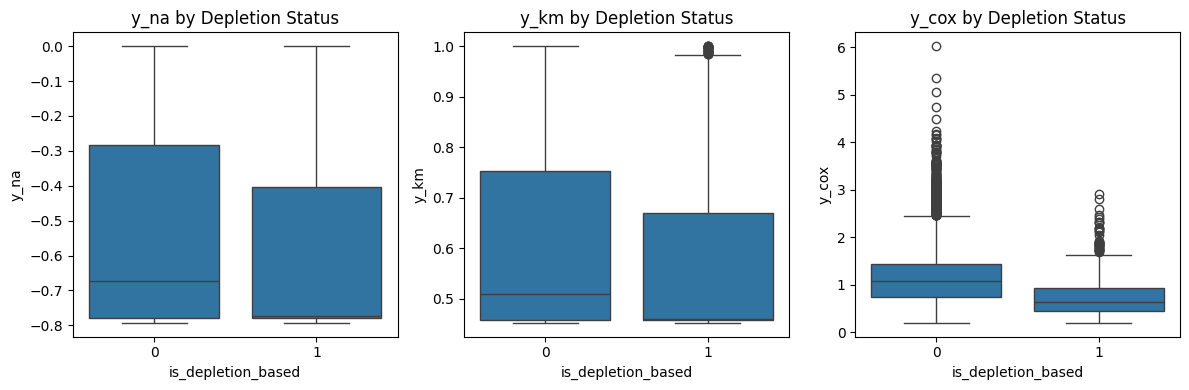


Mann-Whitney U test for y_na:
p-value: 0.0000
Mean for depletion group: -0.5991
Mean for non-depletion group: -0.5363

Mann-Whitney U test for y_km:
p-value: 0.0000
Mean for depletion group: 0.5712
Mean for non-depletion group: 0.6080

Mann-Whitney U test for y_cox:
p-value: 0.0000
Mean for depletion group: 0.7326
Mean for non-depletion group: 1.1374


In [680]:
def analyze_depletion_outcomes(df):
    # Basic distribution
    print("Distribution of is_depletion_based:")
    print(df['is_depletion_based'].value_counts(normalize=True))
    
    # Create boxplots for each outcome
    plt.figure(figsize=(12, 4))
    
    # Boxplots for each target variable
    targets = ['y_na', 'y_km', 'y_cox']
    for i, target in enumerate(targets, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x='is_depletion_based', y=target, data=df)
        plt.title(f'{target} by Depletion Status')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    for target in targets:
        depletion_group = df[df['is_depletion_based'] == 1][target]
        non_depletion_group = df[df['is_depletion_based'] == 0][target]
        
        # Perform Mann-Whitney U test
        stat, pval = stats.mannwhitneyu(depletion_group, non_depletion_group)
        print(f"\nMann-Whitney U test for {target}:")
        print(f"p-value: {pval:.4f}")
        
        # Calculate mean values for each group
        print(f"Mean for depletion group: {depletion_group.mean():.4f}")
        print(f"Mean for non-depletion group: {non_depletion_group.mean():.4f}")

analyze_depletion_outcomes(train)

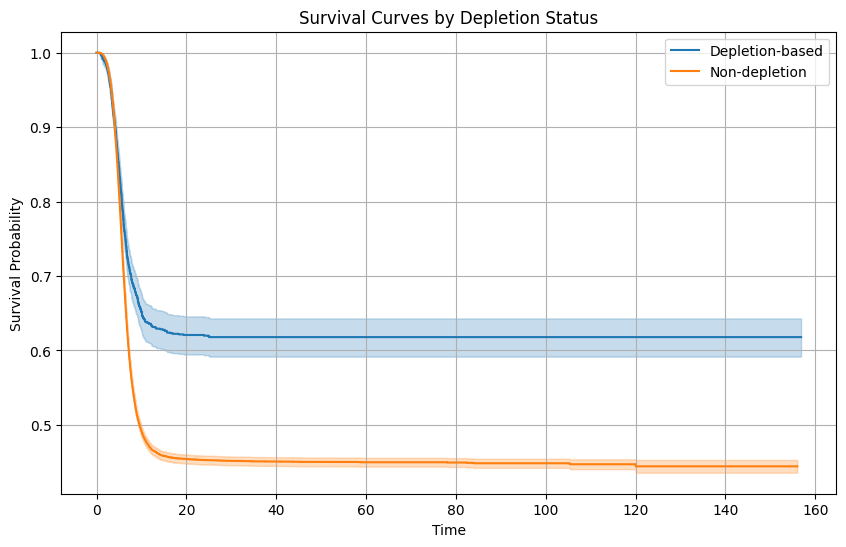

In [681]:
def plot_survival_curves(df):
    from lifelines import KaplanMeierFitter
    
    kmf = KaplanMeierFitter()
    
    plt.figure(figsize=(10, 6))
    
    # Plot for depletion group
    mask_depletion = df['is_depletion_based'] == 1
    kmf.fit(df[mask_depletion]['efs_time'], 
            df[mask_depletion]['efs'],
            label='Depletion-based')
    kmf.plot()
    
    # Plot for non-depletion group
    mask_non_depletion = df['is_depletion_based'] == 0
    kmf.fit(df[mask_non_depletion]['efs_time'],
            df[mask_non_depletion]['efs'],
            label='Non-depletion')
    kmf.plot()
    
    plt.title('Survival Curves by Depletion Status')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.savefig(f'{output_path}/is_depletion_based_survival_curve_km.png', bbox_inches='tight')
    plt.show()

# Run all analyses
plot_survival_curves(train)

1. Distribution Analysis:

age_at_hct:
Depletion group mean: 30.05
Non-depletion group mean: 39.10
p-value: 0.0000

karnofsky_score:
Depletion group mean: 80.24
Non-depletion group mean: 81.35
p-value: 0.0046

is_high_risk:
Depletion group mean: 0.11
Non-depletion group mean: 0.17
p-value: 0.0000

condition_severity:
Depletion group mean: 0.25
Non-depletion group mean: 0.31
p-value: 0.0000

comorbidity_score:
Depletion group mean: 1.46
Non-depletion group mean: 1.70
p-value: 0.0000

dri_numeric:
Depletion group mean: -0.14
Non-depletion group mean: 0.77
p-value: 0.0000

compatibility_score:
Depletion group mean: 7.55
Non-depletion group mean: 7.45
p-value: 0.6188


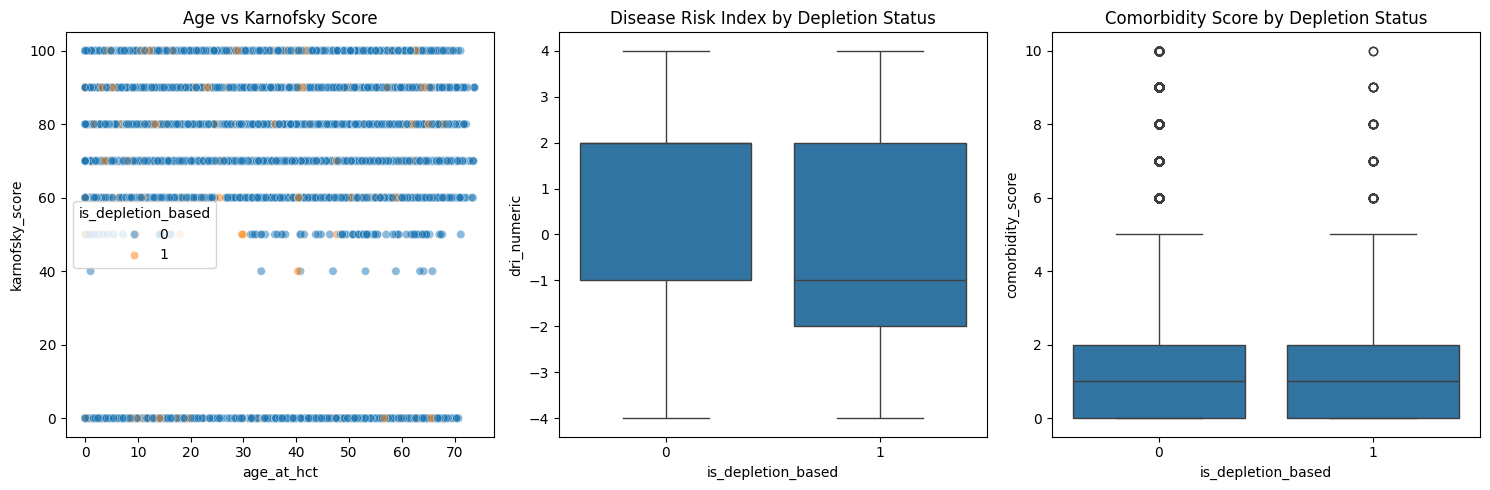

In [682]:
def analyze_selection_bias(df):
    # Key clinical characteristics that might influence treatment selection
    clinical_vars = [
        'age_at_hct', 
        'karnofsky_score',
        'is_high_risk',
        'condition_severity',
        'comorbidity_score',
        'dri_numeric',  # Disease Risk Index
        'compatibility_score'
    ]
    
    print("1. Distribution Analysis:")
    for var in clinical_vars:
        # Compare means between groups
        depletion = df[df['is_depletion_based'] == 1][var]
        non_depletion = df[df['is_depletion_based'] == 0][var]
        
        print(f"\n{var}:")
        print(f"Depletion group mean: {depletion.mean():.2f}")
        print(f"Non-depletion group mean: {non_depletion.mean():.2f}")
        
        # Statistical test
        stat, pval = stats.mannwhitneyu(depletion, non_depletion)
        print(f"p-value: {pval:.4f}")
    
    # Visualize key relationships
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Age vs Karnofsky by depletion status
    plt.subplot(131)
    sns.scatterplot(data=df, x='age_at_hct', y='karnofsky_score', 
                    hue='is_depletion_based', alpha=0.5)
    plt.title('Age vs Karnofsky Score')
    
    # Plot 2: Risk factors
    plt.subplot(132)
    sns.boxplot(data=df, x='is_depletion_based', y='dri_numeric')
    plt.title('Disease Risk Index by Depletion Status')
    
    # Plot 3: Comorbidity distribution
    plt.subplot(133)
    sns.boxplot(data=df, x='is_depletion_based', y='comorbidity_score')
    plt.title('Comorbidity Score by Depletion Status')
    
    plt.tight_layout()
    plt.savefig(f'{output_path}/is_depletion_based_selection_bias.png', bbox_inches='tight')
    plt.show()

analyze_selection_bias(train)

In [683]:
SEED = 9365

def perform_pca(train, test, n_components=None, random_state=42):
    # Remove rows with NaN values from both datasets
    train = train.dropna()
    test = test.dropna()

    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [684]:
train_num = train.drop('ID', axis=1)
test_num = test.drop('ID', axis=1)

In [685]:
train_num.head()

dri_score psych_disturb  cyto_score diabetes  hla_match_c_high  \
0         0             0         0.0        0               1.0   
1         1             0         1.0        0               2.0   
2         0             0         0.0        0               2.0   
3         2             0         1.0        0               2.0   
4         2             0         0.0        0               2.0   

   hla_high_res_8 tbi_status arrhythmia  hla_low_res_6 graft_type vent_hist  \
0             8.0          0          0            6.0          0         0   
1             8.0          1          0            6.0          1         0   
2             8.0          0          0            6.0          0         0   
3             8.0          0          0            6.0          0         0   
4             8.0          0          0            6.0          1         0   

  renal_issue pulm_severe prim_disease_hct  hla_high_res_6 cmv_status  \
0           0           0                0             6.0          0   
1           0           0                1             6.0          0   
2           0           0                2             6.0          0   
3           0           0                3             6.0          0   
4           0           0                4             6.0          0   

   hla_high_res_10  hla_match_dqb1_high  tce_imm_match  hla_nmdp_6  \
0             10.0                  2.0            0.0         6.0   
1             10.0                  2.0            1.0         6.0   
2             10.0                  2.0            1.0         6.0   
3             10.0                  2.0            1.0         6.0   
4             10.0                  2.0            0.0         5.0   

   hla_match_c_low rituximab  hla_match_drb1_low  hla_match_dqb1_low  \
0              2.0         0                 2.0                 2.0   
1              2.0         0                 2.0                 2.0   
2              2.0         0                 2.0                 2.0   
3              2.0         0                 2.0                 2.0   
4              2.0         0                 2.0                 2.0   

  prod_type  cyto_score_detail conditioning_intensity ethnicity  year_hct  \
0         0       1.110223e-16                      0         0      2016   
1         1       1.000000e+00                      1         0      2008   
2         0       1.110223e-16                      0         0      2019   
3         0       1.000000e+00                      1         0      2009   
4         1       1.110223e-16                      1         1      2018   

  obesity  mrd_hct in_vivo_tcd  tce_match  hla_match_a_high hepatic_severe  \
0       0      0.0           0        0.0               2.0              0   
1       0      1.0           1        1.0               2.0              0   
2       0      0.0           0        0.0               2.0              0   
3       0      1.0           1        1.0               2.0              0   
4       0      0.0           0        0.0               2.0              0   

   donor_age prior_tumor  hla_match_b_low peptic_ulcer  age_at_hct  \
0  40.063000           0              2.0            0    9.942000   
1  72.290001           0              2.0            0   43.705002   
2  40.063000           0              2.0            0   33.997002   
3  29.230000           0              2.0            0   43.244999   
4  56.810001           0              2.0            0   29.740000   

   hla_match_a_low gvhd_proph rheum_issue sex_match  hla_match_b_high  \
0              2.0          0           0         0               2.0   
1              2.0          1           0         1               2.0   
2              2.0          2           0         2               2.0   
3              2.0          3           0         3               2.0   
4              2.0          4           0         0               2.0   

  race_group  comorbidity_score  

In [686]:
RMV = ["ID","efs","efs_time","y_cox", "y_km", "y_na"]

# PCA 
# Extract the numerical columns to be used in the PCA
train_num = train.drop(RMV, axis=1)
test_num = test.drop('ID', axis=1)

# Get numeric and categorical columns
numeric_columns = train_num.select_dtypes(include=['int32', 'float32', 'int64', 'float64']).columns
categorical_columns = train_num.select_dtypes(exclude=['int32', 'float32', 'int64', 'float64']).columns

# Split into numeric and categorical dataframes
train_numeric = train_num[numeric_columns]
test_numeric = test_num[numeric_columns]
train_categorical = train[categorical_columns]
test_categorical = test[categorical_columns]

# Scale the numeric columns
scaler = StandardScaler()
train_scaled = pd.DataFrame(
    scaler.fit_transform(train_numeric),
    columns=train_numeric.columns
)
test_scaled = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns
)

#train_pca, test_pca, pca = perform_pca(train_scaled, test_scaled, n_components=15, random_state=SEED)

train_rmv = train[RMV]

# Merge scaled numeric data with categorical data
train_final = pd.concat([train_scaled, train_categorical, train_rmv], axis=1)
test_final = pd.concat([test_scaled, test_categorical], axis=1)

In [687]:
test = test_final
train = train_final

FEATURES = train.columns

In [688]:
print(sorted(list(train.columns)))

['FK_MMF_interaction', 'ID', 'age_at_hct', 'age_at_hct_squared', 'age_at_hct_x_comorbidity_score', 'age_at_hct_x_compatibility_score', 'age_at_hct_x_donor_age', 'age_at_hct_x_dri_age', 'age_at_hct_x_dri_comorbidity', 'age_at_hct_x_dri_numeric', 'age_at_hct_x_karnofsky_score', 'age_at_hct_x_treatment_intensity', 'age_bin', 'age_bin_dri', 'age_bin_ethnicity', 'age_bin_favorable_flag', 'age_bin_high_risk', 'age_bin_high_risk_flag', 'age_bin_pulm_severe', 'age_bin_race', 'age_bin_race_high_risk', 'age_bin_risk_score', 'age_bin_to_donor_age_bin', 'age_comorbidity_fn', 'age_comorbidity_interaction', 'age_compatibility_fn', 'age_depletion_risk', 'age_dri_age_fn', 'age_dri_fn', 'age_karnofsky_fn', 'age_quantile', 'age_risk_group', 'age_treatment_intensity_fn', 'arrhythmia', 'cardiac', 'clinical_status_score', 'cmv_status', 'combined_risk_score', 'comorbidity_age', 'comorbidity_compatibility_fn', 'comorbidity_dri_age_fn', 'comorbidity_dri_comorbidity_fn', 'comorbidity_dri_numeric_fn', 'comorbid

In [689]:
train.dtypes

cyto_score                                    float64
hla_match_c_high                              float64
hla_high_res_8                                float64
hla_low_res_6                                 float64
hla_high_res_6                                float64
hla_high_res_10                               float64
hla_match_dqb1_high                           float64
tce_imm_match                                 float64
hla_nmdp_6                                    float64
hla_match_c_low                               float64
hla_match_drb1_low                            float64
hla_match_dqb1_low                            float64
cyto_score_detail                             float64
year_hct                                      float64
mrd_hct                                       float64
tce_match                                     float64
hla_match_a_high                              float64
donor_age                                     float64
hla_match_b_low             

In [690]:
# convert the recoded columns to proper encoded categories
new_cats = ['age_risk_group', 'dri_score_grouped', 'conditioning_group', 'disease_status_group']

for col in new_cats:
    # Ensure categories are coded as integers starting from 0
    train[col] = train[col].cat.codes
    test[col] = test[col].cat.codes
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [691]:
train.head()

cyto_score  hla_match_c_high  hla_high_res_8  hla_low_res_6  \
0   -1.064407         -1.264286        0.610215       0.649549   
1   -0.432138          0.632574        0.610215       0.649549   
2   -1.064407          0.632574        0.610215       0.649549   
3   -0.432138          0.632574        0.610215       0.649549   
4   -1.064407          0.632574        0.610215       0.649549   

   hla_high_res_6  hla_high_res_10  hla_match_dqb1_high  tce_imm_match  \
0        0.632478         0.591564             0.516213      -0.709659   
1        0.632478         0.591564             0.516213      -0.100945   
2        0.632478         0.591564             0.516213      -0.100945   
3        0.632478         0.591564             0.516213      -0.100945   
4        0.632478         0.591564             0.516213      -0.709659   

   hla_nmdp_6  hla_match_c_low  hla_match_drb1_low  hla_match_dqb1_low  \
0    0.697842         0.556195            0.590556            0.479824   
1    0.697842         0.556195            0.590556            0.479824   
2    0.697842         0.556195            0.590556            0.479824   
3    0.697842         0.556195            0.590556            0.479824   
4   -0.133265         0.556195            0.590556            0.479824   

   cyto_score_detail  year_hct   mrd_hct  tce_match  hla_match_a_high  \
0          -0.853533  0.260175 -0.802783  -0.561008          0.640967   
1           0.000890 -2.276400  0.337770   0.356744          0.640967   
2          -0.853533  1.211391 -0.802783  -0.561008          0.640967   
3           0.000890 -1.959328  0.337770   0.356744          0.640967   
4          -0.853533  0.894319 -0.802783  -0.561008          0.640967   

   donor_age  hla_match_b_low  age_at_hct  hla_match_a_low  hla_match_b_high  \
0  -0.155304         0.616327   -1.358153         0.634834          0.645742   
1   2.025641         0.616327    0.238416         0.634834          0.645742   
2  -0.155304         0.616327   -0.220651         0.634834          0.645742   
3  -0.888422         0.616327    0.216664         0.634834          0.645742   
4   0.978040         0.616327   -0.421955         0.634834          0.645742   

   comorbidity_score  karnofsky_score  tce_div_match  hla_low_res_8  \
0          -0.853950          0.48347      -0.926901       0.635255   
1           0.661315          0.48347       0.163794       0.635255   
2          -0.853950          0.48347       0.163794       0.635255   
3          -0.853950          0.48347       0.163794       0.635255   
4          -0.348862          0.48347       0.163794       0.635255   

   hla_match_drb1_high  hla_low_res_10  comorbidity_age  hla_high_res_mean  \
0             0.583426        0.617168        -0.114378          -0.496280   
1             0.583426        0.617168        -0.103769           0.779966   
2             0.583426        0.617168        -0.114378           0.779966   
3             0.583426        0.617168        -0.114378           0.779966   
4             0.583426        0.617168        -0.109181           0.779966   

   hla_low_res_mean  hla_ratio_res_highlow  hla_ratio_res_lowhigh  \
0          0.754625              -2.115820               2.666111   
1          0.754625               0.348877               0.059919   
2          0.754625               0.348877               0.059919   
3          0.754625               0.348877               0.059919   
4          0.754625               0.348877               0.059919   

   donor_by_age_at_hct  comorbidity_score_by_age_at_hct  hla_match_drb1_mean  \
0            -0.179007                        -0.114378             0.674261   
1            -0.192805                        -0.103769             0.674261   
2            -0.195568                        -0.114378             0.674261   
3            -0.198486                        -0.114378             0.674261   
4            -0.191317                        -0.109181             0.674261   

   h

# XGBoost with KaplanMeier

In [692]:
# XGBoost with KaplanMeier
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [693]:
# feature selection
FEATURES = [
    #'age_at_hct_squared',
    #'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    #'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    #'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    #'age_bin',
    'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    #'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    'arrhythmia',
    'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    #'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    #'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    'comorbidity_score',
    'comorbidity_score_squared',
    #'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    'comorbidity_score_x_dri_numeric',
    #'comorbidity_score_x_karnofsky_score',
    'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    'diabetes',
    'disease_control_factor',
    'disease_status_group',
    'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    #'donor_age_squared',
    #'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    #'donor_age_x_dri_comorbidity',
    #'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    #'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    'dri_age_squared',
    'dri_age_x_dri_comorbidity',
    'dri_comorbidity',
    'dri_comorbidity_squared',
    'dri_ethnicity',
    'dri_numeric',
    'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    'dri_numeric_x_dri_age',
    'dri_numeric_x_dri_comorbidity',
    'dri_numeric_x_treatment_intensity',
    'dri_quantile',
    'dri_score',
    'dri_score_grouped',
    #'dri_score_is_2',
    #'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    'graft_dri_score_is_2',
    'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    #'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  
    #'hla_match_drb1_mean',  # cox only
    #'hla_match_total',
    #'hla_match_weighted',
    #'hla_max',
    'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    #'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    #'karnofsky_risk_adjusted',
    'karnofsky_score_x_dri_age',
    #'karnofsky_score_x_dri_comorbidity',
    'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    'prod_type',
    #'psych_disturb',
    #'pulm_moderate',
    'pulm_severe',
    'race_group',
    'risk_depletion_category',
    'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    'treatment_intensity',
    'treatment_intensity_squared',
    'treatment_intensity_x_dri_age',
    'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    'with_tbi',
    # added functions
    'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    #'compatibility_dri_age_fn',
    #'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    #'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    #'age_karnofsky_fn',
    'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    'karnofsky_dri_comorbidity_fn',
    #add back features
    'karnofsky_score',
    'age_bin_dri',
    'year_hct',
    'prim_disease_hct',
    'sex_match',
    'age_bin_race'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [694]:
class XGBoostModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_xgb_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.8, 0.99),
            'n_estimators': trial.suggest_int('n_estimators', 1500, 1900),
            'learning_rate': trial.suggest_float('learning_rate', 0.009, 0.04, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
            'device': 'cuda',
            'eval_metric': 'rmse',
            'objective': 'reg:squarederror',
            'enable_categorical': True
        }
        
        model = XGBRegressor(**param)
        model.fit(
            train_data[features], train_data['y_km'],
            eval_set=[(valid_data[features], valid_data['y_km'])],
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, XGBRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_xgb: Predictions for test set
            - oof_xgb: Out-of-fold predictions for training set
            - xgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_xgb = np.zeros(len(train))
        pred_xgb = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'max_depth': 6,
                    'colsample_bytree': 0.5,
                    'subsample': 0.8,
                    'n_estimators': 2000,
                    'learning_rate': 0.01,
                    'min_child_weight': 80,
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]

            model_params = {
                **self.best_params,
                'device': 'cuda',
                'eval_metric': 'rmse',
                'objective': 'reg:squarederror',
                'enable_categorical': True
            }
            
            model = XGBRegressor(**model_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=500
            )
            
            if i == 0:
                best_model = model

            oof_xgb[valid_idx] = model.predict(x_valid)
            pred_xgb += model.predict(x_test)

        pred_xgb /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_xgb
        xgb_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {xgb_score}")
        
        return pred_xgb, oof_xgb, xgb_score, best_model

In [695]:
# Initialize the model
xgb_model = XGBoostModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_xgb, oof_xgb, xgb_score, model_xgb = xgb_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

Training fold 1/10
[0]	validation_0-rmse:0.17745
[500]	validation_0-rmse:0.15942
[1000]	validation_0-rmse:0.15861
[1500]	validation_0-rmse:0.15857
[1525]	validation_0-rmse:0.15855
Training fold 2/10
[0]	validation_0-rmse:0.17322
[500]	validation_0-rmse:0.15559
[1000]	validation_0-rmse:0.15553
[1500]	validation_0-rmse:0.15582
[1525]	validation_0-rmse:0.15584
Training fold 3/10
[0]	validation_0-rmse:0.17693
[500]	validation_0-rmse:0.15783
[1000]	validation_0-rmse:0.15715
[1500]	validation_0-rmse:0.15717
[1525]	validation_0-rmse:0.15717
Training fold 4/10
[0]	validation_0-rmse:0.17894
[500]	validation_0-rmse:0.15993
[1000]	validation_0-rmse:0.15902
[1500]	validation_0-rmse:0.15904
[1525]	validation_0-rmse:0.15904
Training fold 5/10
[0]	validation_0-rmse:0.17339
[500]	validation_0-rmse:0.15705
[1000]	validation_0-rmse:0.15635
[1500]	validation_0-rmse:0.15629
[1525]	validation_0-rmse:0.15633
Training fold 6/10
[0]	validation_0-rmse:0.17721
[500]	validation_0-rmse:0.15999
[1000]	validation_0

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


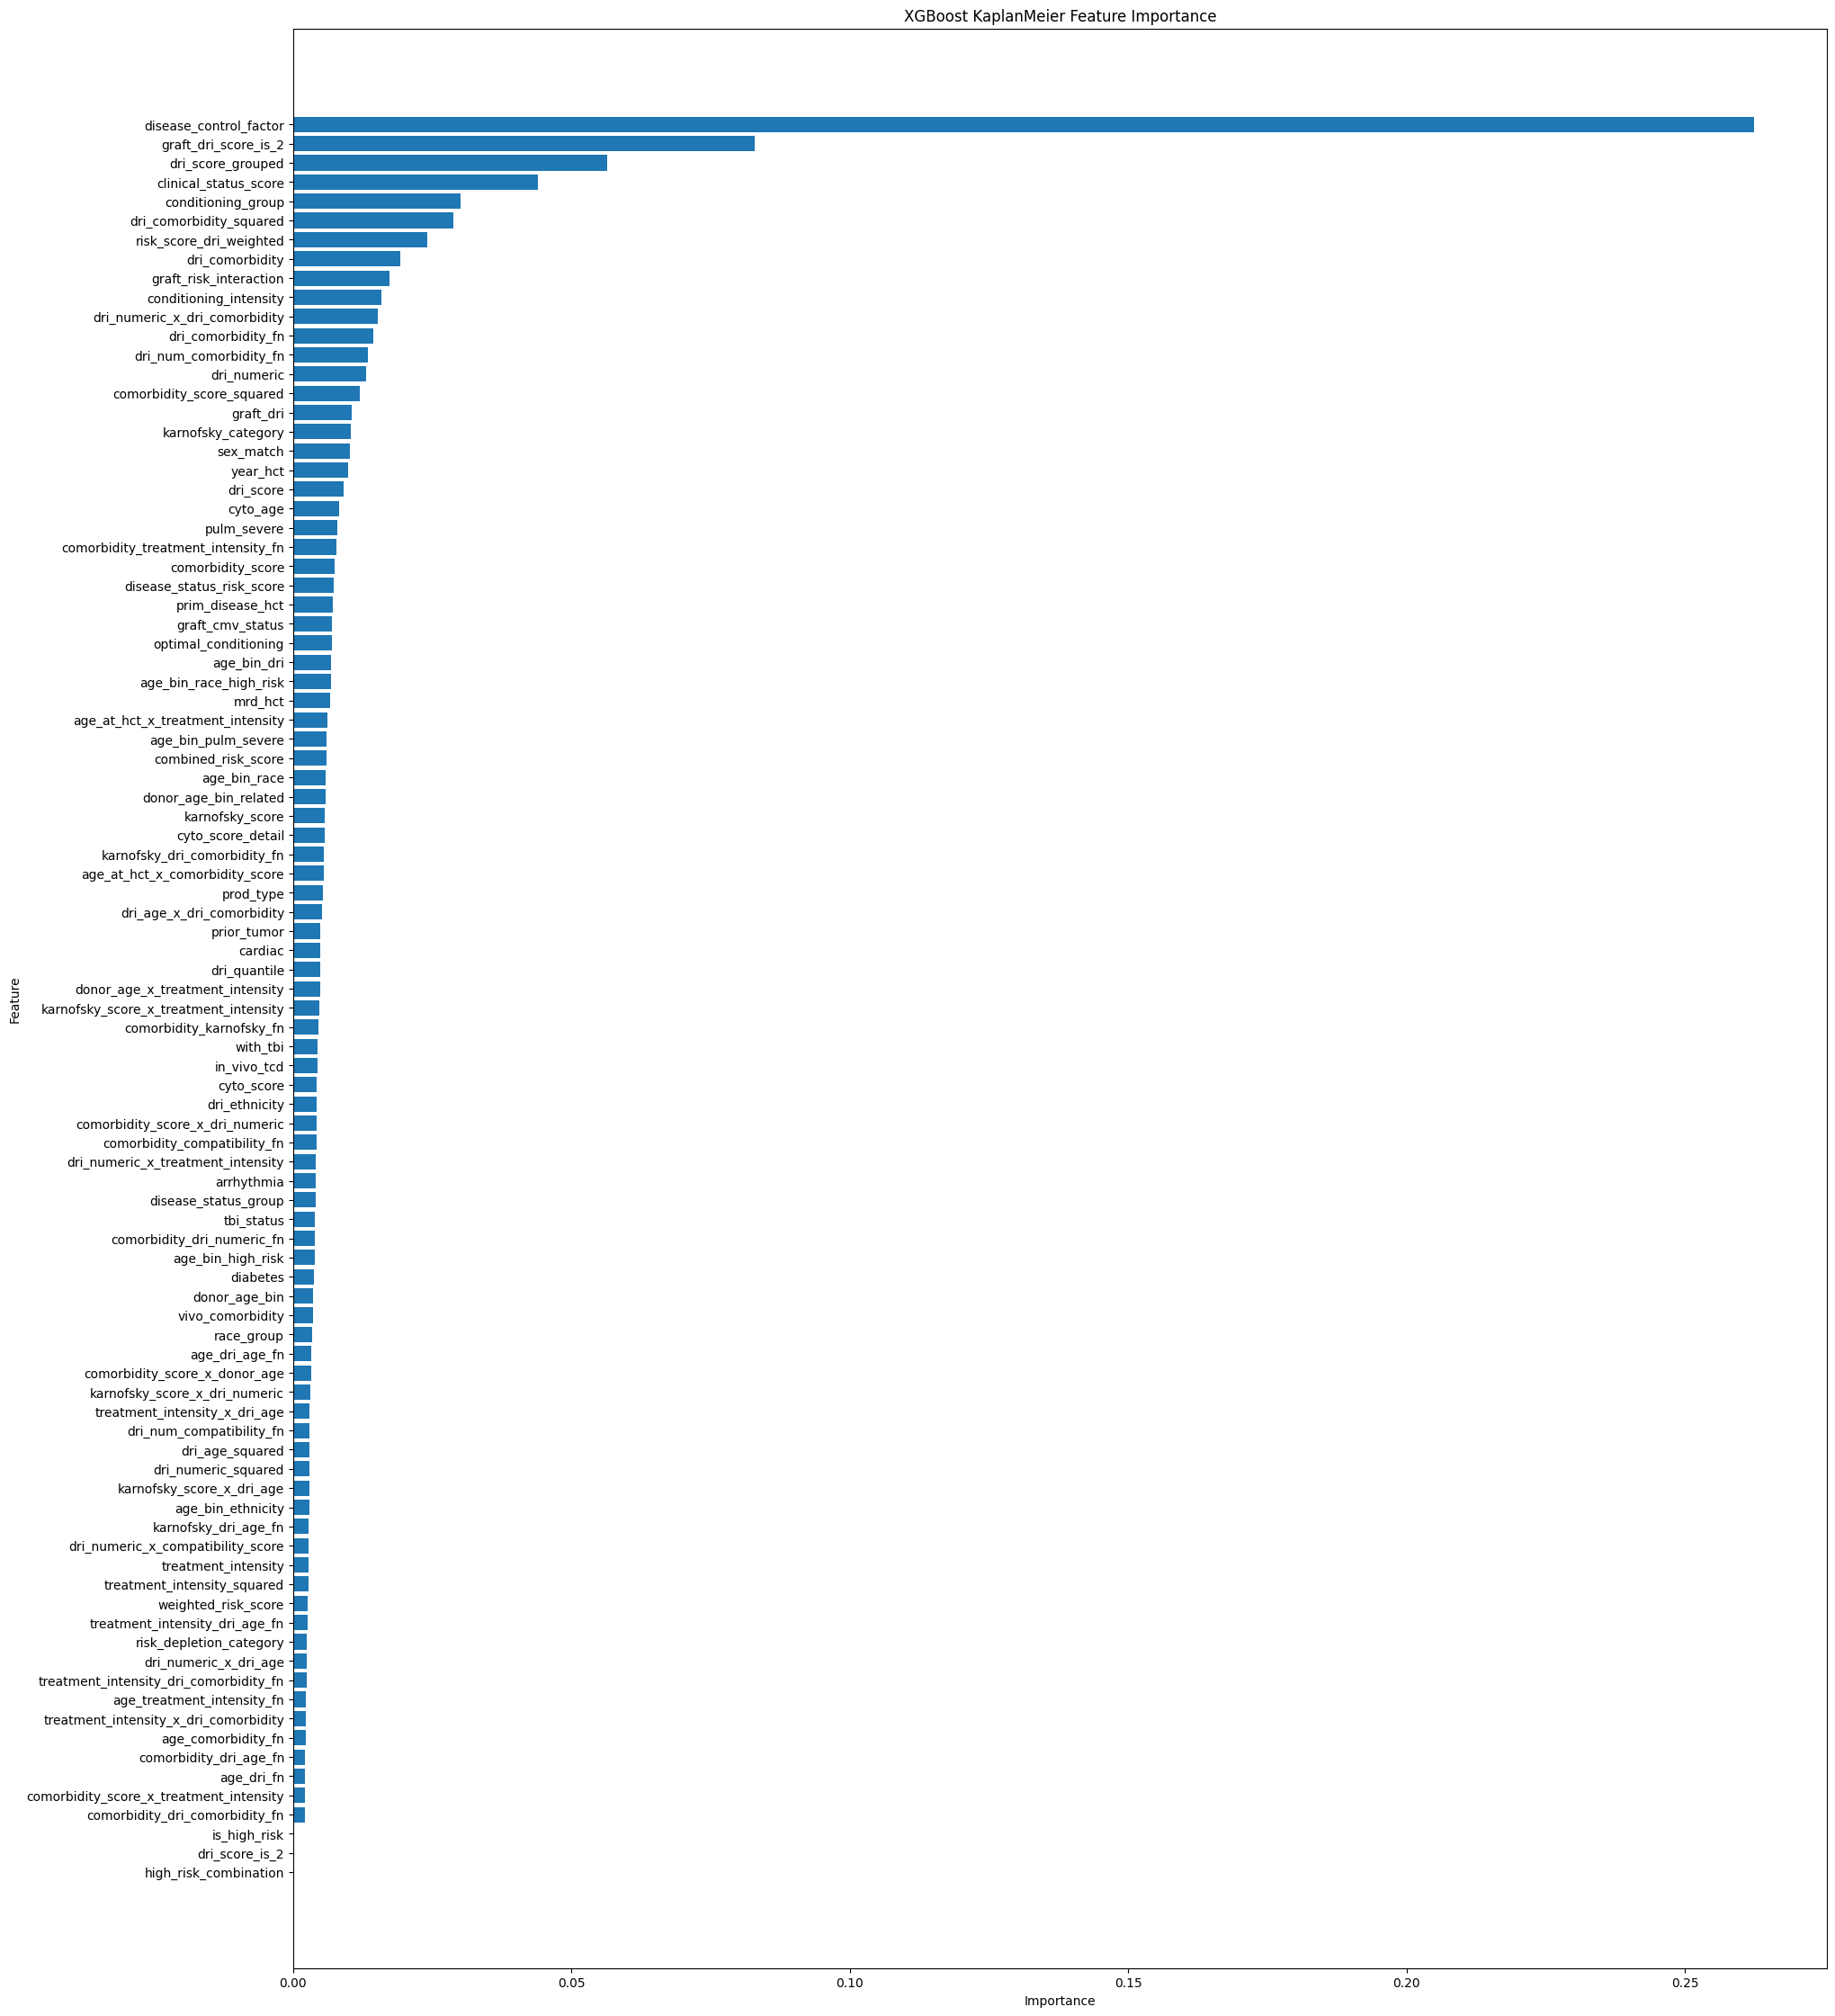

In [696]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 28))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/xgboost_km_feature_importance.png')
plt.show()

# CatBoost with KaplanMeier

In [697]:
# CatBoost with KaplanMeier
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [698]:
# feature selection
FEATURES = [
    'age_at_hct',
    #'age_at_hct_squared',
    'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    #'age_bin',
    #'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    #'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    #'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    'arrhythmia',
    #'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    #'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    #'comorbidity_score',
    #'comorbidity_score_squared',
    'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    #'comorbidity_score_x_dri_numeric',
    'comorbidity_score_x_karnofsky_score',
    #'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    #'diabetes',
    #'disease_control_factor',
    'disease_status_group',
    #'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    'donor_age_squared',
    'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    #'donor_age_x_dri_comorbidity',
    'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    #'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    #'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    #'dri_comorbidity',
    #'dri_comorbidity_squared',
    'dri_ethnicity',
    #'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    'dri_numeric_x_dri_comorbidity',
    #'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    'dri_score_grouped',
    #'dri_score_is_2',
    'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    #'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    #'hla_match_drb1_mean',  # cox only
    #'hla_match_total',
    #'hla_match_weighted',
    #'hla_max',
    #'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    'karnofsky_score_x_dri_age',
    'karnofsky_score_x_dri_comorbidity',
    'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    #'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    #'prod_type',
    #'psych_disturb',
    #'pulm_moderate',
    #'pulm_severe',
    'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    #'treatment_intensity',
    #'treatment_intensity_squared',
    #'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    #'with_tbi'
    # added functions
    'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    #'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    # add back features
    'year_hct',
    'karnofsky_score',
    'prim_disease_hct',
    'age_bin_to_donor_age_bin',
    'comorbidity_age',
    'sex_match',
    'cmv_status',
    'age_bin_race',
    'age_bin_dri',
    #'comorbidity_score_by_age_at_hct',
    'vivo_prim_disease',
    'years_since_2008',
    'pre_post_2015'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [699]:
class CatBoostModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_catboost_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list, cat_features: List[str]) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'task_type': 'GPU',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Lossguide', 'Depthwise']),
            'depth': trial.suggest_int('depth', 5, 9),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
            'subsample': trial.suggest_float('subsample', 0.6, 0.99),
            'early_stopping_rounds': 50,
            'verbose': 0
        }
        
        # Handle special parameter dependencies
        if param['bootstrap_type'] == 'Bayesian':
            param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)
        
        model = CatBoostRegressor(**param)
        model.fit(
            train_data[features], train_data['y_km'],
            eval_set=(valid_data[features], valid_data['y_km']),
            cat_features=cat_features,
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        cat_features: List[str],
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, CatBoostRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            cat_features: List of categorical feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_cat: Predictions for test set
            - oof_cat: Out-of-fold predictions for training set
            - cat_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_cat = np.zeros(len(train))
        pred_cat = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(
                    trial, train_fold, valid_fold, features, cat_features
                ),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'task_type': 'GPU',
                'early_stopping_rounds': 50
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'task_type': 'GPU',
                    'learning_rate': 0.01,
                    'grow_policy': 'Lossguide',
                    'depth': 6,
                    'min_data_in_leaf': 1,
                    'l2_leaf_reg': 3.0,
                    'random_strength': 1,
                    'n_estimators': 2000,
                    'bootstrap_type': 'Bernoulli',
                    'subsample': 0.8,
                    'early_stopping_rounds': 50
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]
            
            model = CatBoostRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=(x_valid, y_valid),
                cat_features=cat_features,
                verbose=250
            )
            
            if i == 0:
                best_model = model

            oof_cat[valid_idx] = model.predict(x_valid)
            pred_cat += model.predict(x_test)

        pred_cat /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_cat
        cat_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {cat_score}")
        
        return pred_cat, oof_cat, cat_score, best_model

In [700]:
# Initialize the model
cat_model = CatBoostModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_cat, oof_cat, cat_score, model_cat = cat_model.train_and_predict(
    train, test, FEATURES, CATS, tune_hyperparameters=False
)

Training fold 1/10
0:	learn: 0.1761576	test: 0.1776555	best: 0.1776555 (0)	total: 4.15ms	remaining: 7.94s
250:	learn: 0.1553867	test: 0.1617257	best: 0.1617257 (250)	total: 921ms	remaining: 6.11s
500:	learn: 0.1512791	test: 0.1601282	best: 0.1601282 (500)	total: 1.82s	remaining: 5.16s
750:	learn: 0.1487980	test: 0.1597063	best: 0.1597005 (749)	total: 2.71s	remaining: 4.21s
1000:	learn: 0.1466305	test: 0.1594807	best: 0.1594790 (999)	total: 3.59s	remaining: 3.28s
1250:	learn: 0.1447858	test: 0.1593877	best: 0.1593831 (1249)	total: 4.47s	remaining: 2.38s
1500:	learn: 0.1433277	test: 0.1593192	best: 0.1593039 (1473)	total: 5.39s	remaining: 1.49s
bestTest = 0.1593038812
bestIteration = 1473
Shrink model to first 1474 iterations.
Training fold 2/10
0:	learn: 0.1766178	test: 0.1734890	best: 0.1734890 (0)	total: 4.05ms	remaining: 7.77s
250:	learn: 0.1559342	test: 0.1572221	best: 0.1572221 (250)	total: 921ms	remaining: 6.11s
500:	learn: 0.1519844	test: 0.1560261	best: 0.1560261 (500)	total: 1.

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


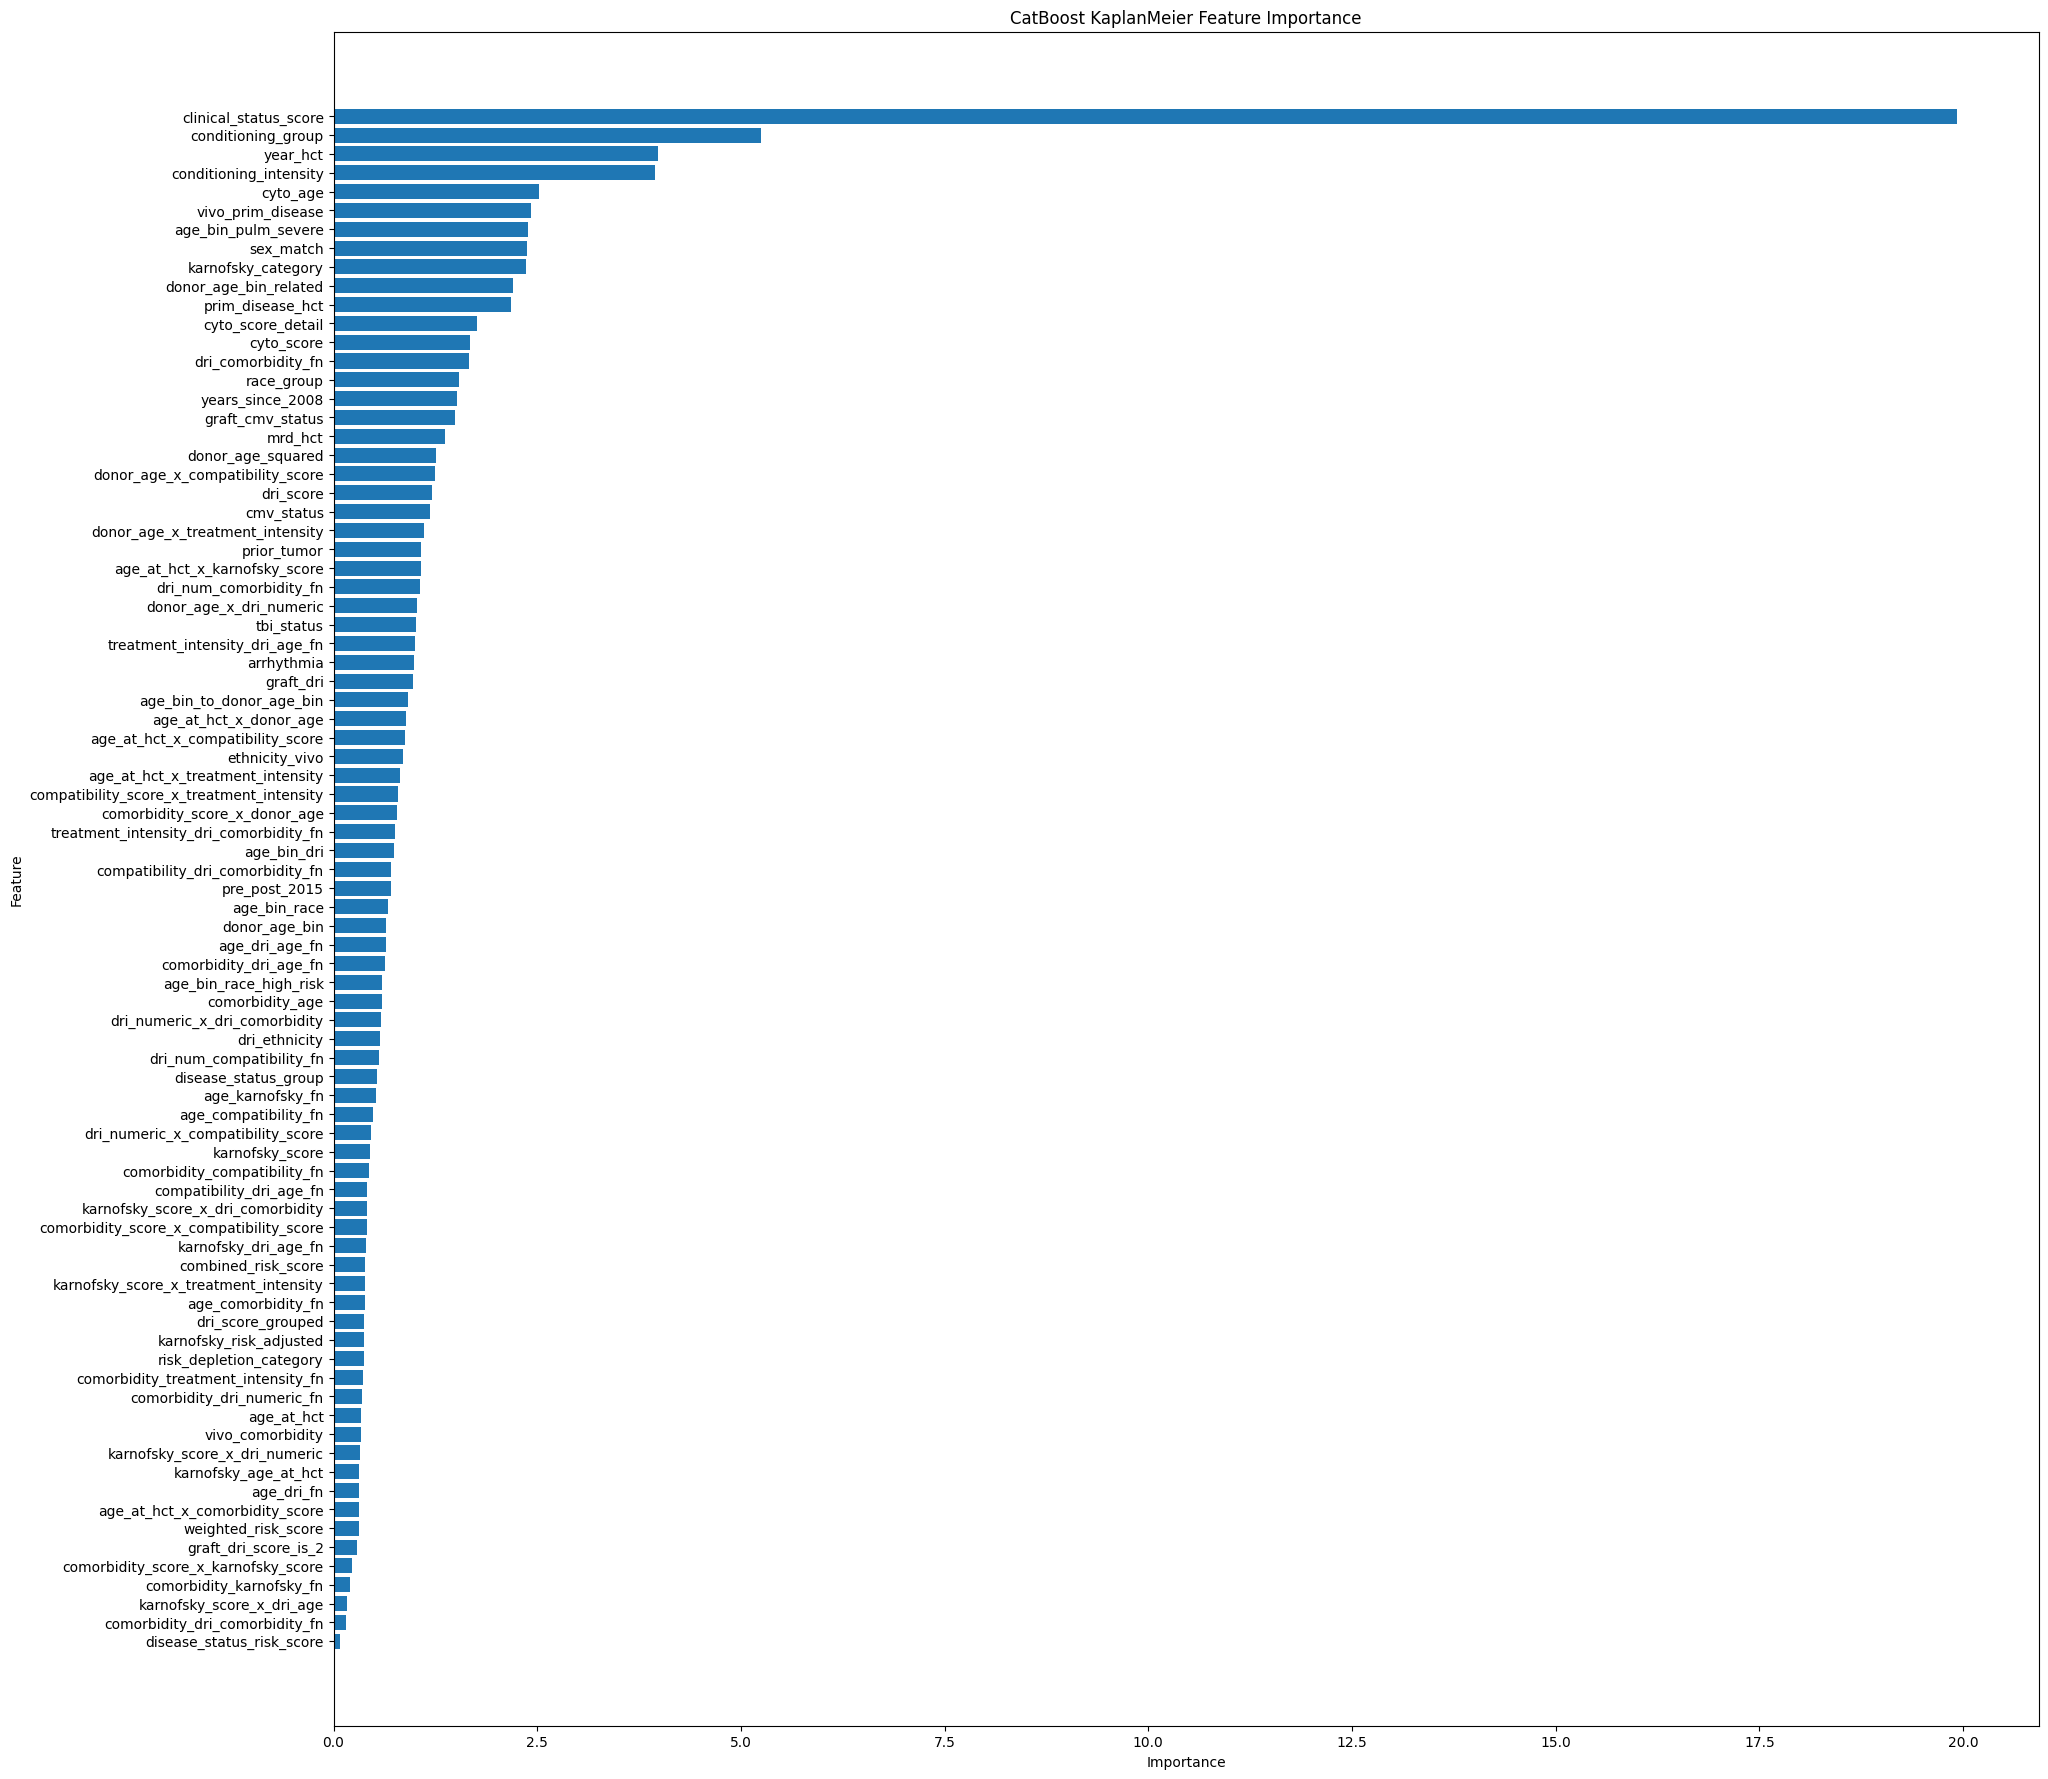

In [701]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/catboost_km_feature_importance.png')
plt.show()

# LightGBM with KaplanMeier

In [702]:
# LightGBM with KaplanMeier
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.5.0


In [703]:
# feature selection
FEATURES = [
    #'age_at_hct',
    'age_at_hct_squared',
    'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    'age_at_hct_x_donor_age',
    'age_at_hct_x_dri_age',
    'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    #'age_bin',
    'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    #'arrhythmia',
    #'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    #'compatibility_score_x_dri_age',
    'compatibility_score_x_dri_comorbidity',
    'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    'comorbidity_score',
    #'comorbidity_score_squared',
    'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    #'comorbidity_score_x_dri_numeric',
    #'comorbidity_score_x_karnofsky_score',
    #'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    #'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    #'diabetes',
    #'disease_control_factor',
    #'disease_status_group',
    #'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    'donor_age_squared',
    'donor_age_x_compatibility_score',
    'donor_age_x_dri_age',
    'donor_age_x_dri_comorbidity',
    'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    #'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    #'dri_comorbidity',
    #'dri_comorbidity_squared',
    'dri_ethnicity',
    #'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    #'dri_numeric_x_dri_comorbidity',
    #'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    #'dri_score_grouped',
    #'dri_score_is_2',
    #'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    #'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    #'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    #'hla_match_drb1_mean',  # cox only
    #'hla_match_total',
    #'hla_match_weighted',
    'hla_max',
    #'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    'karnofsky_score_x_dri_age',
    #'karnofsky_score_x_dri_comorbidity',
    'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    #'optimal_conditioning',
    #'optimal_disease_status',
    #'prior_tumor',
    #'prod_type',
    #'psych_disturb',
    #'pulm_moderate',
    #'pulm_severe',
    #'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    'treatment_intensity',
    #'treatment_intensity_squared',
    'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    #'with_tbi'
    # added functions
    #'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    #'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    #'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    #'age_comorbidity_fn',
    #'age_compatibility_fn',
    #'age_dri_age_fn',
    'age_dri_fn',
    #'age_karnofsky_fn',
    'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    # add back features
    'age_bin_dri',
    'age_bin_race',
    'prim_disease_hct',
    'year_hct',
    'gvhd_proph',
    'karnofsky_score',
    'hla_nmdp_6',
    'comorbidity_age',
    'comorbidity_score_by_age_at_hct',
    'donor_by_age_at_hct',
    'compatibility_score',
    'karnofsky_hla_interaction',
    'vivo_age_bin',
    'immune_burden',
    'years_since_2008',
    'transplant_era',
    'cmv_status',
    'hla_mismatch_score'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [704]:
class LightGBMModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_lgb_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'device': 'gpu',
            'gpu_use_dp': True,
            'num_leaves': trial.suggest_int('num_leaves', 15, 63),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.5),
            'subsample': trial.suggest_float('subsample', 0.6, 0.99),
            'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'objective': 'regression',
            'verbose': -1
        }
        
        model = LGBMRegressor(**param)
        model.fit(
            train_data[features], train_data['y_km'],
            eval_set=[(valid_data[features], valid_data['y_km'])]
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, LGBMRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_lgb: Predictions for test set
            - oof_lgb: Out-of-fold predictions for training set
            - lgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_lgb = np.zeros(len(train))
        pred_lgb = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'device': 'gpu',
                'gpu_use_dp': True,
                'objective': 'regression'
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'device': 'gpu',
                    'num_leaves': 31,
                    'max_depth': 3,
                    'colsample_bytree': 0.4,
                    'subsample': 0.8,
                    'n_estimators': 2500,
                    'learning_rate': 0.01,
                    'objective': 'regression',
                    'gpu_use_dp': True
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]
            
            model = LGBMRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)]
            )
            
            if i == 0:
                best_model = model

            oof_lgb[valid_idx] = model.predict(x_valid)
            pred_lgb += model.predict(x_test)

        pred_lgb /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_lgb
        lgb_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {lgb_score}")
        
        return pred_lgb, oof_lgb, lgb_score, best_model

In [705]:
# Initialize the model
lgb_model = LightGBMModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_lgb, oof_lgb, lgb_score, model_lgb = lgb_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

Training fold 1/10
Training fold 2/10
Training fold 3/10
Training fold 4/10
Training fold 5/10
Training fold 6/10
Training fold 7/10
Training fold 8/10
Training fold 9/10
Training fold 10/10

Overall CV Score: 0.6532129302668902


d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


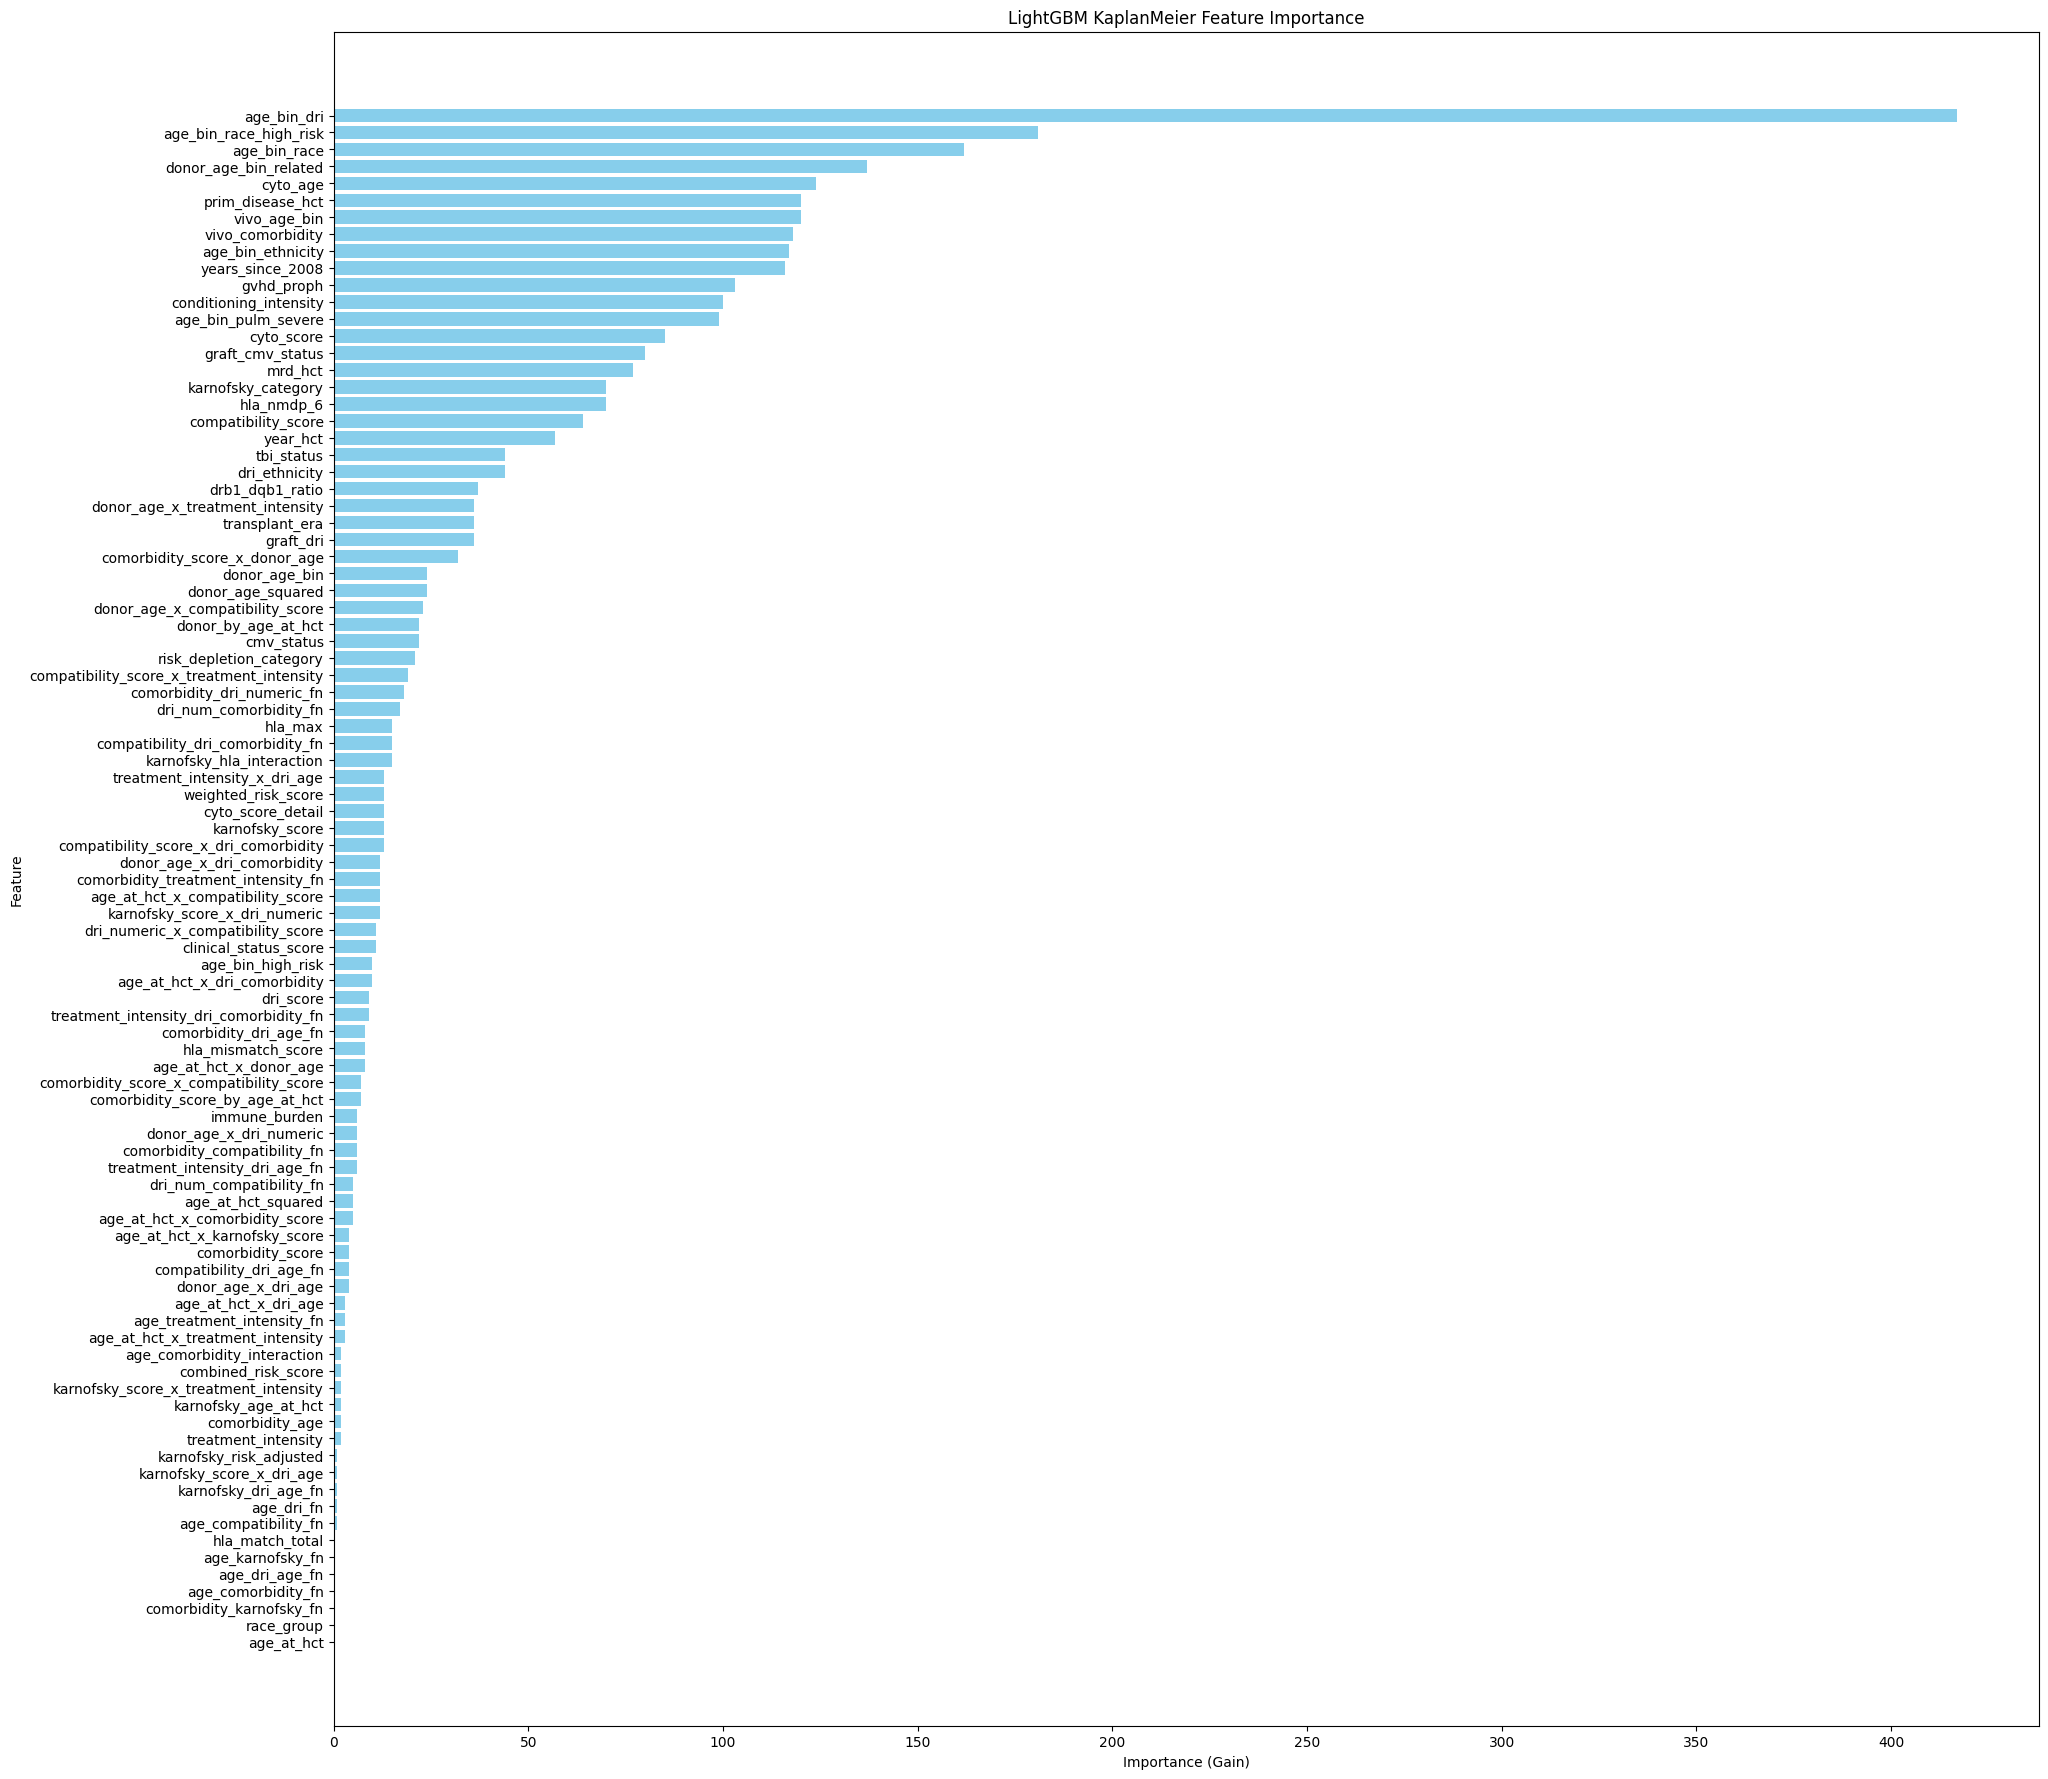

In [706]:
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/lightgbm_km_feature_importance.png')
plt.show()

# XGBoost with Survival:Cox

In [707]:
# XGBoost with Survival:Cox
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [708]:
# feature selection
FEATURES = [
    'age_at_hct',
    #'age_at_hct_squared',
    #'age_at_hct_x_compatibility_score',
    #'age_at_hct_x_comorbidity_score',
    #'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    #'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    'age_bin',
    #'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    #'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    #'arrhythmia',
    'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    #'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    #'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    'comorbidity_score',
    'comorbidity_score_squared',
    #'comorbidity_score_x_compatibility_score',
    #'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    'comorbidity_score_x_dri_comorbidity',
    'comorbidity_score_x_dri_numeric',
    'comorbidity_score_x_karnofsky_score',
    'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    #'diabetes',
    'disease_control_factor',
    'disease_status_group',
    'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    #'donor_age_squared',
    #'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    #'donor_age_x_dri_comorbidity',
    #'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    'drb1_dqb1_diff',
    'drb1_dqb1_ratio',
    'drb1_high_interaction',  # cox only
    #'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    'dri_comorbidity',
    'dri_comorbidity_squared',
    'dri_ethnicity',
    #'dri_numeric',
    #'dri_numeric_squared',
    #'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    'dri_numeric_x_dri_comorbidity',
    #'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    'dri_score_grouped',
    #'dri_score_is_2',
    #'ethnicity_vivo',
    'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    'high_risk_combination',  # commented out in original
    #'hla_match_drb1_mean',  # cox only
    #'hla_match_total',
    #'hla_match_weighted',
    #'hla_max',
    'in_vivo_tcd',
    #'is_complex',  # cox high
    'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    #'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    'karnofsky_score_x_dri_age',
    'karnofsky_score_x_dri_comorbidity',
    'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    #'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    'optimal_conditioning',
    #'optimal_disease_status',
    #'prior_tumor',
    'prod_type',
    #'psych_disturb',
    #'pulm_moderate',
    'pulm_severe',
    'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    'treatment_intensity',
    #'treatment_intensity_squared',
    #'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    #'with_tbi'
    # added functions
    'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    #'age_comorbidity_fn',
    #'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    #'treatment_intensity_dri_comorbidity_fn',
    'karnofsky_dri_comorbidity_fn',
    # add back features
    'graft_prod',
    'prim_disease_hct',
    'sex_match',
    'comorbidity_age',
    'cmv_status',
    'karnofsky_score',
    'vivo_prim_disease',
    'years_since_2008',
    'age_bin_dri',
    'year_hct',
    'gvhd_proph'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [709]:
class XGBoostCoxModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_xgb_cox_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'device': 'cuda',
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.5),
            'subsample': trial.suggest_float('subsample', 0.8, 0.99),
            'n_estimators': trial.suggest_int('n_estimators', 2000, 4000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 40, 80),
            'enable_categorical': True,
            'objective': 'survival:cox',
            'eval_metric': 'cox-nloglik'
        }
        
        model = XGBRegressor(**param)
        model.fit(
            train_data[features], train_data['efs_time2'],
            eval_set=[(valid_data[features], valid_data['efs_time2'])],
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, XGBRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_xgb_cox: Predictions for test set
            - oof_xgb_cox: Out-of-fold predictions for training set
            - xgb_cox_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_xgb_cox = np.zeros(len(train))
        pred_xgb_cox = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            self.best_params.update({
                'device': 'cuda',
                'enable_categorical': True,
                'objective': 'survival:cox',
                'eval_metric': 'cox-nloglik'
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'device': 'cuda',
                    'max_depth': 3,
                    'colsample_bytree': 0.5,
                    'subsample': 0.8,
                    'n_estimators': 2000,
                    'learning_rate': 0.02,
                    'enable_categorical': True,
                    'min_child_weight': 80,
                    'objective': 'survival:cox',
                    'eval_metric': 'cox-nloglik'
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['efs_time2']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['efs_time2']
            x_test = test[features]
            
            model = XGBRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=500
            )
            
            if i == 0:
                best_model = model

            oof_xgb_cox[valid_idx] = model.predict(x_valid)
            pred_xgb_cox += model.predict(x_test)

        pred_xgb_cox /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_xgb_cox
        xgb_cox_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {xgb_cox_score}")
        
        return pred_xgb_cox, oof_xgb_cox, xgb_cox_score, best_model

In [710]:
# Initialize the model
xgb_cox_model = XGBoostCoxModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_xgb_cox, oof_xgb_cox, xgb_cox_score, model_xgb_cox = xgb_cox_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

Training fold 1/10
[0]	validation_0-cox-nloglik:7.62522
[500]	validation_0-cox-nloglik:7.43481
[1000]	validation_0-cox-nloglik:7.42655
[1500]	validation_0-cox-nloglik:7.42785
[2000]	validation_0-cox-nloglik:7.43236
[2500]	validation_0-cox-nloglik:7.43753
[3000]	validation_0-cox-nloglik:7.44286
[3500]	validation_0-cox-nloglik:7.44956
[3649]	validation_0-cox-nloglik:7.45188
Training fold 2/10
[0]	validation_0-cox-nloglik:7.61844
[500]	validation_0-cox-nloglik:7.41290
[1000]	validation_0-cox-nloglik:7.41159
[1500]	validation_0-cox-nloglik:7.41636
[2000]	validation_0-cox-nloglik:7.42159
[2500]	validation_0-cox-nloglik:7.42824
[3000]	validation_0-cox-nloglik:7.43787
[3500]	validation_0-cox-nloglik:7.44710
[3649]	validation_0-cox-nloglik:7.44952
Training fold 3/10
[0]	validation_0-cox-nloglik:7.61077
[500]	validation_0-cox-nloglik:7.40876
[1000]	validation_0-cox-nloglik:7.41012
[1500]	validation_0-cox-nloglik:7.41509
[2000]	validation_0-cox-nloglik:7.42145
[2500]	validation_0-cox-nloglik:7.4

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


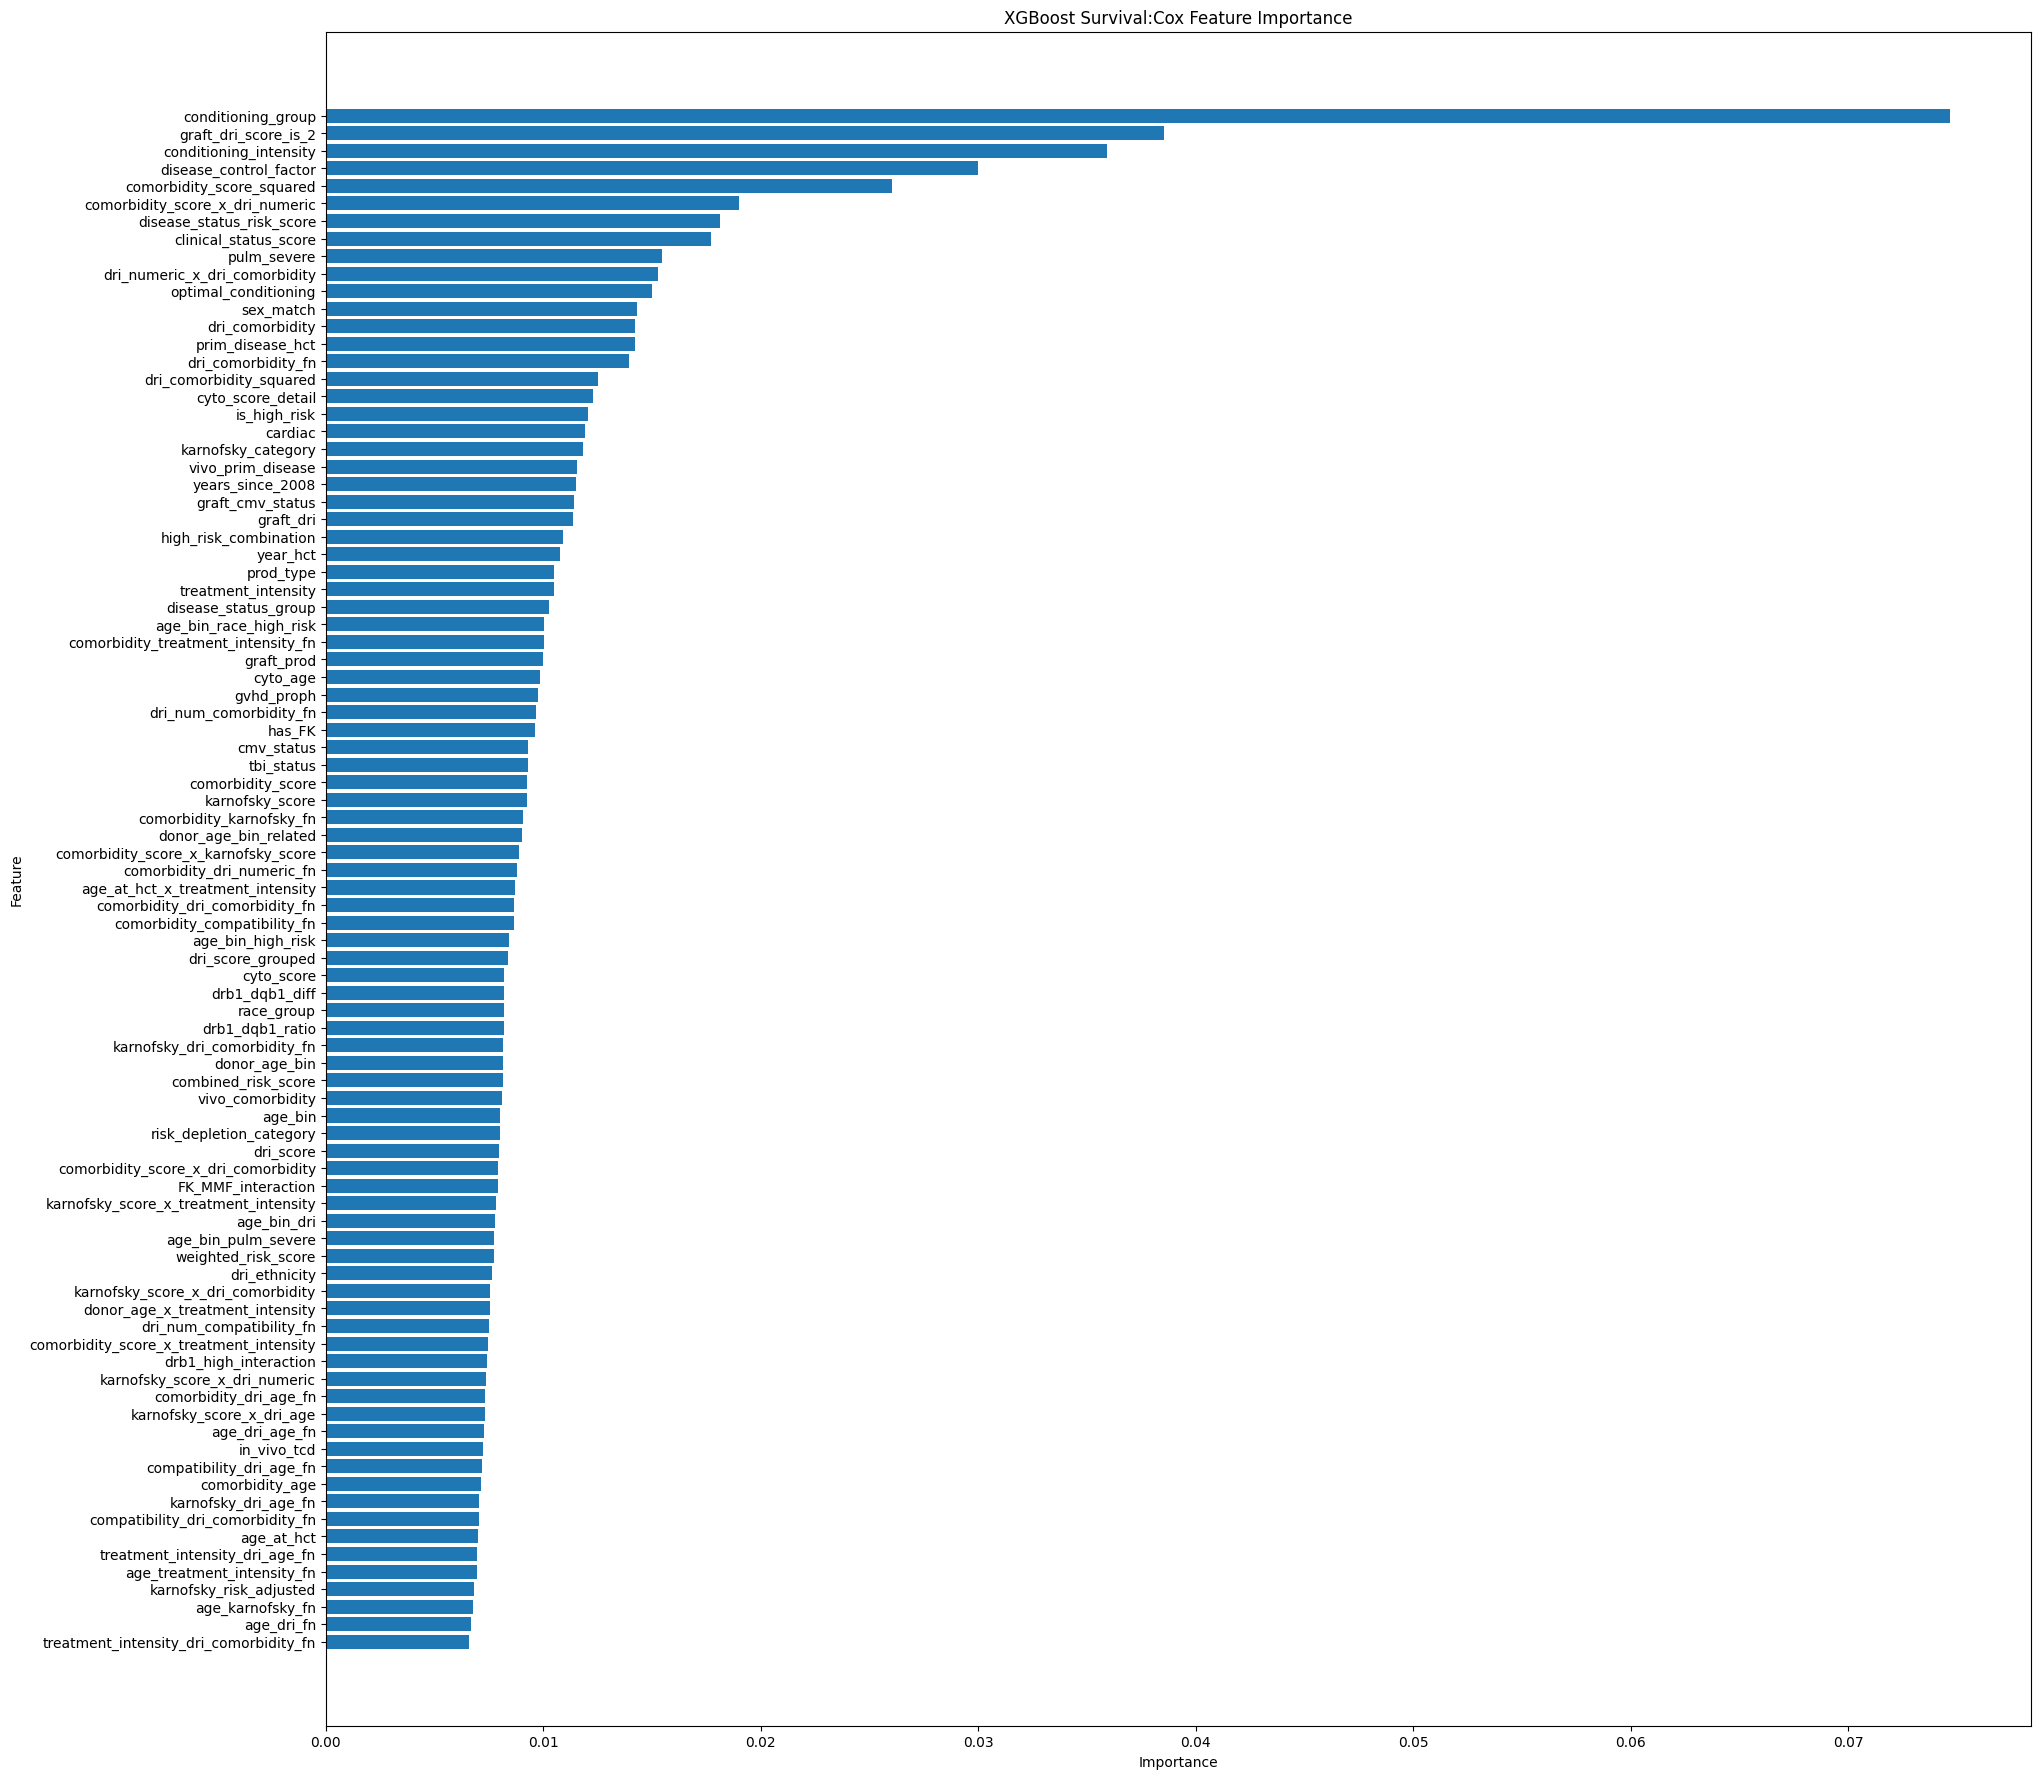

In [711]:
feature_importance = model_xgb_cox.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/xgboost_cox_feature_importance.png')
plt.show()

# CatBoost with Survival:Cox

In [712]:
# CatBoost with Survival:Cox
# feature selection
FEATURES = [
    'age_at_hct',
    #'age_at_hct_squared',
    'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    'age_bin',
    'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    #'arrhythmia',
    'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    'comorbidity_score',
    #'comorbidity_score_squared',
    'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    #'comorbidity_score_x_dri_numeric',
    'comorbidity_score_x_karnofsky_score',
    'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    'diabetes',
    #'disease_control_factor',
    'disease_status_group',
    'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    'donor_age_squared',
    'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    'donor_age_x_dri_comorbidity',
    'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    #'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    'dri_age_squared',
    'dri_age_x_dri_comorbidity',
    'dri_comorbidity',
    'dri_comorbidity_squared',
    'dri_ethnicity',
    'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    'dri_numeric_x_dri_age',
    'dri_numeric_x_dri_comorbidity',
    'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    'dri_score_grouped',
    #'dri_score_is_2',
    'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    'hla_match_drb1_mean',  # cox only
    'hla_match_total',
    #'hla_match_weighted',
    #'hla_max',
    'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    #'karnofsky_score_x_dri_age',
    'karnofsky_score_x_dri_comorbidity',
    'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    #'mrd_hct',  # cox only
    #'multiple_conditions',
    'n_agents',  # cox high
    #'obesity',
    #'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    'prod_type',
    'psych_disturb',
    #'pulm_moderate',
    'pulm_severe',
    #'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    'treatment_intensity',
    'treatment_intensity_squared',
    'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    'with_tbi',
    # added functions
    'dri_comorbidity_fn',
    #'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    #'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    # added back features
    'prim_disease_hct',
    'year_hct',
    'sex_match',
    'comorbidity_age',
    'karnofsky_score',
    'graft_prod',
    'cmv_status',
    'gvhd_proph',
    'karnofsky_dri_comorbidity_fn',
    'vivo_prim_disease'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [713]:
class CatBoostCoxModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_catboost_cox_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list, cat_features: List[str]) -> float:
        param = {
            'loss_function': 'Cox',
            'iterations': trial.suggest_int('iterations', 800, 1200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Lossguide', 'Depthwise']),
            'depth': trial.suggest_int('depth', 4, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4.0, 10.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 30, 80),
            'rsm': trial.suggest_float('rsm', 0.1, 0.2),
            'use_best_model': False,
            'early_stopping_rounds': 100
        }
        
        model = CatBoostRegressor(**param)
        model.fit(
            train_data[features], train_data['efs_time2'],
            eval_set=(valid_data[features], valid_data['efs_time2']),
            cat_features=cat_features,
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        cat_features: List[str],
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, CatBoostRegressor]:
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_cat_cox = np.zeros(len(train))
        pred_cat_cox = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(
                    trial, train_fold, valid_fold, features, cat_features
                ),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            self.best_params.update({
                'loss_function': 'Cox',
                'use_best_model': False,
                'early_stopping_rounds': 100
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                self.best_params = {
                    'loss_function': 'Cox',
                    'iterations': 600,
                    'learning_rate': 0.01,
                    'grow_policy': 'Lossguide',
                    'use_best_model': False,
                    'early_stopping_rounds': 100,
                    'depth': 4,
                    'l2_leaf_reg': 5.0
                }

        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['efs_time2']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['efs_time2']
            x_test = test[features]
            
            model = CatBoostRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=(x_valid, y_valid),
                cat_features=cat_features,
                verbose=100
            )
            
            if i == 0:
                best_model = model

            oof_cat_cox[valid_idx] = model.predict(x_valid)
            pred_cat_cox += model.predict(x_test)

        pred_cat_cox /= self.n_folds
        
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_cat_cox
        cat_cox_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {cat_cox_score}")
        
        return pred_cat_cox, oof_cat_cox, cat_cox_score, best_model

In [714]:
# Initialize the model
cat_cox_model = CatBoostCoxModel(n_folds=10, n_trials=400)

pred_cat_cox, oof_cat_cox, cat_cox_score, model_cat_cox = cat_cox_model.train_and_predict(
    train, test, FEATURES, CATS, tune_hyperparameters=False
)

Training fold 1/10
0:	learn: -137272.5346996	test: -11632.7627741	best: -11632.7627741 (0)	total: 56.4ms	remaining: 45.5s
100:	learn: -133841.8325293	test: -11380.4645567	best: -11380.4645567 (100)	total: 5.31s	remaining: 37.2s
200:	learn: -133069.6984749	test: -11378.1584757	best: -11374.9088527 (131)	total: 9.39s	remaining: 28.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = -11374.90885
bestIteration = 131

Training fold 2/10
0:	learn: -137081.2423021	test: -11781.6043941	best: -11781.6043941 (0)	total: 66.3ms	remaining: 53.5s
100:	learn: -133685.0957652	test: -11490.1900717	best: -11490.1900717 (100)	total: 5.67s	remaining: 39.7s
200:	learn: -132809.8541360	test: -11481.0650564	best: -11480.8623527 (171)	total: 9.96s	remaining: 30.1s
300:	learn: -132004.6485472	test: -11480.1134841	best: -11476.8691031 (259)	total: 14s	remaining: 23.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = -11476.8691
bestIteration = 259

Training fold 3/10
0:	learn

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


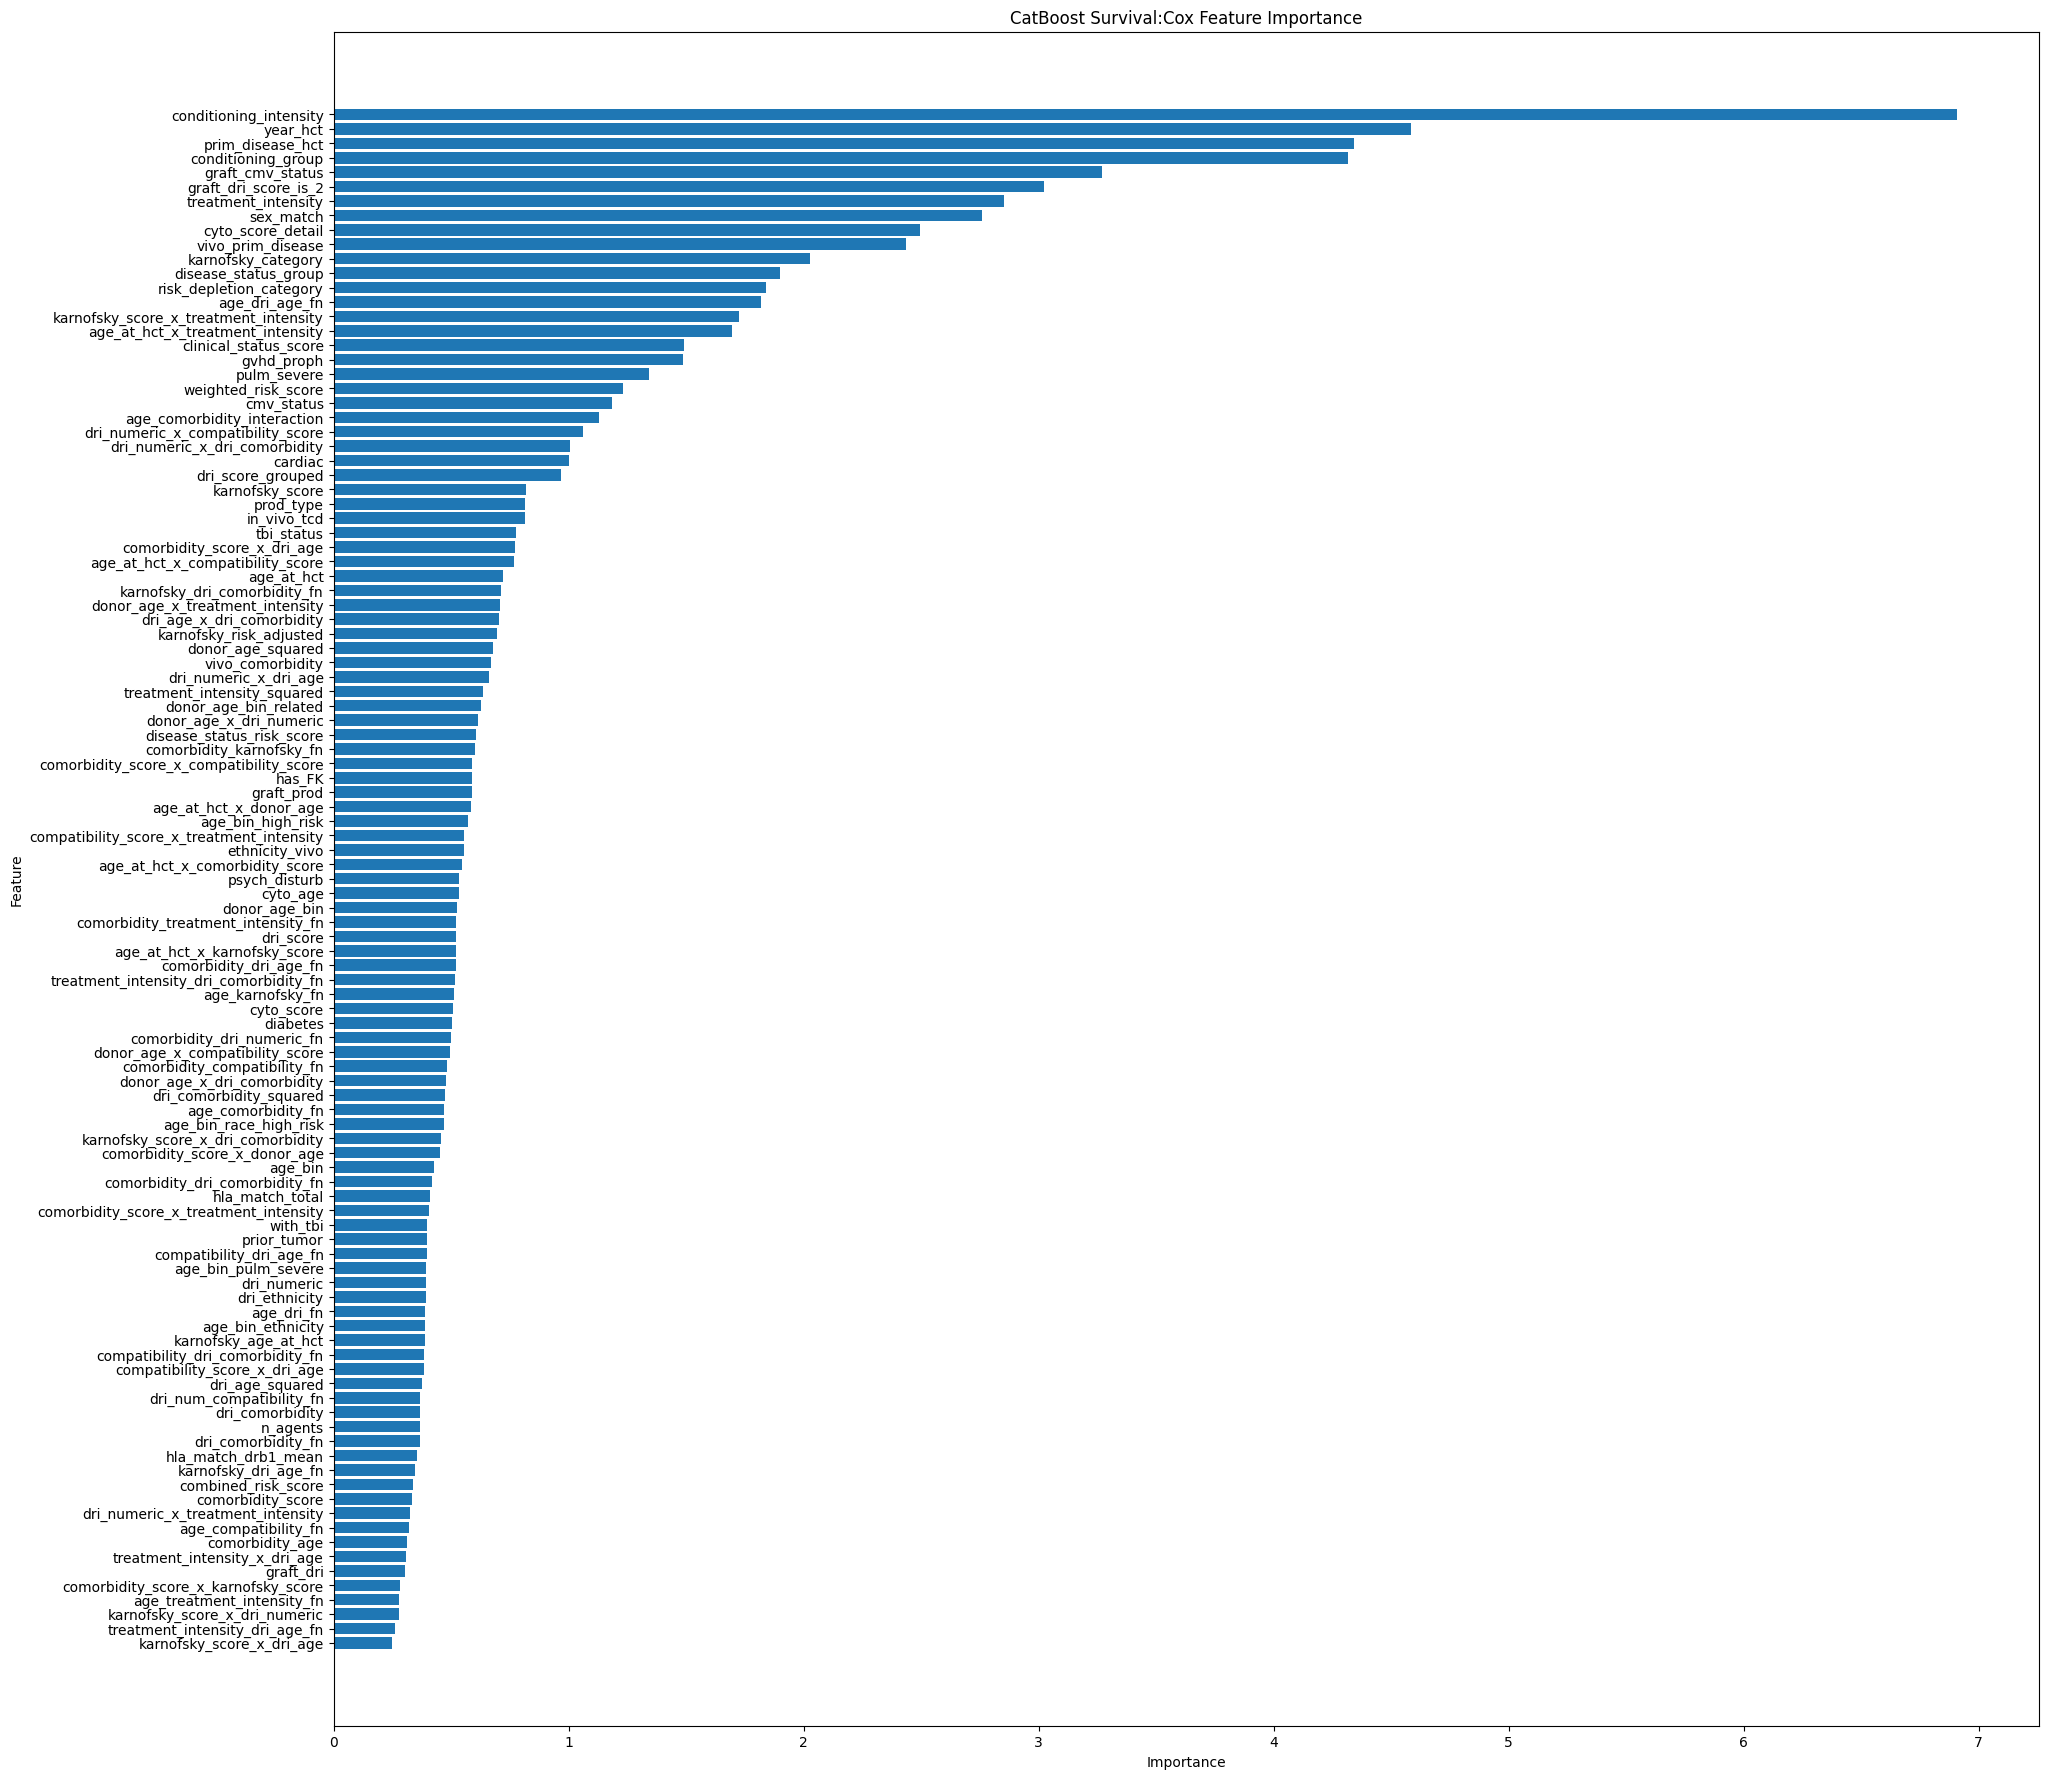

In [715]:
feature_importance = model_cat_cox.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/catboost_cox_feature_importance.png')
plt.show()

# LightGBM with Cox

In [716]:
# LightGBM with Cox
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.5.0


In [717]:
# feature selection
FEATURES = [
    #'age_at_hct_squared',
    'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    #'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    #'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    'age_bin',
    'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    #'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    #'arrhythmia',
    'cardiac',
    #'clinical_status_score',
    #'combined_risk_score',
    'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    #'comorbidity_score',
    #'comorbidity_score_squared',
    'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    #'comorbidity_score_x_dri_numeric',
    #'comorbidity_score_x_karnofsky_score',
    #'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    'diabetes',
    #'disease_control_factor',
    'disease_status_group',
    #'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    #'donor_age_squared',
    'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    'donor_age_x_dri_comorbidity',
    'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    'drb1_dqb1_ratio',
    'drb1_high_interaction',  # cox only
    #'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    #'dri_comorbidity',
    #'dri_comorbidity_squared',
    'dri_ethnicity',
    #'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    #'dri_numeric_x_dri_comorbidity',
    'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    #'dri_score_grouped',
    #'dri_score_is_2',
    'ethnicity_vivo',
    'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    #'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    'has_combination',
    'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    'hla_match_drb1_mean',  # cox only
    #'hla_match_total',
    'hla_match_weighted',
    'hla_max',
    'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    #'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    #'karnofsky_risk_adjusted',
    #'karnofsky_score_x_dri_age',
    #'karnofsky_score_x_dri_comorbidity',
    #'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    'prod_type',
    'psych_disturb',
    #'pulm_moderate',
    #'pulm_severe',
    'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    #'tbi_status',
    'treatment_intensity',
    #'treatment_intensity_squared',
    'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    'with_tbi',
    # added functions
    'dri_comorbidity_fn',
    #'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    #'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    #'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    #'treatment_intensity_dri_comorbidity_fn',
    # added back features
    'age_bin_race',
    'pre_post_2015',
    'transplant_era',
    'sex_match',
    'year_hct',
    'vivo_age_bin',
    #'years_since_2008',
    'cmv_status',
    'gvhd_proph',
    'vivo_prim_disease',
    'donor_by_age_at_hct',
    'hla_nmdp_6',
    'age_bin_dri',
    'prim_disease_hct',
    'dri_disease_status'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [718]:
class LightGBMModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_lgb_cox_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'device': 'gpu',
            'gpu_use_dp': True,
            'objective': 'regression',
            #'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 24, 100),
            #'num_iterations': trial.suggest_int('num_iterations', 2000, 6000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'extra_trees': True,
            'reg_lambda': trial.suggest_float('reg_lambda', 6.0, 10.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 30, 80),
            'metric': 'rmse',
            'max_depth': trial.suggest_int('max_depth', 5, 9),
            'max_bin': trial.suggest_int('max_bin', 100, 200),
            'verbose': -1,
            'seed': 42
        }
        
        model = LGBMRegressor(**param)
        model.fit(
            train_data[features], train_data['efs_time2'],
            eval_set=[(valid_data[features], valid_data['efs_time2'])]
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, LGBMRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_lgb: Predictions for test set
            - oof_lgb: Out-of-fold predictions for training set
            - lgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_lgb_cox = np.zeros(len(train))
        pred_lgb_cox = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'device': 'cpu',
                #'gpu_use_dp': True,
                'objective': 'regression'
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'objective': 'regression',
                    'min_child_samples': 32,
                    'num_iterations': 6000,
                    'learning_rate': 0.03,
                    'extra_trees': True,
                    'reg_lambda': 8.0,
                    'reg_alpha': 0.1,
                    'num_leaves': 64,
                    'metric': 'rmse',
                    'max_depth': 8,
                    'device': 'cpu',
                    'max_bin': 128,
                    'verbose': -1,
                    'seed': 42
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['efs_time2']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['efs_time2']
            x_test = test[features]
            
            model = LGBMRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)]
            )
            
            if i == 0:
                best_model = model

            oof_lgb_cox[valid_idx] = model.predict(x_valid)
            pred_lgb_cox += model.predict(x_test)

        pred_lgb_cox /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_lgb_cox
        lgb_cox_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {lgb_cox_score}")
        
        return pred_lgb_cox, oof_lgb_cox, lgb_cox_score, best_model

In [719]:
# Initialize the model
lgb_cox_model = LightGBMModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_lgb_cox, oof_lgb_cox, lgb_cox_score, model_lgb_cox = lgb_cox_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

Training fold 1/10
Training fold 2/10
Training fold 3/10
Training fold 4/10
Training fold 5/10
Training fold 6/10
Training fold 7/10
Training fold 8/10
Training fold 9/10
Training fold 10/10

Overall CV Score: 0.6022692323779792


d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


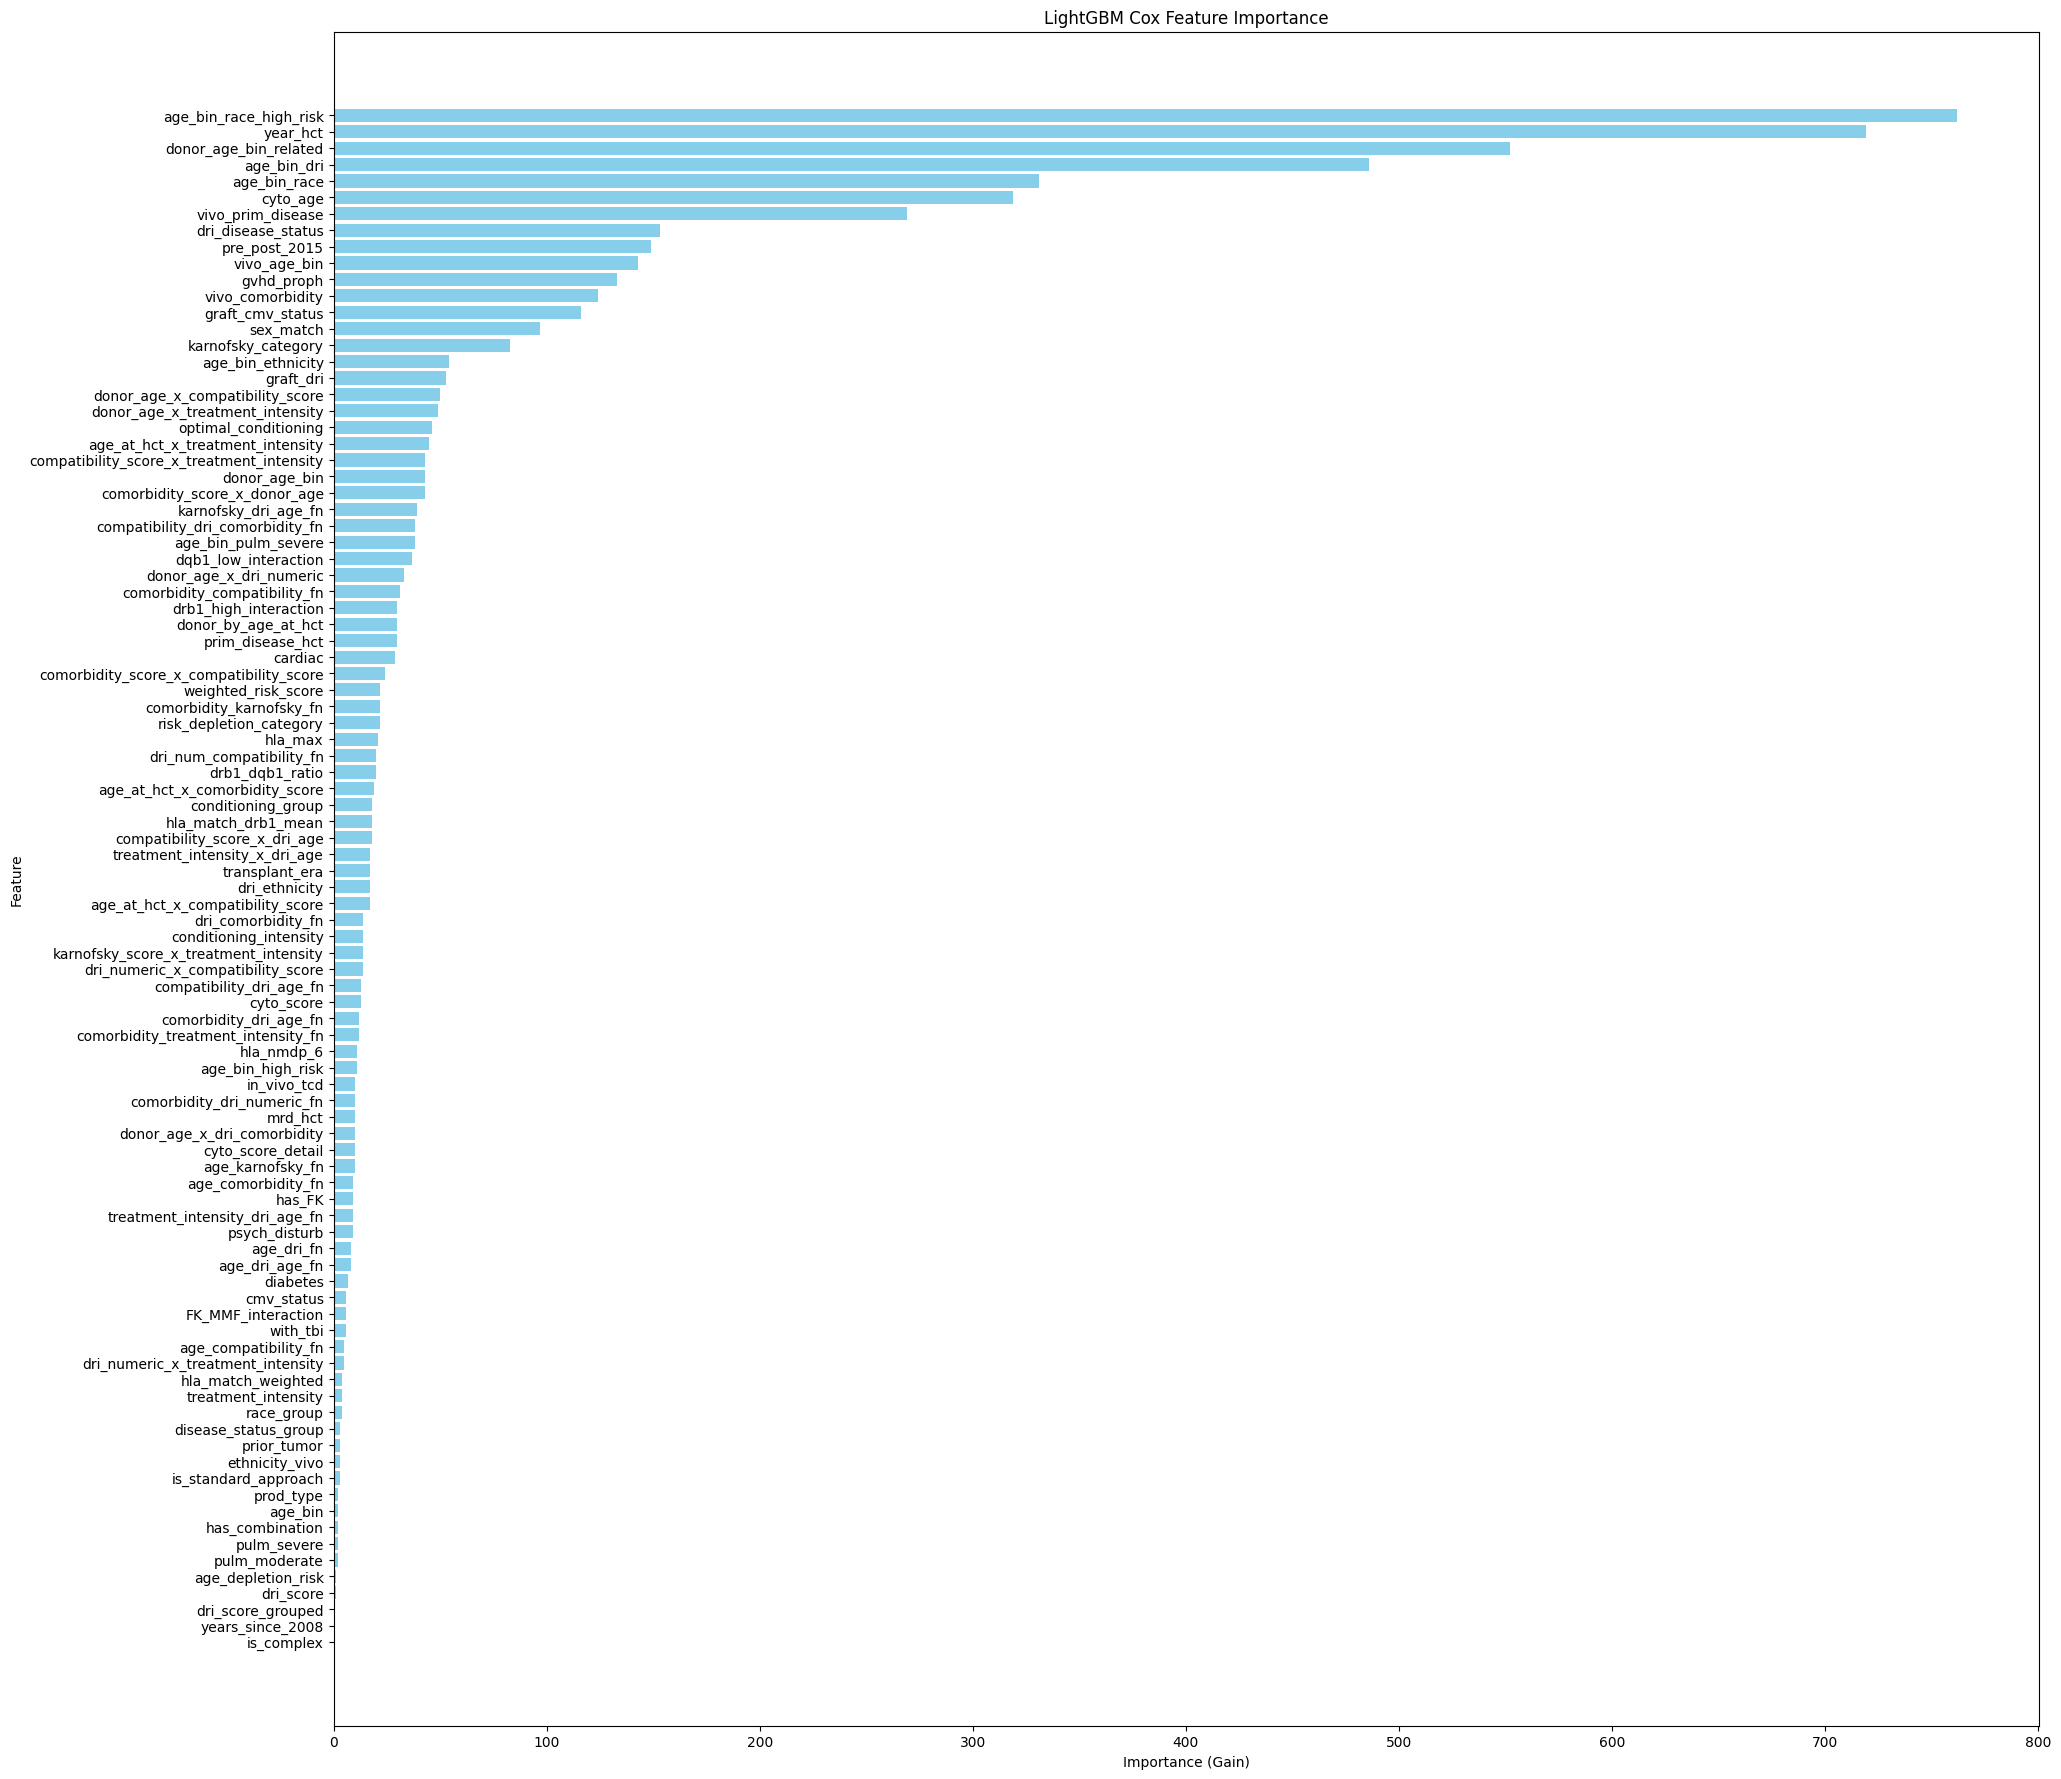

In [720]:
feature_importance = model_lgb_cox.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/lightgbm_cox_feature_importance.png')
plt.show()

# XGBoost with Nelson Aalen

In [721]:
# XGBoost with Nelson Aalen
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [722]:
# feature selection
FEATURES = [
    #'age_at_hct_squared',
    #'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    #'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    #'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    #'age_bin',
    #'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    #'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    'arrhythmia',
    'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    #'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    'comorbidity_score',
    'comorbidity_score_squared',
    #'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    'comorbidity_score_x_dri_comorbidity',
    'comorbidity_score_x_dri_numeric',
    #'comorbidity_score_x_karnofsky_score',
    'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    'diabetes',
    'disease_control_factor',
    'disease_status_group',
    #'disease_status_risk_score',
    #'donor_age_bin',
    'donor_age_bin_related',
    #'donor_age_squared',
    #'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    #'donor_age_x_dri_comorbidity',
    #'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    'dri_comorbidity',
    #'dri_comorbidity_squared',
    'dri_ethnicity',
    'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    'dri_numeric_x_dri_comorbidity',
    #'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    'dri_score_grouped',
    'dri_score_is_2',
    'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    #'hla_match_drb1_mean',  # cox only
    #'hla_match_total',
    #'hla_match_weighted',
    'hla_max',
    'in_vivo_tcd',
    #'is_complex',  # cox high
    'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    #'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    'karnofsky_score_x_dri_age',
    'karnofsky_score_x_dri_comorbidity',
    'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    #'prod_type',
    'psych_disturb',
    #'pulm_moderate',
    'pulm_severe',
    'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    'treatment_intensity',
    #'treatment_intensity_squared',
    #'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    #'weighted_risk_score',
    #'with_tbi',
    # added functions
    'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    'age_compatibility_fn',
    #'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    # added back features
    'dri_karnofsky',
    'karnofsky_score',
    'karnofsky_dri_comorbidity_fn',
    'dri_disease_status',
    'prim_disease_hct',
    'years_since_2008',
    'year_hct',
    'sex_match'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [723]:
class XGBoostModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_xgb_na_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'max_depth': trial.suggest_int('max_depth', 4, 7),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.08, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'n_estimators': trial.suggest_int('n_estimators', 600, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 80, 140),
            'device': 'cuda',
            'enable_categorical': True
        }
        
        model = XGBRegressor(**param)
        model.fit(
            train_data[features], train_data['y_na'],
            eval_set=[(valid_data[features], valid_data['y_na'])],
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, XGBRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_xgb: Predictions for test set
            - oof_xgb: Out-of-fold predictions for training set
            - xgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_xgb_na = np.zeros(len(train))
        pred_xgb_na = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'max_depth': 6,
                    'colsample_bytree': 0.5,
                    'subsample': 0.8,
                    'n_estimators': 2000,
                    'learning_rate': 0.01,
                    'min_child_weight': 80,
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]

            model_params = {
                **self.best_params,
                'device': 'cuda',
                'enable_categorical': True
            }
            
            model = XGBRegressor(**model_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=500
            )
            
            if i == 0:
                best_model = model

            oof_xgb_na[valid_idx] = model.predict(x_valid)
            pred_xgb_na += model.predict(x_test)

        pred_xgb_na /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_xgb_na
        xgb_na_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {xgb_na_score}")
        
        return pred_xgb_na, oof_xgb_na, xgb_na_score, best_model

In [724]:
# Initialize the model
xgb_na_model = XGBoostModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_xgb_na, oof_xgb_na, xgb_na_score, model_xgb_na = xgb_na_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

Training fold 1/10
[0]	validation_0-rmse:0.17629
[500]	validation_0-rmse:0.15907
[624]	validation_0-rmse:0.15923
Training fold 2/10
[0]	validation_0-rmse:0.17193
[500]	validation_0-rmse:0.15543
[624]	validation_0-rmse:0.15592
Training fold 3/10
[0]	validation_0-rmse:0.17566
[500]	validation_0-rmse:0.15653
[624]	validation_0-rmse:0.15666
Training fold 4/10
[0]	validation_0-rmse:0.17769
[500]	validation_0-rmse:0.15905
[624]	validation_0-rmse:0.15905
Training fold 5/10
[0]	validation_0-rmse:0.17229
[500]	validation_0-rmse:0.15670
[624]	validation_0-rmse:0.15661
Training fold 6/10
[0]	validation_0-rmse:0.17600
[500]	validation_0-rmse:0.16014
[624]	validation_0-rmse:0.16020
Training fold 7/10
[0]	validation_0-rmse:0.17698
[500]	validation_0-rmse:0.16146
[624]	validation_0-rmse:0.16175
Training fold 8/10
[0]	validation_0-rmse:0.17315
[500]	validation_0-rmse:0.15917
[624]	validation_0-rmse:0.15969
Training fold 9/10
[0]	validation_0-rmse:0.17511
[500]	validation_0-rmse:0.15997
[624]	validatio

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


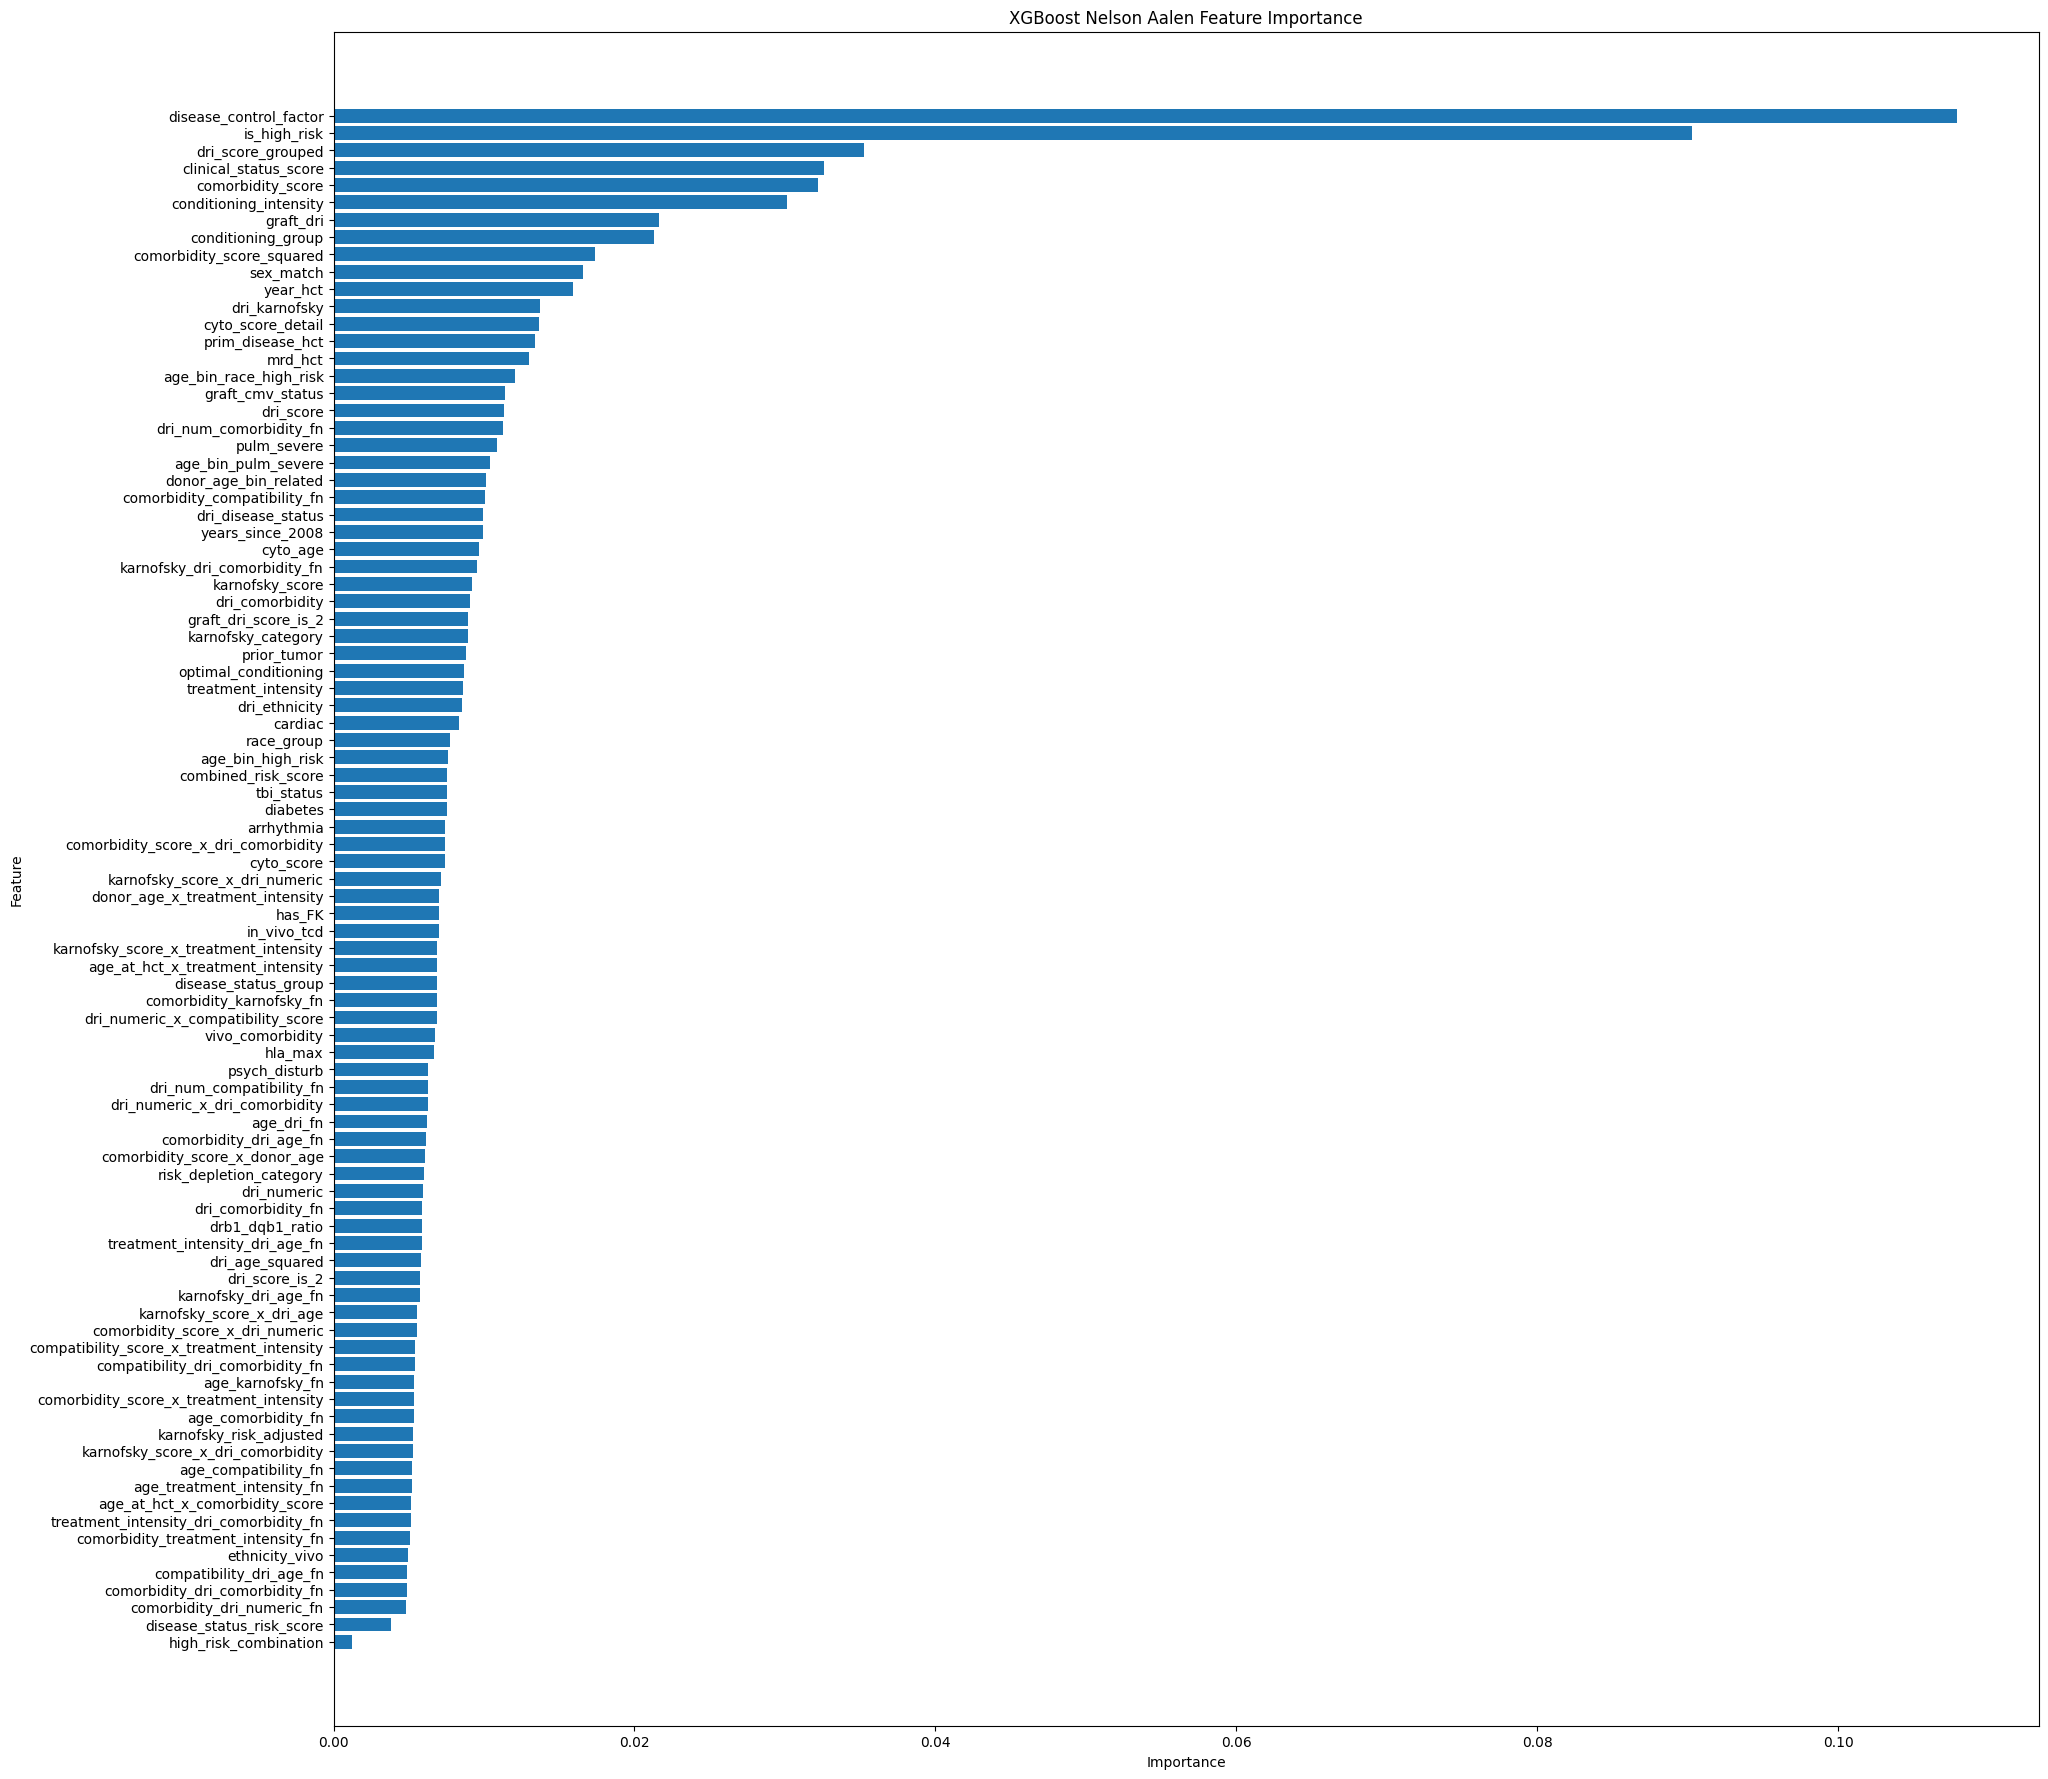

In [725]:
feature_importance = model_xgb_na.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Nelson Aalen Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/xgboost_na_feature_importance.png')
plt.show()

# CatBoost with Nelson Aalen

In [726]:
# CatBoost with Nelson Aalen
# feature selection
FEATURES = [
    #'age_at_hct',
    #'age_at_hct_squared',
    'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    #'age_at_hct_x_dri_comorbidity',
    #'age_at_hct_x_dri_numeric',
    'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    #'age_bin',
    'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    #'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    'arrhythmia',
    'cardiac',
    'clinical_status_score',
    'combined_risk_score',
    'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    #'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    #'comorbidity_score',
    #'comorbidity_score_squared',
    'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    #'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    #'comorbidity_score_x_dri_numeric',
    'comorbidity_score_x_karnofsky_score',
    #'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    'diabetes',
    #'disease_control_factor',
    'disease_status_group',
    #'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    'donor_age_squared',
    'donor_age_x_compatibility_score',
    #'donor_age_x_dri_age',
    #'donor_age_x_dri_comorbidity',
    'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    #'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    #'dri_comorbidity',
    #'dri_comorbidity_squared',
    'dri_ethnicity',
    #'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    'dri_numeric_x_dri_comorbidity',
    #'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    'dri_score_grouped',
    #'dri_score_is_2',
    'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    #'hla_match_drb1_mean',  # cox only
    'hla_match_total',
    #'hla_match_weighted',
    #'hla_max',
    #'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    #'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    #'karnofsky_score_x_dri_age',
    #'karnofsky_score_x_dri_comorbidity',
    #'karnofsky_score_x_dri_numeric',
    #'karnofsky_score_x_treatment_intensity',
    'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    #'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    #'prod_type',
    'psych_disturb',
    #'pulm_moderate',
    'pulm_severe',
    'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    'tbi_status',
    #'treatment_intensity',
    #'treatment_intensity_squared',
    #'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    #'with_tbi'
    # added functions
    'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    #'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    #'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    #'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    # added back features
    'year_hct',
    'donor_by_age_at_hct',
    'vivo_prim_disease',
    'sex_match',
    'gvhd_proph',
    'prim_disease_hct',
    'cmv_status',
    'karnofsky_score',
    'dri_disease_status',
    'age_bin_dri',
    #'age_bin_high_risk_flag',
    'age_bin_race',
    'age_bin_to_donor_age_bin'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [727]:
class CatBoostModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_catboost_na_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list, cat_features: List[str]) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'task_type': 'GPU',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Lossguide']),
            'depth': trial.suggest_int('depth', 2, 8),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'early_stopping_rounds': 50,
            'verbose': 0
        }
        
        # Handle special parameter dependencies
        if param['bootstrap_type'] == 'Bayesian':
            param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)
        
        model = CatBoostRegressor(**param)
        model.fit(
            train_data[features], train_data['y_na'],
            eval_set=(valid_data[features], valid_data['y_na']),
            cat_features=cat_features,
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        cat_features: List[str],
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, CatBoostRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            cat_features: List of categorical feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_cat: Predictions for test set
            - oof_cat: Out-of-fold predictions for training set
            - cat_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_cat_na = np.zeros(len(train))
        pred_cat_na = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(
                    trial, train_fold, valid_fold, features, cat_features
                ),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'task_type': 'GPU',
                'early_stopping_rounds': 50
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'task_type': 'GPU',
                    'learning_rate': 0.01,
                    'grow_policy': 'Lossguide',
                    'depth': 6,
                    'min_data_in_leaf': 1,
                    'l2_leaf_reg': 3.0,
                    'random_strength': 1,
                    'n_estimators': 2000,
                    'bootstrap_type': 'Bernoulli',
                    'subsample': 0.8,
                    'early_stopping_rounds': 50
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_na']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_na']
            x_test = test[features]
            
            model = CatBoostRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=(x_valid, y_valid),
                cat_features=cat_features,
                verbose=250
            )
            
            if i == 0:
                best_model = model

            oof_cat_na[valid_idx] = model.predict(x_valid)
            pred_cat_na += model.predict(x_test)

        pred_cat_na /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_cat_na
        cat_na_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {cat_na_score}")
        
        return pred_cat_na, oof_cat_na, cat_na_score, best_model

In [728]:
# Initialize the model
cat_na_model = CatBoostModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_cat_na, oof_cat_na, cat_na_score, model_cat_na = cat_na_model.train_and_predict(
    train, test, FEATURES, CATS, tune_hyperparameters=False
)

Training fold 1/10
0:	learn: 0.2688810	test: 0.2716641	best: 0.2716641 (0)	total: 4.36ms	remaining: 5.17s
250:	learn: 0.2308906	test: 0.2455873	best: 0.2455271 (246)	total: 958ms	remaining: 3.57s
bestTest = 0.2449806079
bestIteration = 393
Shrink model to first 394 iterations.
Training fold 2/10
0:	learn: 0.2695663	test: 0.2653339	best: 0.2653339 (0)	total: 4.74ms	remaining: 5.62s
250:	learn: 0.2309790	test: 0.2399537	best: 0.2399137 (240)	total: 946ms	remaining: 3.53s
bestTest = 0.2397988497
bestIteration = 276
Shrink model to first 277 iterations.
Training fold 3/10
0:	learn: 0.2690942	test: 0.2696297	best: 0.2696297 (0)	total: 4.8ms	remaining: 5.69s
250:	learn: 0.2309945	test: 0.2413350	best: 0.2413350 (250)	total: 947ms	remaining: 3.53s
bestTest = 0.241286046
bestIteration = 269
Shrink model to first 270 iterations.
Training fold 4/10
0:	learn: 0.2687505	test: 0.2726323	best: 0.2726323 (0)	total: 4.4ms	remaining: 5.22s
250:	learn: 0.2304316	test: 0.2445603	best: 0.2445603 (250)	tot

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


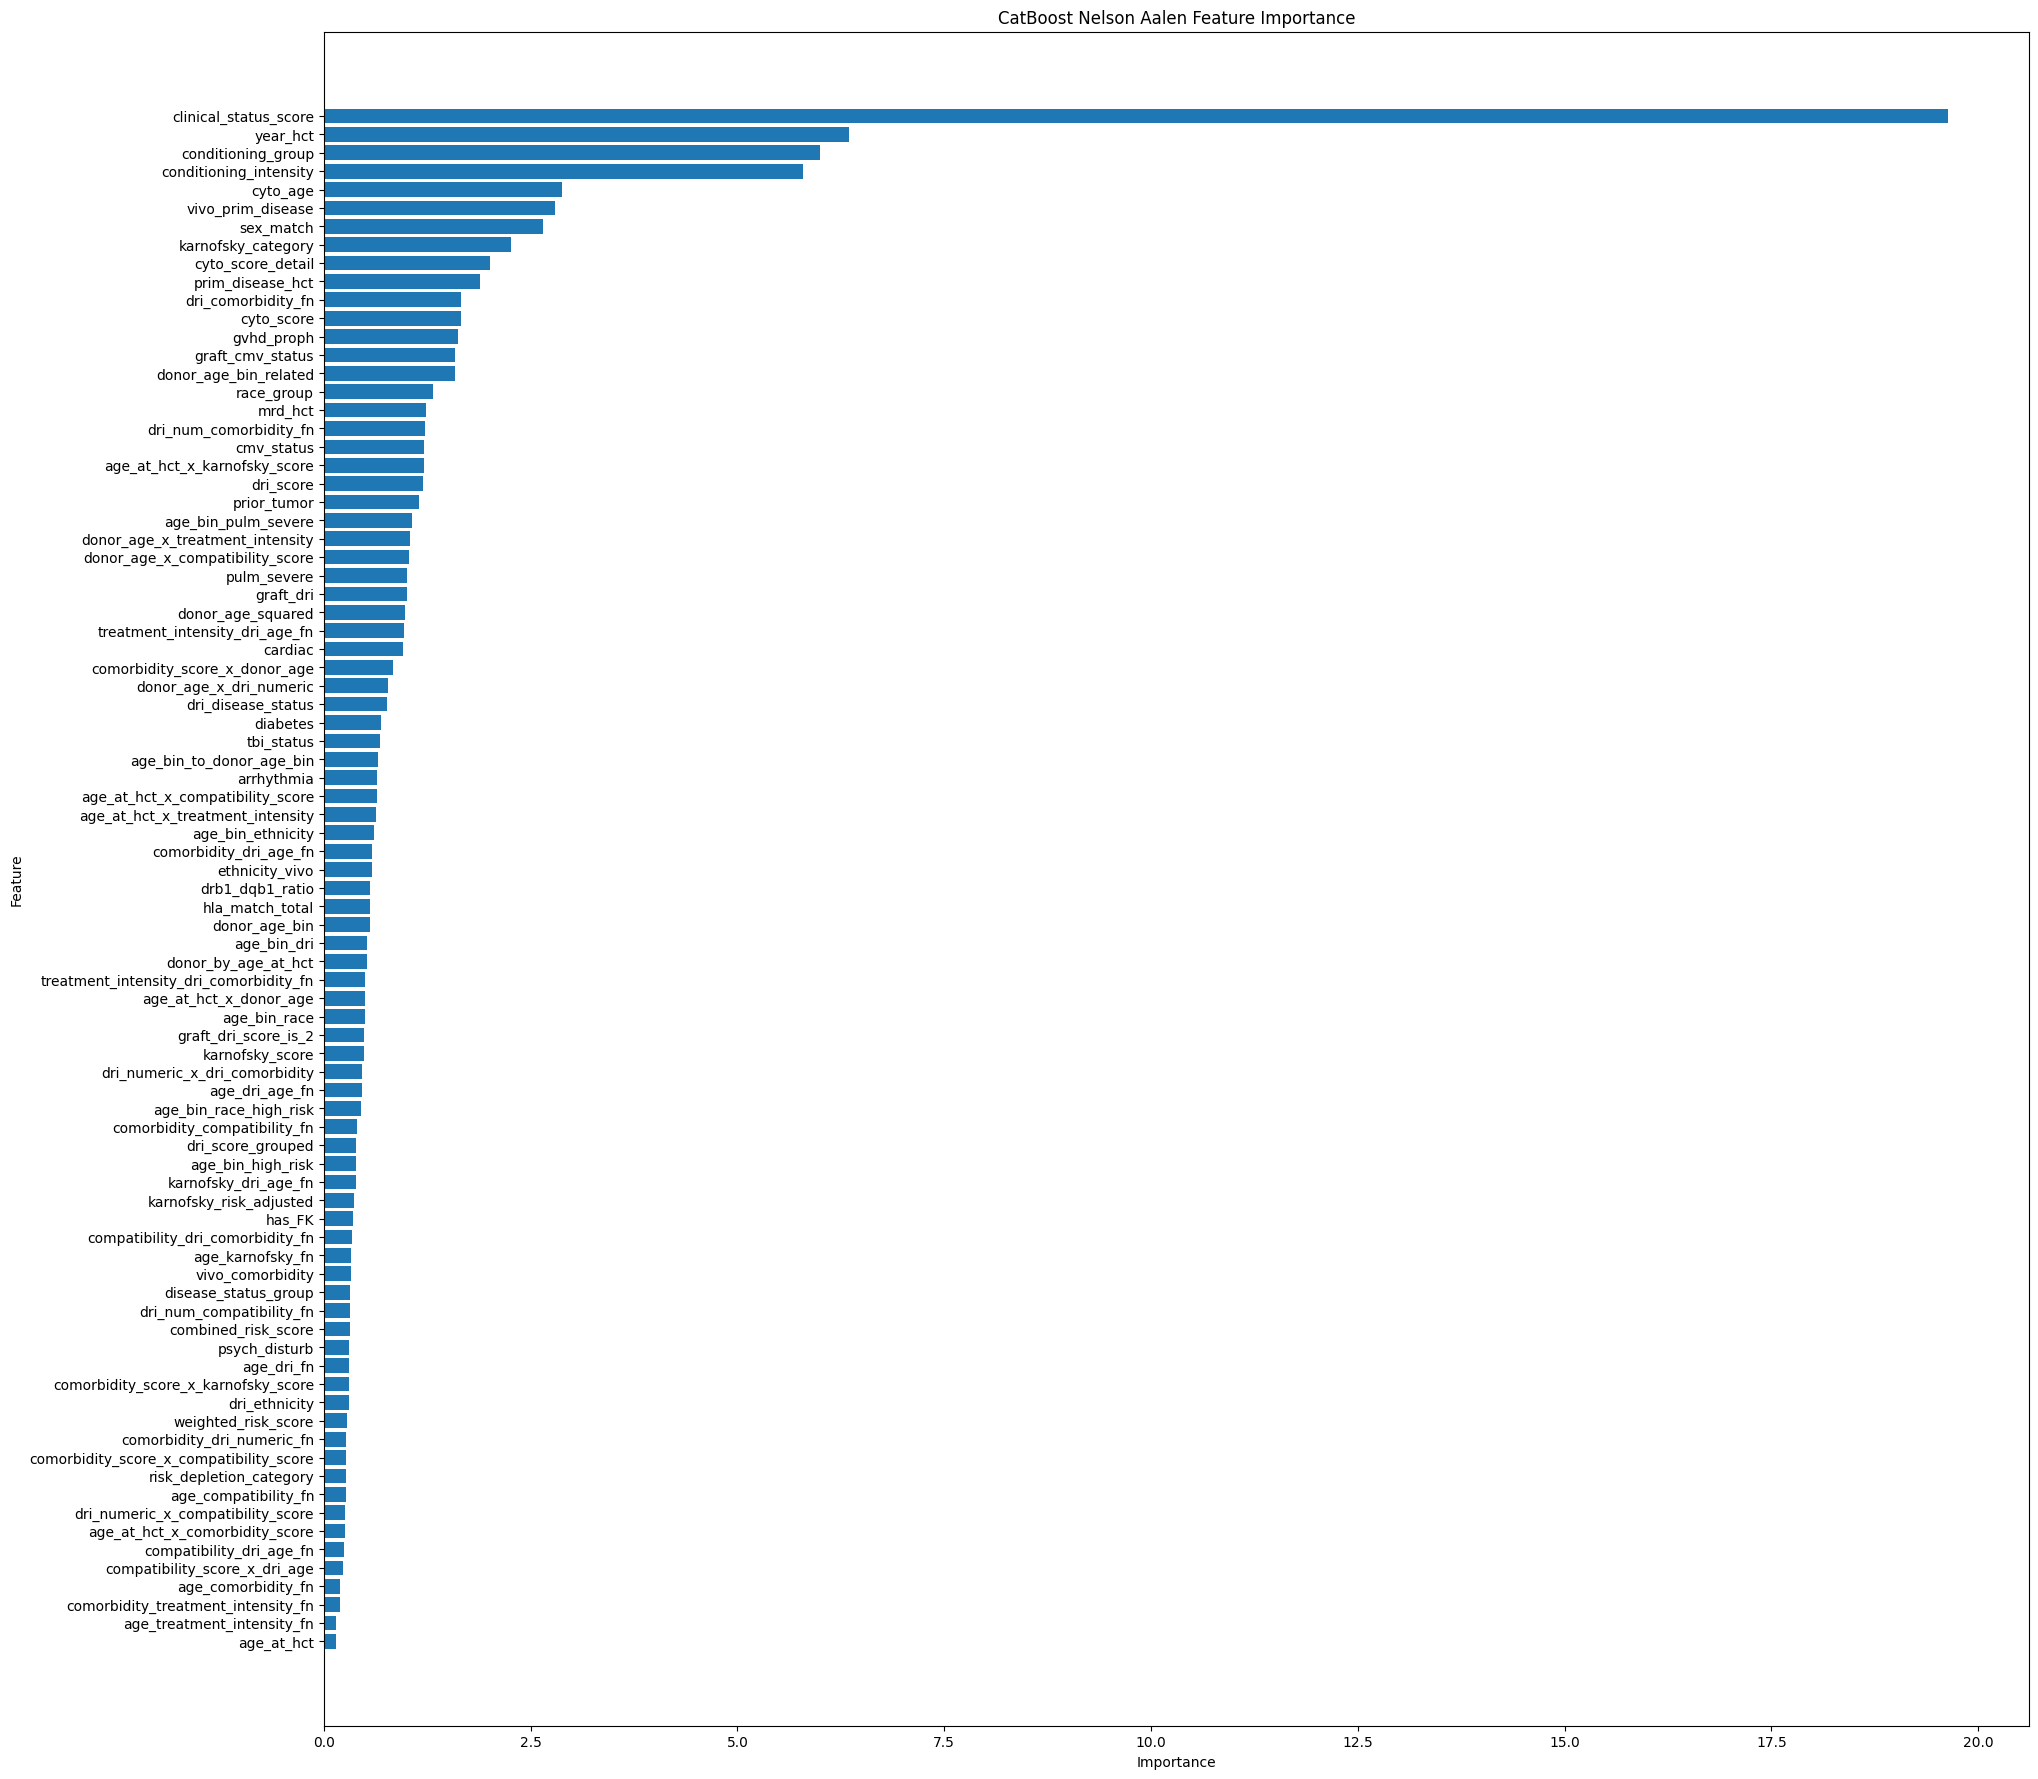

In [729]:
feature_importance = model_cat_na.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Nelson Aalen Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/catboost_na_feature_importance.png')
plt.show()

# LightGBM with Nelson Aalen

In [730]:
# LightGBM with Nelson Aalen
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.5.0


In [731]:
# feature selection
FEATURES = [
    'age_at_act',
    #'age_at_hct_squared',
    'age_at_hct_x_compatibility_score',
    'age_at_hct_x_comorbidity_score',
    'age_at_hct_x_donor_age',
    #'age_at_hct_x_dri_age',
    'age_at_hct_x_dri_comorbidity',
    'age_at_hct_x_dri_numeric',
    'age_at_hct_x_karnofsky_score',
    'age_at_hct_x_treatment_intensity',
    #'age_bin',
    'age_bin_ethnicity',
    #'age_bin_favorable_flag',
    'age_bin_high_risk',
    'age_bin_pulm_severe',
    'age_bin_race_high_risk',
    #'age_bin_risk_score',
    'age_comorbidity_interaction',
    #'age_depletion_risk',
    #'age_quantile',
    #'age_risk_group',
    'arrhythmia',
    'cardiac',
    #'clinical_status_score',
    'combined_risk_score',
    'compatibility_score_x_dri_age',
    #'compatibility_score_x_dri_comorbidity',
    'compatibility_score_x_treatment_intensity',
    #'comorbidity_quantile',
    #'comorbidity_score',
    #'comorbidity_score_squared',
    'comorbidity_score_x_compatibility_score',
    'comorbidity_score_x_donor_age',
    'comorbidity_score_x_dri_age',
    #'comorbidity_score_x_dri_comorbidity',
    #'comorbidity_score_x_dri_numeric',
    'comorbidity_score_x_karnofsky_score',
    'comorbidity_score_x_treatment_intensity',
    #'condition_severity',
    #'conditioning_group',
    'conditioning_intensity',
    'cyto_age',
    'cyto_score',
    'cyto_score_detail',
    'diabetes',
    #'disease_control_factor',
    #'disease_status_group',
    #'disease_status_risk_score',
    'donor_age_bin',
    'donor_age_bin_related',
    'donor_age_squared',
    'donor_age_x_compatibility_score',
    'donor_age_x_dri_age',
    'donor_age_x_dri_comorbidity',
    'donor_age_x_dri_numeric',
    'donor_age_x_treatment_intensity',
    #'dqb1_low_interaction',  # cox only
    #'drb1_dqb1_diff',
    'drb1_dqb1_ratio',
    #'drb1_high_interaction',  # cox only
    #'dri_age_squared',
    #'dri_age_x_dri_comorbidity',
    #'dri_comorbidity',
    #'dri_comorbidity_squared',
    'dri_ethnicity',
    #'dri_numeric',
    #'dri_numeric_squared',
    'dri_numeric_x_compatibility_score',
    #'dri_numeric_x_dri_age',
    #'dri_numeric_x_dri_comorbidity',
    #'dri_numeric_x_treatment_intensity',
    #'dri_quantile',
    'dri_score',
    #'dri_score_grouped',
    #'dri_score_is_2',
    'ethnicity_vivo',
    #'FK_MMF_interaction',  # cox high
    'graft_cmv_status',
    'graft_dri',
    #'graft_dri_score_is_2',
    #'graft_risk_interaction',
    #'graft_type',
    #'has_combination',
    #'has_FK',  # cox high
    #'has_MMF',  # cox high
    #'hepatic_mild',
    #'high_risk_combination',  # commented out in original
    #'hla_match_drb1_mean',  # cox only
    'hla_match_total',
    #'hla_match_weighted',
    'hla_max',
    #'in_vivo_tcd',
    #'is_complex',  # cox high
    #'is_high_risk',
    #'is_standard_approach',  # cox high
    #'is_standard_risk',  # cox only, negative for others
    'karnofsky_age_at_hct',
    #'karnofsky_below_70',
    'karnofsky_category',
    'karnofsky_risk_adjusted',
    'karnofsky_score_x_dri_age',
    #'karnofsky_score_x_dri_comorbidity',
    #'karnofsky_score_x_dri_numeric',
    'karnofsky_score_x_treatment_intensity',
    #'mrd_hct',  # cox only
    #'multiple_conditions',
    #'n_agents',  # cox high
    #'obesity',
    #'optimal_conditioning',
    #'optimal_disease_status',
    'prior_tumor',
    #'prod_type',
    #'psych_disturb',
    #'pulm_moderate',
    #'pulm_severe',
    'race_group',
    'risk_depletion_category',
    #'risk_score_dri_weighted',
    #'risk_score_equal',
    #'tbi_status',
    #'treatment_intensity',
    #'treatment_intensity_squared',
    'treatment_intensity_x_dri_age',
    #'treatment_intensity_x_dri_comorbidity',
    'vivo_comorbidity',
    'weighted_risk_score',
    #'with_tbi'
    # added functions
    'dri_comorbidity_fn',
    'dri_num_comorbidity_fn',
    'dri_num_compatibility_fn',
    'compatibility_dri_age_fn',
    'compatibility_dri_comorbidity_fn',
    'comorbidity_compatibility_fn',
    'comorbidity_dri_age_fn',
    #'comorbidity_dri_comorbidity_fn',
    'comorbidity_dri_numeric_fn',
    'comorbidity_karnofsky_fn',
    'comorbidity_treatment_intensity_fn',
    'age_comorbidity_fn',
    'age_compatibility_fn',
    'age_dri_age_fn',
    'age_dri_fn',
    'age_karnofsky_fn',
    #'age_treatment_intensity_fn',
    'karnofsky_dri_age_fn',
    'treatment_intensity_dri_age_fn',
    'treatment_intensity_dri_comorbidity_fn',
    # added back features
    'age_bin_dri',
    #'age_bin_high_risk_flag',
    'age_bin_race',
    'age_bin_to_donor_age_bin',
    'dri_disease_status',
    'gvhd_proph',
    'vivo_age_bin'
]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [732]:
class LightGBMModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_lgb_na_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'device': 'gpu',
            'gpu_use_dp': True,
            'num_leaves': trial.suggest_int('num_leaves', 25, 63),
            'max_depth': trial.suggest_int('max_depth', 2, 9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.4),
            'subsample': trial.suggest_float('subsample', 0.2, 0.8),
            'n_estimators': trial.suggest_int('n_estimators', 400, 1400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 40, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.1),
            'objective': 'regression',
            'verbose': -1
        }
        
        model = LGBMRegressor(**param)
        model.fit(
            train_data[features], train_data['y_na'],
            eval_set=[(valid_data[features], valid_data['y_na'])]
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, LGBMRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_lgb: Predictions for test set
            - oof_lgb: Out-of-fold predictions for training set
            - lgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_lgb_na = np.zeros(len(train))
        pred_lgb_na = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'device': 'gpu',
                'gpu_use_dp': True,
                'objective': 'regression'
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'device': 'gpu',
                    'num_leaves': 31,
                    'max_depth': 3,
                    'colsample_bytree': 0.4,
                    'subsample': 0.8,
                    'n_estimators': 2500,
                    'learning_rate': 0.01,
                    'objective': 'regression',
                    'gpu_use_dp': True
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_na']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_na']
            x_test = test[features]
            
            model = LGBMRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)]
            )
            
            if i == 0:
                best_model = model

            oof_lgb_na[valid_idx] = model.predict(x_valid)
            pred_lgb_na += model.predict(x_test)

        pred_lgb_na /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_lgb_na
        lgb_na_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {lgb_na_score}")
        
        return pred_lgb_na, oof_lgb_na, lgb_na_score, best_model

In [733]:
# Initialize the model
lgb_na_model = LightGBMModel(n_folds=10, n_trials=400)

# For hyperparameter tuning:
pred_lgb_na, oof_lgb_na, lgb_na_score, model_lgb_na = lgb_na_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

Training fold 1/10
Training fold 2/10
Training fold 3/10
Training fold 4/10
Training fold 5/10
Training fold 6/10
Training fold 7/10
Training fold 8/10
Training fold 9/10
Training fold 10/10

Overall CV Score: 0.639866870442888


d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


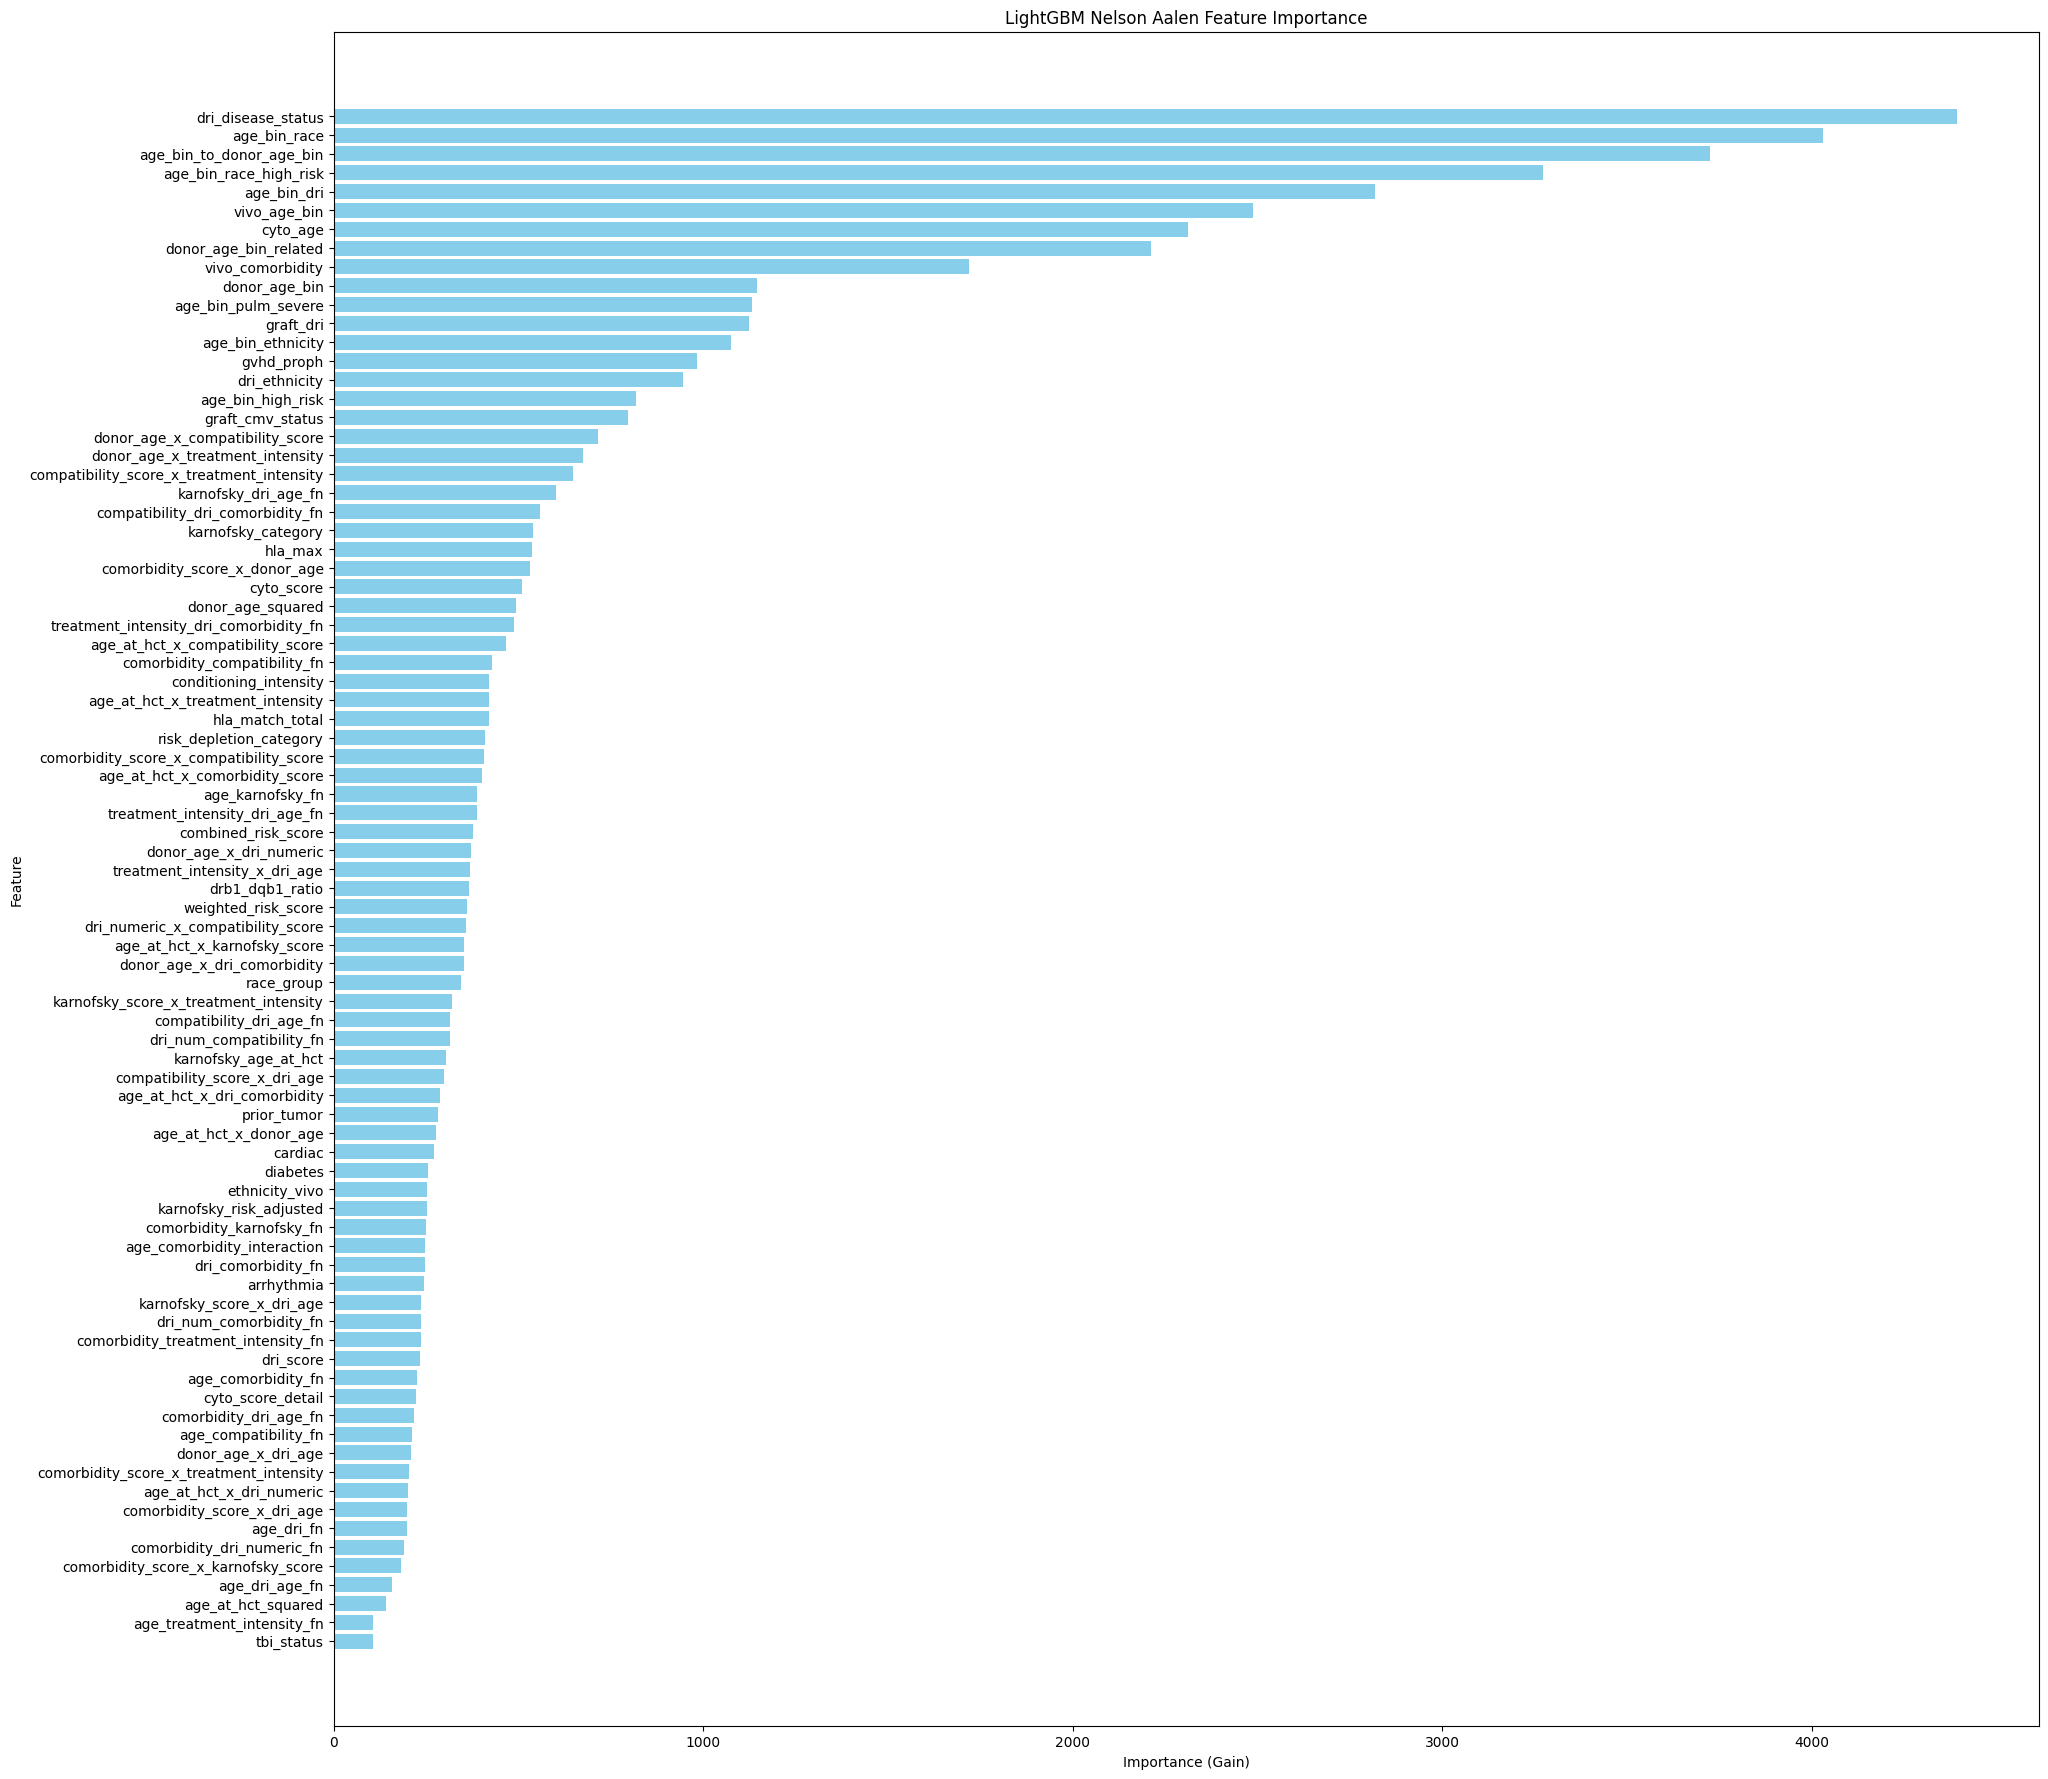

In [734]:
feature_importance = model_lgb_na.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM Nelson Aalen Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}/lightgbm_na_feature_importance.png')
plt.show()

In [735]:
print(f"\nxgb score =",xgb_score)
print(f"\ncat score =",cat_score)
print(f"\nlgb score =",lgb_score)
print(f"\nxgb cox score =",xgb_cox_score)
print(f"\ncat cox score =",cat_cox_score)
print(f"\nlgb cox score =",lgb_cox_score)
print(f"\nxgb na score =",xgb_na_score)
print(f"\ncat na score =",cat_na_score)
print(f"\nlgb na score =",lgb_na_score)


xgb score = 0.6610464277993929

cat score = 0.6627911920819621

lgb score = 0.6532129302668902

xgb cox score = 0.6620311132540742

cat cox score = 0.6619134371369888

lgb cox score = 0.6022692323779792

xgb na score = 0.660279259958815

cat na score = 0.6687077559177494

lgb na score = 0.639866870442888


In [736]:
# add lgb_cox, xgb_na, cat_na, lgb_na
oof_preds = [
    oof_xgb, #km
    oof_cat, #km
    oof_lgb, #km
    oof_xgb_cox, #cox efstime2
    oof_cat_cox, #cox efstime2
    oof_lgb_cox, #cox efstime2
    oof_xgb_na, #na
    oof_cat_na,
    oof_lgb_na
]

weights = [2.0, 2.0, 1.0, 2.0, 2.0, 0.5, 3.0, 4.0, 1.0]

In [737]:
ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])

In [738]:
ensemble_oof_preds = np.sum([w * p for w, p in zip(weights, ranked_oof_preds)], axis=0)

In [739]:
# Ensemble CAT and XGB and LGB
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = ensemble_oof_preds
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6710307681877006


d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


In [740]:
preds = [
    pred_xgb,
    pred_cat,
    pred_lgb,
    pred_xgb_cox,
    pred_cat_cox,
    pred_lgb_cox,
    pred_xgb_na,
    pred_cat_na,
    pred_lgb_na
]

In [741]:
ranked_preds = np.array([rankdata(p) for p in preds])

In [742]:
ensemble_preds = np.sum([w * p for w, p in zip(weights, ranked_preds)], axis=0)

In [743]:
sub = pd.read_csv("input/data/sample_submission.csv")

# Print individual model rankings with np.set_printoptions for full output
np.set_printoptions(threshold=np.inf)

# Combine rankings
sub.prediction = ensemble_preds

print("\nFinal ensemble scores:")
print(sub.prediction)

sub.to_csv("submission.csv", index=False)
print("\nSub shape:", sub.shape)
sub.head()


Final ensemble scores:
0    32.5
1    52.5
2    20.0
Name: prediction, dtype: float64

Sub shape: (3, 2)


ID  prediction
0  28800        32.5
1  28801        52.5
2  28802        20.0